<h1 style="text-align: center; font-size: 24pt; color : #f31567; font-family: Comic Sans MS;">
    Analytic Model for Light Yield Estimation version 2.0 
<!-- <span style= 'color : #f31567'> Analytic Model for Light Yield Estimation version 2.0 </span>  -->
<!-- <span style= 'color : #f31567'> Analytic Model for Estimating Light Collection Efficiency Version 2.0 </span>  -->
</h1>
<br>
<br>

<div style="width:1050px;height:50px;border:1px solid red; background-color: black;"> 
<p style='color: white;font-size:18pt;'> <b>
important: <span style='color: white;'> As of 12 Dec 2021, this notebook has latest changes. </span> </b>
</p>
</div>

<p style='color : #9932CC;  font-size: 16pt; font-family: Comic Sans MS;'>
    Story so far.. :
<span style= 'color : silver; text-align: center;font-family: Comic Sans MS;'> This notebook is written to implement Segreto model.
    <ol style = 'font-family: consolas;'>
       <li> It has the provision to include the Rayleigh scattering and absorption. ✅</li> 
       <li> renamed few variables to be compliant with Segreto's paper. ✅</li>
       <li> I will add additional terms later for the configuration where even SiPM is covered with WLS. ✅</li>
        <li> we have a serious problem when f_sen =1, LY =0 which shouldn't be the case. ✅</li>
        <li> Are regular SiPM's sensitive to VUV?
            <span style ='color: lightgreen;'> short answer: NO! </span>
        <li> check out why Segreto has a weird way of extrapolating his model when number of SiPM > 1 </li>
        <li> what is WLS's reflectance to VUV</li>
        <li> We are not accounting for absorption of Visible light in WLS coated over SiPM, obviously without ESR its reflectance will drop and it will allow visible photon to pass more freely but absorption and reflectance could still be significant. To fix this we should use reflectance values of WLS coupled with SiPM.<span style = 'color: orange;'> Ask Marcin. </span></li>
        <li> Confirm TPC and Titanium Vessel dimensions ✅
        <li> Verified V1 and V2 are consistent with eacher other when SiPM's are not covered. ✅</li>
        <li> </li>
        <li> </li>
        <li> </li>
    </ol>

</span> 
<p style = 'color: skyblue;'> Important notes:
<ul>
       <li> default value Q_vis = 1</li>
        <li> default value Q_vuv = 1</li>
        <li> default value $\epsilon_{wls} = 1 $</li>
        <li> default value SY=40</li>
        <li> throughout this notebook the unit of length is m</li>
</ul>
</p>

<h2 style = 'text-align: center; font-size: 24pt; color: #66AAEE;'> Setting up the notebook</h2>

In [1]:
%%html
<!--- html styling for Jupyter Dark Theme---!>
<style>
.CodeMirror-focused .CodeMirror-selected { background: none; }
.CodeMirror-focused .CodeMirror-selectedtext { color: black !important; background: #50F148; } 
.CodeMirror-selected { background:  grey; }
</style>
<!--- greenish #00FF88 ; pinkish #FF0088 ; turquoise---!>

In [2]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return False;
# }

In [3]:
from os import path
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib import rc
# %matplotlib inline
# %matplotlib qt

In [4]:
# Change rc parameters for all matplotlib plots
# rc('figure', autolayout=True, dpi=125)
rc('figure', autolayout=True, figsize=[16, 9], dpi=125)
rc('font', family='monospace')
rc('axes', titlesize=20, titleweight='heavy', labelsize=18, labelweight='bold')
rc(('xtick', 'ytick'), labelsize = 16)
rc('legend', fontsize=14)

<h1 style = 'color: #ff0038; text-align: center'> Light Yield Analytic Model</h1>

<p style = 'color: silver;'> Formulation for simple Analytic Model without wavelength shifter and Absorption/scattering effects: </p>

<span style = 'color: lime;'>    
$$
LCE = \frac{X}{1-(s+w)} 
$$
<br>
$$ 
LCE = \frac{f_{sen}FF_{sys}(1-R)}{1-( f_{sen}R + (1-f_{sen})R_{wall} )}
$$
<br>
</span>

<p style = 'color:tomato; text-align: left; font-family: Comic Sans MS;'> 
    Overleaf Document: 
<a href="https://www.overleaf.com/read/vpkvkgpfqwst">https://www.overleaf.com/read/vpkvkgpfqwst</a>
<br>
    Research Notes: 
<a href="https://docs.google.com/document/d/1k-8OMUld0fGFGO-Om6wp_pJkQwOL-QxgrfYoKsZIPF4/edit">Google Docs link </a>
<br>
    Other Relevant Documentations: 
<a href="https://arxiv.org/pdf/1110.6370.pdf">Segreto 2012</a>    
</p>
<hr>

<h2 style = 'color:#66AAEE;'>    Data loading & Pre-processing </h2>

<p style ='color: silver; font-size: 14pt'> project directory is defined in the following cell; it will remain same through out the notebook.
</p>
<p style ='color: silver; font-size: 14pt'>PS:  The preprocessing is different for each file depending on its data structure.
</p>

<h3 style = 'color: #7bc5ef; '> ✏ Project Directory </h3>

In [5]:
### define project directory
project_dir = r'C:\Users\sarth\projects\LY_Analytic_Model'; 

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> SiPM Reflectance data </h3>
<!-- <p>
    SiPM Reflectance .dat file provided by Cenk
    <br>
    <span style = 'color: #FF6611; font-size: 18px'> Note: </span> 
    SiPM Reflectance is multiplied by 0.91 to take care of the effect of antireflective coating in Liquid Argon chamber (needs further investigtation)
</p> -->

In [6]:
R_SiPM_df = pd.read_csv(path.join(project_dir, 'Data','sipm_hr1_processed.txt'), sep = '\t')  ## 'Data' is the name of the folder containing Data files
R_SiPM = R_SiPM_df.copy()
R_SiPM['R'] = [int(value)/100 for value in R_SiPM_df['R']]

## cenk's data files for darkside veto are given below

# cenk_SiPM_R_df = pd.read_csv(path.join(project_dir, 'Data','SiPM_ref.csv'), sep = ',')
# # cenk_SiPM_R_values = cenk_SiPM_R_vector.copy()
# # cenk_R_SiPM_values['R'] = [int(value)/100 for value in cenk_R_SiPM_vector['R']]
# cenk_SiPM_R_df2 = cenk_SiPM_R_df.copy()
# cenk_SiPM_R_df2['LAr_equivalent_Reflectance'] = cenk_SiPM_R_df2['R']*0.91 

# ### Note: SiPM is coated with an unknown anti-reflection coating
# ### 0.91 : To get the unknown reflectivity of SiPM in Liquid Argon. Since SiPM is also coated with an anti reflection coating, getting the equivalent 
# ### reflectance is not straight forward. 0.91 is based on an educated guess.

# cenk_SiPM_R_df2['wavelength'] = 1239.847/cenk_SiPM_R_df2['E'] # Eneergy unit eV wavlength Unit: nm
# # SiPM_ref.dat
# # cenk_SiPM_R_df3 = cenk_SiPM_R_df2.sort_values(by = 'wavelength')

In [7]:
# cenk_SiPM_R_df2.head()

In [8]:
# plt.figure()
# plt.plot(cenk_SiPM_R_df2['wavelength'], cenk_SiPM_R_df2['R'])
# plt.plot(SiPM_R_values['Wavelength'], SiPM_R_values['R'])

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'>     SiPM PDE data</h3>
<p>
    Caustion : when using FBK PDE values, normalize with 40/52.77
    <br>
    Marcin: normalize LFoundry values as well. After normalizaton maximum value should be  40.
</p>

In [9]:
### FBK Values sent by cenk
# photon_wavelength = [285.87, 301.14, 320.99, 340.83, 365.26, 380.53, 391.22, 400.38, 411.06, 420.22, 435.49, 449.23, 464.50, 499.61, 588.16, 698.09]
# PDE_vector = [18.39, 37.24, 41.87, 42.43, 45.03, 48.12, 52.72, 52.75, 52.77, 52.29, 48.77, 46.26, 40.71, 38.76, 28.82, 18.93] # %age values
# PDE_normalized_vector = []
### Normalizing PDE values in FBK data as instructed by Cenk
# PDE_normalized_vector = [value*40/max(PDE_vector) for value in PDE_vector]
## PDE_normalized_vector
# norm_PDE_values = [value/100 for value in PDE_normalized_vector]

### LFoundry PDE Values sent by Cenk
photon_wavelength = [365.39, 390.34, 399.89, 409.98, 420.06, 434.93, 450.32, 500.21, 525.16, 545.33, 590.98, 630.25, 700.32]
PDE_vector = [43.277, 51.892, 54.257, 52.399, 50.709, 46.993, 42.601, 36.014, 30.439, 28.581, 24.358, 20.473, 15.574]
# Normalization for PDE values 
norm_PDE_values = [value*40/(100* max(PDE_vector)) for value in PDE_vector]


frame = {'photon_wavelength':photon_wavelength, 'PDE_norm': norm_PDE_values}

PDE = pd.DataFrame(frame)

# max(PDE['PDE_norm'])

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'>   PEN Reflectance Data </h3>
<!-- <p>
<span style= 'color: red; font-size : 22px'>  Needs verification !!! 
</span>
</p> -->

In [10]:
## R_wall_PEN = 
PEN_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,
2.884,2.918,2.952,2.988,3.024,3.039,3.047,3.054,3.062,3.069,3.077,3.085,3.092,3.100,3.108,3.116,3.123,3.131,3.139,3.147,3.155,
3.163,3.171,3.179,3.188,3.196,3.204,3.212,3.221,3.263, 8.0] ## energy in eV

PEN_reflectance = [100.130, 100.130,99.995,99.856,99.681,99.659,99.569,99.351,99.306,99.018,98.652,98.415,98.283,
98.018,97.856,97.606,97.457,97.134,96.928,96.827,96.247,95.737,95.359,95.197,95.048,94.876,94.684,94.463,94.055,93.650,93.147,
92.562,91.812,90.904,89.807,88.506,86.957,85.242,83.156,80.678,77.811,74.615,71.004,67.089,62.924,58.670,20.000, 20.000] ## %age reflectance

# PEN_reflectance = [reflectance*0.98/100 for reflectance in PEN_reflectance] 
PEN_reflectance = [reflectance*0.98*0.994/100 for reflectance in PEN_reflectance] 

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance


photon_wavelength = []

for energy_value in PEN_photon_energy:
    wavelength_value = 1239.847/energy_value
    photon_wavelength.append(wavelength_value)

frame = {'photon_wavelength': photon_wavelength,
        'PEN_reflectance': PEN_reflectance}

R_Wall_PEN = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_PEN = R_Wall_PEN.iloc[::-1]

# R_Wall_PEN

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> PEN Emission Spectrum </h3>

In [11]:
# r_PEN = r'D:\D Downloads\Current_work\pen-tess.txt'
r_PEN = path.join(project_dir, 'Data', 'pen-tess.txt')
emission_spectrum_PEN = pd.read_csv(r_PEN, sep ='\t')

E_PEN = emission_spectrum_PEN.drop(['a','b','c'], axis=1)

# E_PEN

# normalize : divide by maximum value
E_PEN['efficiency'] = E_PEN['efficiency']/max(E_PEN['efficiency'] ) 

# remove negative values
E_PEN = E_PEN[E_PEN > 0].dropna()
# E_PEN['efficiency']
## What are the units of efficiency? Normalize PEN Spectrum ??
## Remove negative values?
## Need linear interpolation for everyuthing R, R_Wall, PDE and emission spectrum

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> TPB Reflectance data </h3>

In [12]:
TPB_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,2.884,2.918,2.952,2.988,3.024, 3.221,3.263, 8.0]
TPB_reflectance = [98.936,98.936,99.180,99.309,99.375,99.392,99.534,99.490,99.491,99.685,99.635,99.593,99.541,99.457,99.380,99.374,99.196,98.924,98.521,97.653,95.581,92.569,13.0,3.0,3.0]

photon_wavelength = []

# TPB_reflectance = [reflectance*0.98/100 for reflectance in TPB_reflectance]
TPB_reflectance = [reflectance*0.98*0.994/100 for reflectance in TPB_reflectance]

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance

for energy_value in TPB_photon_energy:
    wavelength_value = 1239.847/energy_value
    photon_wavelength.append(wavelength_value)

frame = {'photon_wavelength': photon_wavelength,
        'TPB_reflectance': TPB_reflectance}

R_Wall_TPB = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_TPB = R_Wall_TPB.iloc[::-1]

# R_Wall_TPB

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt'> TPB Emission Spectrum </h3>

In [13]:
#### why do we have negative values?
#### Might need to clean data
## drop negative values
## normalize efficiency

# r_TPB = r'D:\D Downloads\Current_work\tpb-fran.txt'
r_TPB = path.join(project_dir, 'Data','tpb-fran.txt')
emission_spectrum_TPB = pd.read_csv(r_TPB, sep ='\t')

E_TPB = emission_spectrum_TPB.drop(['a','b','c','d'], axis=1)
# E_TPB

<p style = 'color:slate'> Click here to see a warning </p>
<!-- Warning: TPB data has negative values -->

In [14]:
# normalize : divide by maximum value
E_TPB['efficiency'] = E_TPB['efficiency']/max(E_TPB['efficiency'] ) 
# remove negative values
E_TPB = E_TPB[E_TPB > 0].dropna()

# E_TPB


<h3 style = 'color:deeppink'> Smoothing function </h3>

In [15]:
### variable name 'photon_wavelength' is NOT hard coded for all the data frames.
def make_smooth(data_frame_var):
    name_column_0 = data_frame_var.columns[0]
    name_column_1 = data_frame_var.columns[1]
    
    photon_wavelength = data_frame_var[name_column_0]
    physical_quantity = data_frame_var[name_column_1]
    
    interpol_func = interp1d(photon_wavelength , physical_quantity)
    return  interpol_func(wavelength_vector)

<h3 style = "font-size:18pt; font-family: courier prime; color: #7bc5ef; weight: bold"> ✏ Define Wavelength range </h3>
<br>
<p style = 'color:silver'>
    wavelength_vector is common throughout the notebook.
</p>

In [16]:
wavelength_vector = np.arange(366, 560, 0.5)  ### do we want to hard code wavelength range?

In [17]:
### call smoothing functions here
R_SiPM_smooth = make_smooth(R_SiPM)

R_Wall_PEN_smooth = make_smooth(R_Wall_PEN)

R_Wall_TPB_smooth = make_smooth(R_Wall_TPB)

PDE_smooth = make_smooth(PDE)

E_PEN_smooth = make_smooth(E_PEN)

E_TPB_smooth = make_smooth(E_TPB)   

<h2 style= 'color: #66AAEE'> Wavelength integrated LY with Absorbtion and Rayleigh Scattering effect </h2>

<br>
<p style = 'color: lightgreen; text-align: center;'>
<span style = 'color : lime;  font-size:14pt;'> 
$ X = f_{sen} \times FF_{sys} \times (1-R)$
    <br>
    <br>
    $ s = f_{sen} \times R $
    <br>
    <br>
    $ w = (1-f_{sen}) \times R_{wall} $
    <br>
    <br>
</span>
If $U_{RA}$ is the probability of interaction either absorption or Rayleigh scattering before photon completes one step, we define new X, s and w parameters to account for Absorption and Rayleigh Scattering:

<span style = 'color : lime;  font-size:14pt;'> 
    <br>
    <br>
    $ X_{RA} = U_{RA} \times X$
    <br>
    <br>
    $ (s_{RA} + w_{RA}) = U_{RA} \times (s + w) + (1 - U_{RA}) \times \frac{\lambda_{eff}}{\lambda_R} $
    <br>
    <br>
    $ LCE = \frac{X_{RA}}{1 - (s_{RA} + w_{RA})}   $
    <br>
    <br>
</span>
on substituting and rearranging terms: 
<span style = 'color: lime; font-size:14pt;'>
<br>
<br>
    $ LCE = \frac{X}{Q-(s+w)} $
</span>
<br>
<br>
    where
<br>
<br>
<span style ='color:lime; font-size:14pt;' >
$
U_{RA} = \int_0 ^\infty P(x) \, e^{-\frac{x}{\lambda_{eff}}}\,dx
$
<br>
<br>
$$
    \frac{1}{\lambda_{eff}} = \frac{1}{\lambda_{abs}} + \frac{1}{\lambda_{R}}
$$

<br>
<br>
$P(x) = \frac{1}{L_{char}}$
<br>    
<br>
$$ L_{char} = 6\times \frac{volume}{surface\_area}
$$
<br>
<br>
$
Q = \frac{1- (1 - U_{RA}) \times \frac{\lambda_{eff}}{\lambda_{R}}}{U_{RA}}
$
<br>
<br>
</span>
</p>

<h3 style = 'color: DeepPink '> calculating $Q$ factor </h3>

In [18]:
from sympy import Symbol, exp, integrate

x = Symbol('x')

## L_char is basically what L tilde is in segreto paper

## lambda_eff is basically lambda tilde in segreto paper

def calc_lambda_eff(lambda_abs, lambda_R):
    ''' Calculates effective lambda for Rayleigh scattering and Absorption.
    Unit of length: m
    '''
    return (lambda_R*lambda_abs)/(lambda_R + lambda_abs)

def P_func(L_char, lambda_eff):
    '''
    P_func: P(x) is the probability distribution of the distances that a photon would travel in absence of interactions (between two reflections or between a reflection and absorption/detection).
    The P_func can be changed later if it is felt that we need a different probability distribution function. 
    '''
    return 1/(L_char)

def calc_URA(L_char, lambda_eff, Prob_distr):
    return integrate( Prob_distr*exp(-x/lambda_eff), (x, 0, L_char))

def calc_Q( L_char,  lambda_abs, lambda_R):
    ''' 
    This function is used to compute Q factor for both visible and VUV photons.
    Note:
    We'll call calc_URA since URA is wavelength dependent. We'll also make a call to P_func for the same reason.
    '''
    lambda_eff = calc_lambda_eff(lambda_abs, lambda_R)
    
    Pdf = P_func(L_char, lambda_eff); # Probability distribution function
    
    URA_value = float(calc_URA(L_char, lambda_eff, Pdf));
    
    return (1-(1-URA_value)*lambda_eff/lambda_R)/(URA_value)

<h3 style = 'color:deeppink;'> Calculating characteristic length </h3>
<p style = 'color:lime; font-size:14pt'>
$$ L_{char} = 6\times \frac{volume}{surface\_area}
$$
</p>

In [19]:
def calc_char_length(area, volume):
    return 6*volume/area

<h3 style = 'color:DeepPink;'>  Calculating $F $ </h3>
<span style = 'color : lime;  font-size:14pt;'>

$$ 
F( Q, f_{sen}FF_{sys}(1-R), f_{sen}R + (1-f_{sen} )R_{wall} ) = \frac{f_{sen}FF_{sys}(1-\color{Red}R)}{\color{Red}Q-( f_{sen}\color{Red}R + (1-f_{sen})\color{Red}{R_{wall}} )}
$$
</span>
<span style = 'color : lime;  font-size:14pt;'>

$$ F(Q,X, s + w) = \frac{X}{Q-(s+w)} $$

</span>
<br>

In [20]:
def calc_F(R, R_wall, f_sen, FF_sys, Q_value):    
    '''
    R, R_wall are all wavelength dependent. Q_value is provided as an argument.
    ''' 
    return (f_sen*FF_sys*(1-R))/(Q_value - (f_sen*R + (1-f_sen)*R_wall) )

<h3 style = 'color: DeepPink '> Calculating Light Collection Efficiency, $LCE$ </h3>

<br>
<span style = 'color:lightgreen; font-size: 14pt'> When SiPM's are not covered with WLS. </span>
<span style = 'color:lime;  font-size:14pt;'> 
    $$
    LCE = \frac{(1-f_{sen}) \times \epsilon_{wls} \times \color{Red}{F(Q_{vis}, X, s+w)}}{Q_{VUV}}
    $$
</span>
<br>

<br>
<p style = 'color:lightgreen; font-size: 14pt'> When SiPM's are covered with WLS.
    <br>
    <span style = 'color:skyblue;'> Note: R_SiPM will be the reflectance of WLS coupled with SiPM.
    <br>
    Stack : WLS | SiPM  </span>
</p>
<br>

<span style = 'color:lime;  font-size:14pt;'> 
    $$
    LCE = \frac{(1-R) \times f_{sen} \times \epsilon_{wls} }{ 2 \times Q_{VUV}}  +  \left( \frac{f_{sen} \times \epsilon_{wls}}{ 2\times Q_{VUV}}  + \frac{ (1- f_{sen}) \times \epsilon_{wls} } {Q_{VUV}} \right) \times \color{Red}{F(Q_{vis}, X, s+w)} 
    $$

</span>
<br>

In [21]:
def calc_LCE(R, R_wall, f_sen, FF_sys, wls_eff, Q_vuv=1, Q_vis=1, SiPM_covered = False):
    ''' calc_LCE requires Q_vis and Q_vuv values as arguments. Both are set at default value of 1.
    Though Absorption and Rayleigh scattering lengths will be dependent on wavelength,
    currently we don't have accurate meansurements of these values for different wavelengths.
    Hence we will be using an average value for entire visible spectrum and another value for VUV (remember VUV photon has a single wavelength).
    In case accurate values of absorption and scattering lengths become available I will need to modify the Q_vis accordingly.
    Side note: Q_vis and Q_vuv are provided as arguments to the function integrate_LY.
    New!!! calc_LCE has additional Arguement SiPM_covered. 
    Note by default LCE is calculated for the case when SiPM is not covered with WLS.
    '''
    # if SiPM_covered == False:
    #     return (1-f_sen)*wls_eff*calc_F(R, R_wall, f_sen, FF_sys, Q_vis)/(Q_vuv)
    # elif SiPM_covered == True:
    #     return (wls_eff/Q_vuv)*( (1-R)*f_sen/2 + (1-0.5*f_sen)*calc_F(R, R_wall, f_sen, FF_sys, Q_vis) )
    if SiPM_covered:
        return (wls_eff/Q_vuv)*( (1-R)*f_sen/2 + (1-0.5*f_sen)*calc_F(R, R_wall, f_sen, FF_sys, Q_vis) )
    else:
        return (1-f_sen)*wls_eff*calc_F(R, R_wall, f_sen, FF_sys, Q_vis)/(Q_vuv)

<h3 style = 'color: DeepPink; text-align:center; font-size:24pt; '> 🍕 integrate Light Yield </h3>

<!-- <p>
Previously known as Weighted Average of Light Yield 
</p> -->

<!-- <p> 
<span style = 'color : #5EA9E5;'> 
<br>
% $$
% integrate\_LY = \frac{\sum( [LY\_value(\color{red}{PDE(\lambda)}, f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls} ) ] * \color{red}{E_{wls}(\lambda)})}{\sum \color{red}{E_{wls}(\lambda)}}
% $$
</span>
<br>
<br>
<br>
</p> -->

<span style = 'color : lime; font-size:14pt;'> 
<br>
<br>
$$
integrate\_LY = \frac{SY* \sum( [calc\_LCE(f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls}) ] * [ \color{red}{PDE(\lambda)} ] * [ \color{red}{E_{wls}(\lambda)} ] ) } {\sum \color{red}{E_{wls}(\lambda)}}
$$
</span>
<br>
<br>
<span style= ' font-size:14pt; text-align: left; color:lightgreen;'>
PS: <span style = 'color:red; '>Red </span>--> wavelength dependent
<br>
    $E_{wls}$ is the emission spectrum of wavelength shifter.
<br>
    $\epsilon_{wls}$ is the wavelength shifting efficiency. See variable wls_eff
</span>
<br>

In [22]:
# def integrate_LY(wavelength_range, WLS_emission_spectrum, PDE_smooth, R, R_wall, f_sen, FF_sys, SY=40): 
### think of a way so that we don't have to specify wavelength_vector from outside
def integrate_LY(wavelength_vector, WLS_emission_spectrum, PDE_smooth, R, R_wall, f_sen, FF_sys = 1, Q_vis = 1, Q_vuv = 1, wls_eff = 1.0, SY = 40, SiPM_covered = False):
    '''
    wavelength_vector is defined outside this function. 
    𝜖_𝑤𝑙𝑠 represents the wavelength shifting efficiency of the WaveLength Shifter assigned to variable wls_eff.
    '''
    # wavelength_vector = np.arange(wavelength_range[0], wavelength_range[1], wavelength_range[2])
    # wls_eff = 1.0
    
    numerator_value = 0 ;
    denominator_value = 0 ;
    
    ### lambda R and abs values provided by Marcin
    # Q_vis = calc_Q(L_char=1, lambda_abs=100, lambda_R=300) 
    # Q_vuv = calc_Q(L_char=1, lambda_abs=17, lambda_R=0.97)
    ### in case where we use average values of lambda_abs & lambda_R for entire visible range
    
    # default values when we are ignoting Absorption and Rayleigh scattering effect
    # Q_vuv = 1; 
    # Q_vis = 1;
    
    for wavelength_index in range(len(wavelength_vector)):
        numerator_value += calc_LCE(R[wavelength_index], R_wall[wavelength_index], f_sen, FF_sys, wls_eff, Q_vis, Q_vuv, SiPM_covered) * PDE_smooth[wavelength_index] * WLS_emission_spectrum[wavelength_index];
    denominator_value = sum(WLS_emission_spectrum)
    return SY*numerator_value/denominator_value

<h4 style = 'color: RED; font-size: 14pt'> Notes: </h4>
<p> Everything has been confirmed till this point for default case where Q=1. </p>

<h1 style = 'color: #ff0038; font-family: courier prime; font-size:28pt; text-align: center'> Application </h1>
<p style = 'color: orange'> we'll apply this model to different configuration of detectors and estimate their performance. 
<br>
Perhaps we should start with Dark Side veto since Cenk has already worked on it so we'll have his monte carlo simulations to compare with.
</p>

<h2 style= 'color: orange'> 2PAC</h2>

In [23]:
### First we will calculate the characteristic length for 2PAC, Characteristic length as defined in Segreto paper
area_2PAC = 2*np.pi*(0.0476/2)*(0.081) + 2*np.pi*(0.0476/2)**2 -2*(0.0079 * 0.0117)
volume_2PAC = 0.081*np.pi*(0.0476/2)**2

L_char_2PAC = calc_char_length(area_2PAC, volume_2PAC) ### unit: m

<span style= 'color:red;'> Note:  </span><span style = 'color:yellow'> exact area of WLS inside 2PAC is hard to calculate </span>

In [24]:
# we don't know accurate area covered by WLS inside the 2PAC as there is some area wasted due to screws etc.
f_sen_2PAC =  0.01176 ### value estimated by 2PAC team
# wasted_area = ?
# what f_sen would be if there was no wasted area 2*(0.0079 * 0.0117)/area_2PAC

In [25]:
### calculating Q for Argon filled 2PAC
Q_vis_2PAC = calc_Q(L_char_2PAC, lambda_abs= 100, lambda_R= 300)
Q_vuv_2PAC = calc_Q(L_char_2PAC, lambda_abs= 17, lambda_R= 0.97)

<h3 style = 'color: yellow;'> When SiPM is not covered with WLS </h3>

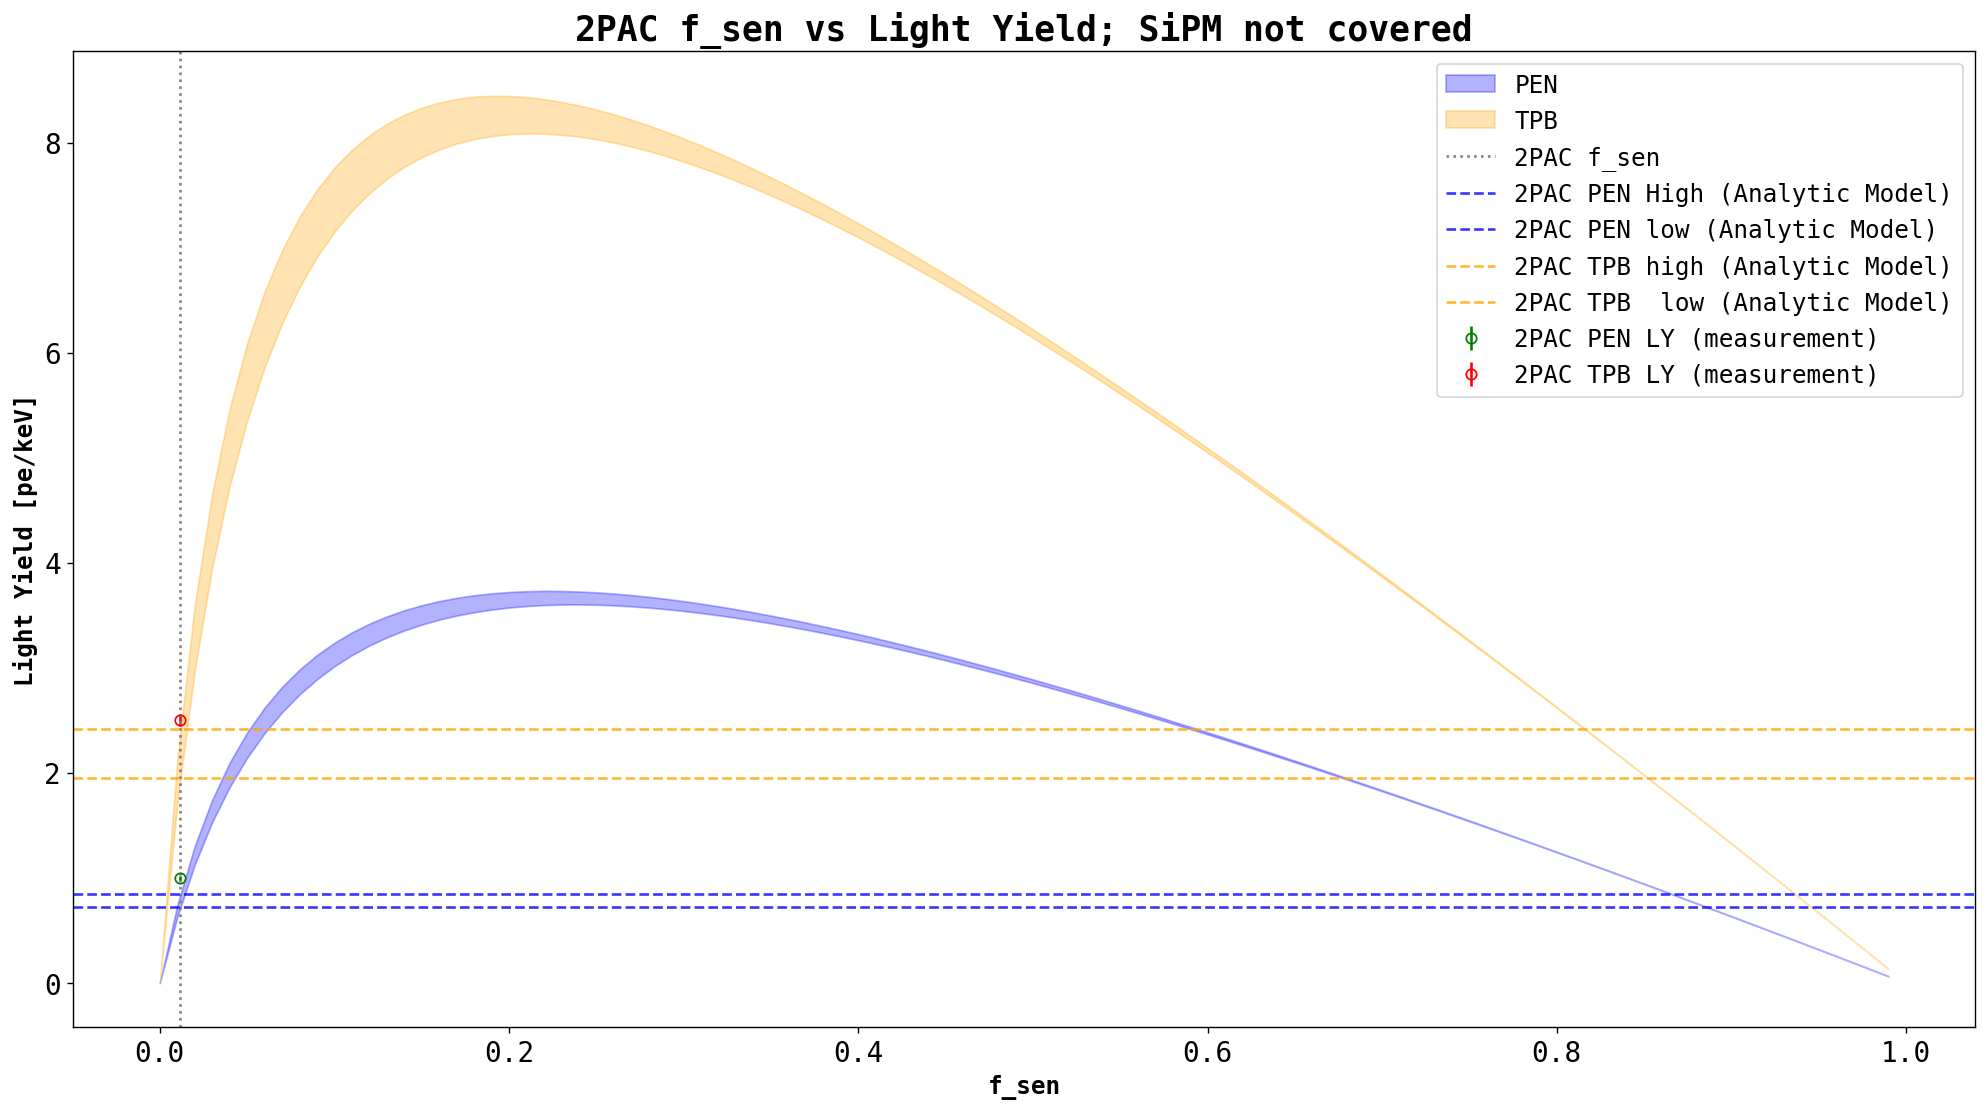

In [26]:
# F_sen value estimated for 2PAC
# f_sen_2PAC =  0.01176 

# %matplotlib qt
# %matplotlib inline

plt.close('2PAC f_sen vs LY, SiPM not covered')
plt.figure('2PAC f_sen vs LY, SiPM not covered')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector,wls_eff = 0.47, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-g')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-r')
# f_sen_vector = np.arange(0, 0.05, 0.01)
f_sen_vector = np.arange(0, 1, 0.01)
LY_PEN_upper = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC)
LY_PEN_lower = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC)
plt.fill_between( f_sen_vector, LY_PEN_lower,  LY_PEN_upper, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC)
LY_TPB_lower = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC)
plt.fill_between( f_sen_vector, LY_TPB_lower,  LY_TPB_upper, color='orange', alpha=0.3, label='TPB' )

### measurement values
plt.errorbar([0.01176], [2.50*0.40], yerr = [0.05*0.40], fmt ='o', mfc = 'none', color ='green', label = '2PAC PEN LY (measurement) ')
plt.errorbar([0.01176], [2.50], yerr = [0.05], fmt = 'o', mfc = 'none', color ='red', label = '2PAC TPB LY (measurement) ')

### horizontal lines correspond to the LY expected from 2PAC according to the Analytic Model
### ??? change f_sens from 0.01176 to 0.01

LY_PEN_2PAC_ref_high = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_2PAC, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC)
LY_PEN_2PAC_ref_low = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_2PAC, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC)

LY_TPB_2PAC_ref_high = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_2PAC, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC)
LY_TPB_2PAC_ref_low = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_2PAC, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC)

plt.axvline(f_sen_2PAC, 0, 1, linestyle = 'dotted', color = 'gray', label='2PAC f_sen')

plt.axhline(LY_PEN_2PAC_ref_high, 0, 1, linestyle = '--', color = 'blue', alpha =0.8, label='2PAC PEN High (Analytic Model)')
plt.axhline(LY_PEN_2PAC_ref_low, 0, 1, linestyle = '--', color = 'blue', alpha =0.8, label='2PAC PEN low (Analytic Model)')
plt.axhline(LY_TPB_2PAC_ref_high, 0, 1, linestyle = '--', color = 'orange', alpha =0.8, label='2PAC TPB high (Analytic Model)')
plt.axhline(LY_TPB_2PAC_ref_low, 0, 1, linestyle = '--', color = 'orange', alpha =0.8, label='2PAC TPB  low (Analytic Model)')

plt.ylabel('Light Yield [pe/keV]' , size =14, weight = 'bold')
plt.xlabel('f_sen', size =14, weight = 'bold')
plt.title('2PAC f_sen vs Light Yield; SiPM not covered')
### [R_SiPM, R_wall,PDE dependent on wavelength. Absorption and Rayleigh Scattering accounted for]
plt.legend(loc = 'best')
# plt.legend(loc = 'upper left')
# plt.savefig('f_sen vs LY')


<h4 style = 'color: red; font-size:14pt'>
    Note:
</h4>
<p>
One aspect in which segreto model differs is that it also calculates the probability of UV photons getting absorbed/scattered in the media (Argon in our case).
<br>
The original Analytic Model was only calculating the number of visible photons which will survive all the reflections. We were not looking at Scattering and Absorption effects at all. 
<br>
In the modified version of Analytic Model, we are taking into account absorption and scattering effect on both VUV as well as visible photons. We start with VUV photons, and then calculate how many VUV photons will survive absorption/scattering to reach a WLS and get converted to a visible photon. From here on we proceed similar to how we did in the old Analytic Model with one difference and that is this time we include the effect of scattering and absorption on visible photons as well.
<br>
One assumption of this whole calculation is that SIPM's have zero detection efficiency in VUV domain.
However in this case we are assuming WLS to be transparent to Visible photons. We can fix this by using WLS coupled reflectance values for SiPM.
<br>
<span style = 'color:tomato'>Explanation for LY curve decaying to zero when f_sen --> 1. </span>
<br>
This is pretty straight forward, actually, since SiPM are not covered with WLS, f_sen --> 1 means there is no surface which will shift VUV into visible photons. This leads to zero light collection and hence zero light yield.
<br>
<span style = 'color: tomato'> In case SiPM's are also covered with WLS. </span>
<br>
The following plot shows how light yield will vary as we keep increasing fraction of surface covered with WLS while SiPM's are also covered with WLS. Point to be noted is that the curves are still NOT monotonically increasing. I have marked the maximum light yield with stars in the plot. in case of TPB maximum LY is achieved with f_sen = 0.80 while for PEN maximum LY is achieved when f_sen = 0.93
<br>
<b style = 'color: deeppink'> Tl; DR </b>
<br>
f_sen =1 means no wavelength shifter and hence zero light yield
</p>

<h4 style = 'color: yellow'> When SiPM is also covered with WLS </h4>
<p> Right now we are not accounting for any reflection/absorption of visible light in WSL. To remedy this we should use reflectances values of WLS coupled with SiPM. </p>

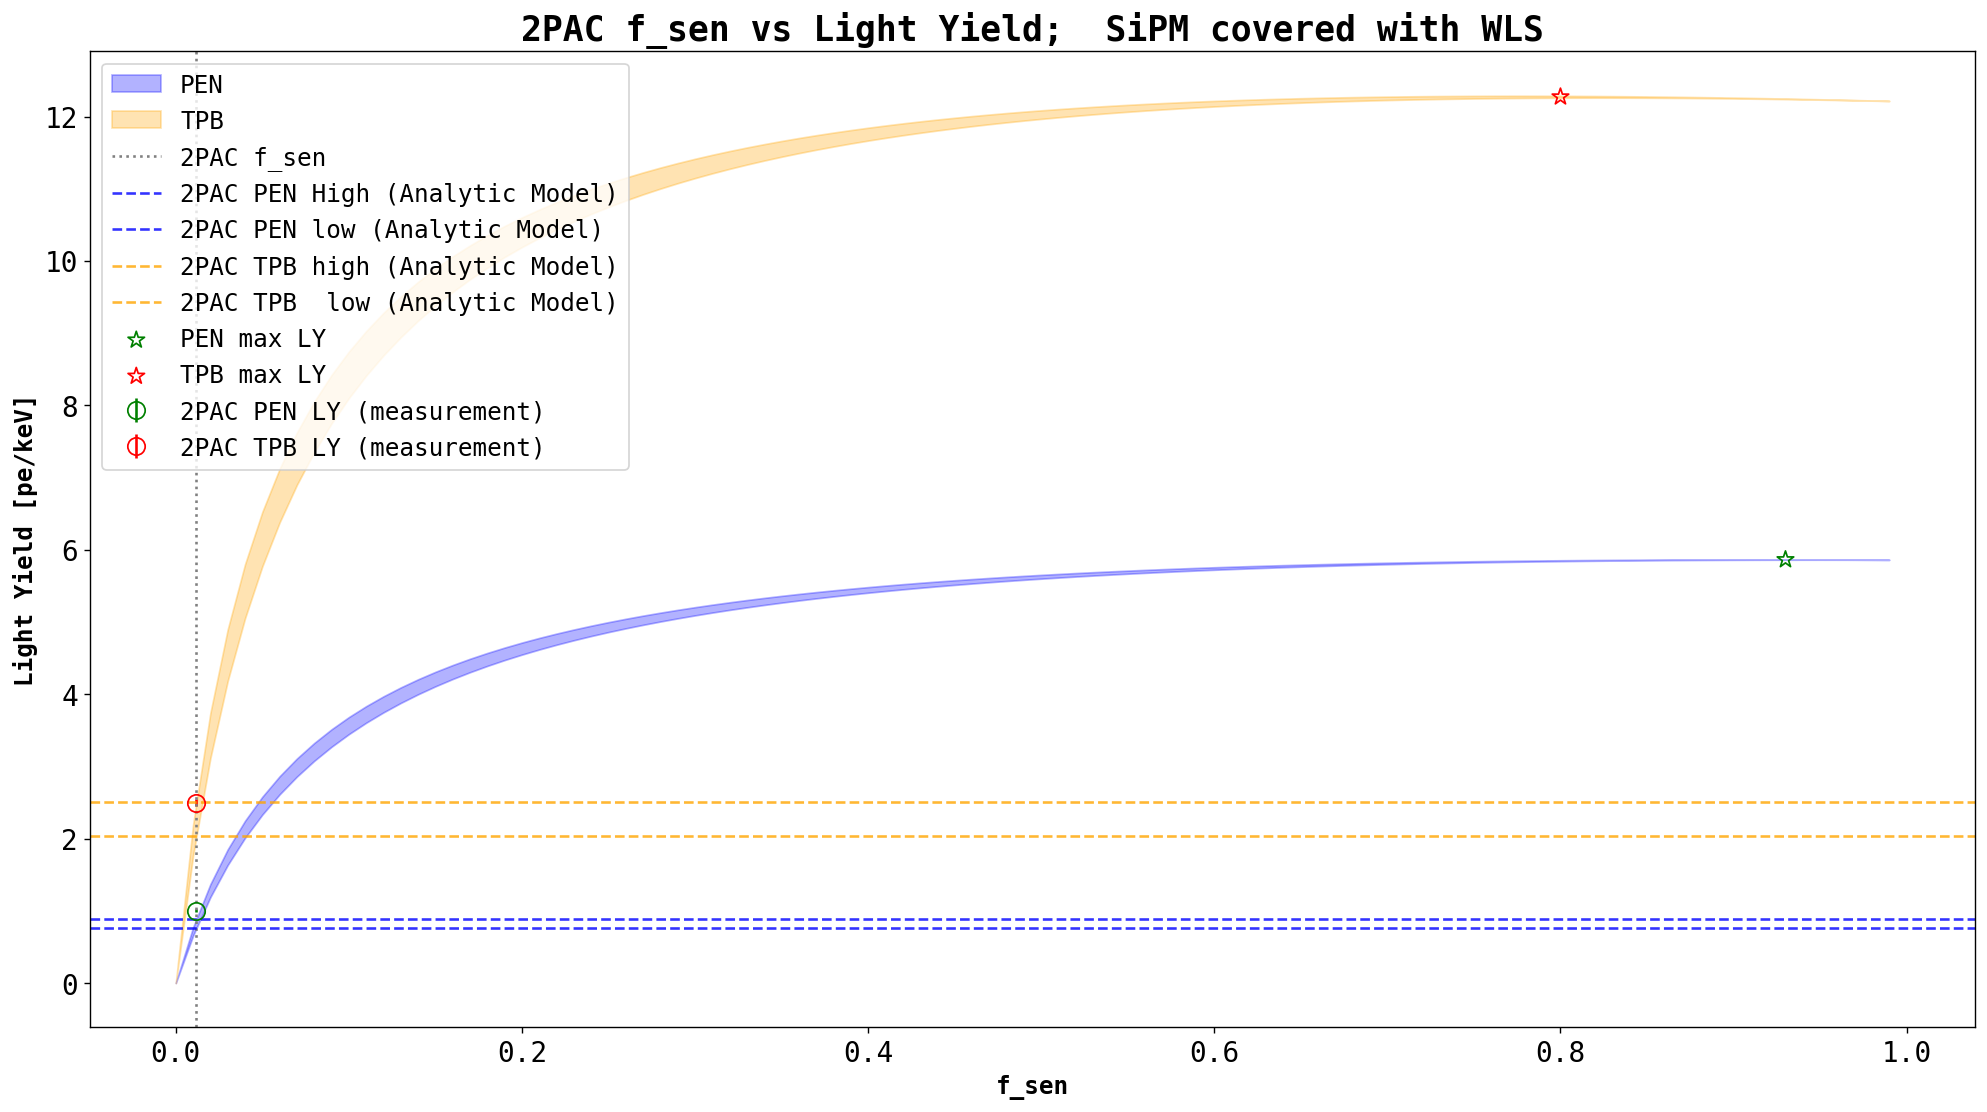

In [27]:
# F_sen value estimated for 2PAC
# f_sen_2PAC =  0.01176 

# %matplotlib qt
# %matplotlib inline

plt.close('2PAC f_sen vs LY')
plt.figure('2PAC f_sen vs LY')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector,wls_eff = 0.47, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-g')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-r')
# f_sen_vector = np.arange(0, 0.05, 0.01)
f_sen_vector = np.arange(0, 1, 0.01)
LY_PEN_upper = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC, SiPM_covered =True)
LY_PEN_lower = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC, SiPM_covered =True)
plt.fill_between( f_sen_vector, LY_PEN_lower,  LY_PEN_upper, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC, SiPM_covered =True)
LY_TPB_lower = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC, SiPM_covered =True)
plt.fill_between( f_sen_vector, LY_TPB_lower,  LY_TPB_upper, color='orange', alpha=0.3, label='TPB' )

### measurement values
plt.errorbar([0.01176], [2.50*0.40], yerr = [0.05*0.40], fmt ='o', markersize = 10, color ='green', mfc = 'none', label = '2PAC PEN LY (measurement) ')
plt.errorbar([0.01176], [2.50], yerr = [0.05], fmt = 'o', markersize =10, color ='red', mfc = 'none', label = '2PAC TPB LY (measurement) ')

### horizontal lines correspond to the LY expected from 2PAC according to the Analytic Model
### ??? change f_sens from 0.01176 to 0.01

LY_PEN_2PAC_ref_high = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_2PAC, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC, SiPM_covered =True)
LY_PEN_2PAC_ref_low = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_2PAC, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC, SiPM_covered =True)

LY_TPB_2PAC_ref_high = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_2PAC, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC, SiPM_covered =True)
LY_TPB_2PAC_ref_low = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_2PAC, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC, SiPM_covered =True)

plt.axvline(f_sen_2PAC, 0, 1, linestyle = 'dotted', color = 'gray', label='2PAC f_sen')

plt.axhline(LY_PEN_2PAC_ref_high, 0, 1, linestyle = '--', color = 'blue', alpha =0.8, label='2PAC PEN High (Analytic Model)')
plt.axhline(LY_PEN_2PAC_ref_low, 0, 1, linestyle = '--', color = 'blue', alpha =0.8, label='2PAC PEN low (Analytic Model)')
plt.axhline(LY_TPB_2PAC_ref_high, 0, 1, linestyle = '--', color = 'orange', alpha =0.8, label='2PAC TPB high (Analytic Model)')
plt.axhline(LY_TPB_2PAC_ref_low, 0, 1, linestyle = '--', color = 'orange', alpha =0.8, label='2PAC TPB  low (Analytic Model)')

### Maximum LY points
LY_PEN_average = (LY_PEN_upper + LY_PEN_lower)/2
LY_TPB_average = (LY_TPB_upper + LY_TPB_lower)/2

plt.scatter( f_sen_vector[np.argmax(LY_PEN_average)], LY_PEN_average[np.argmax(LY_PEN_average)], marker = '*', s =100, facecolors = 'none', edgecolors = 'g', label = 'PEN max LY')
plt.scatter( f_sen_vector[np.argmax(LY_TPB_average)], LY_TPB_average[np.argmax(LY_TPB_average)], marker = '*', s =100, facecolors = 'none', edgecolors ='r', label = 'TPB max LY')

plt.ylabel('Light Yield [pe/keV]' , size =14, weight = 'bold')
plt.xlabel('f_sen', size =14, weight = 'bold')
plt.title('2PAC f_sen vs Light Yield;  SiPM covered with WLS')
### [R_SiPM, R_wall,PDE dependent on wavelength. Absorption and Rayleigh Scattering accounted for]
# plt.legend(loc = 'best')
plt.legend(loc = 'upper left')
# plt.savefig('f_sen vs LY')

In [28]:
LY_TPB_average = (LY_TPB_upper + LY_TPB_lower)/2

f_sen_vector[np.argmax(LY_TPB_average)] ### at this value we'll obtain the maximum light yield

0.8

In [29]:
LY_PEN_average = (LY_PEN_upper + LY_PEN_lower)/2

f_sen_vector[np.argmax(LY_PEN_average)] ### at this value we'll obtain the maximum light yield

0.93

<h2 style = 'color:orange'> DarkSide-20k Neutron veto </h2>
<p style = 'color:skyblue'> in case of DarkSide veto we no longer have the symmetry. First the shape is not a cylinder; it has spherical caps on each end. The TPC inside the titanium vessel works like a cavity with additional surface area. We have to come with a technique to account for these differences. </p>

In [30]:
### volume needed to contain 20,000 Kg of liquid Argon
### Desnity of liquid Argon is 	1395.4 Kg/ m^3

print('volume of LAr that would weigh 20 ton:', 20000/1395.4, 'm^3')

volume of LAr that would weigh 20 ton: 14.33280779704744 m^3


<span style = 'color:violet; font-size:14pt'> Titanium Vessel </span>
<span style = 'color : lime; font-size: 14pt;'>
    $$
    \text{volume of titanium vessel} = \pi R^2 H + 2 \times \frac{1}{6} \pi h(3a^2+h^2)
    $$
    <br>
    $$
    \text{internal surface area of titanium vessel} = 2 \pi R H + 2 \times \pi (a^2 + h^2)
    $$
</span>
<br>

In [31]:
### we will calculate the surface area and volume of titanium using above formulas
### Note : radius of cylinder =  radius of spherical cap, lets call it vessel radius 
### Radius of cap is not same as the radius of sphere from which it was cut.
### Link: https://en.wikipedia.org/wiki/Spherical_cap

def calc_Ti_vessel_volume(R, H, a, h):
    ''' R and H are the radius and height of the cylinder.
    a and h are the radius and height of the spherical cap. '''

    return np.pi*(R**2)*H + 2*(1/6)*np.pi*h*(3*(a**2) + h**2)

def calc_Ti_vessel_surface_area(R, H, a, h):

    return 2*np.pi*R*H + 2*np.pi*(a**2+h**2)

### values given by Marcin
# vessel_volume = 80;

### values given by Shawn
cylinder_height = 3.572;
cap_height = 0.91688;
vessel_radius = 2.335;

# vessel_surface_area = 91.9;

vessel_surface_area = calc_Ti_vessel_surface_area(R=vessel_radius, H= cylinder_height, a= vessel_radius, h=cap_height)

vessel_volume = calc_Ti_vessel_volume(R=vessel_radius, H= cylinder_height, a=vessel_radius, h=cap_height)

print('vessel_surface_area :', vessel_surface_area, '\n', 'vessel_volume :', vessel_volume)

vessel_surface_area : 91.94507974502982 
 vessel_volume : 77.69571626786087


<span style = 'color:violet; font-size:14pt'> TPC : octagonal prism  </span>
<span style = 'color : lime; font-size:14pt'>
    $$
    \text{Surface area of a regular octagonal prism} = 8 \times a \times h
    $$
    <br>
    $$
    \text{Volume of a regular octagonal prism} = 2 \times (1 + \sqrt{2}) \times a^2 \times h
    $$
</span>
<br>

In [32]:
TPC_height = (348+30)/100;
TPC_parallel_distance = (350 +30)/100;
TPC_side = TPC_parallel_distance/abs(np.tan( np.radians(135/2) ));
TPC_surface_area = 8*TPC_side*TPC_height;
TPC_volume = 2*(1+2**0.5)*TPC_side**2*TPC_height;
print('TPC_side: ', TPC_side, '\n','TPC_surface_area:', TPC_surface_area, '\n', 'TPC_volume:', TPC_volume)

TPC_side:  1.5740115370177612 
 TPC_surface_area: 47.5981088794171 
 TPC_volume: 45.21820343544624


In [33]:
effective_DS_neutron_veto_volume = vessel_volume - TPC_volume;
effective_DS_neutron_veto_surface_area = vessel_surface_area + TPC_surface_area;
print('effective_DS_neutron_veto_surface_area:', effective_DS_neutron_veto_surface_area, '\n',
      'effective_DS_neutron_veto_volume:', effective_DS_neutron_veto_volume)

effective_DS_neutron_veto_surface_area: 139.5431886244469 
 effective_DS_neutron_veto_volume: 32.47751283241463


In [34]:
L_char_DS_Neutron_veto = calc_char_length(volume= effective_DS_neutron_veto_volume, area= effective_DS_neutron_veto_surface_area)
# ds_veto_char_length = calc_char_length(volume= effective_veto_volume, area= effective_veto_surface_area)
print( 'Char_length_neutron_veto : ', L_char_DS_Neutron_veto)

Char_length_neutron_veto :  1.3964499372228685


In [35]:
### calculating Q for Argon filled DarkSide Veto
L_char_DS_Neutron_veto
Q_vis_DS_neutron_veto = calc_Q( L_char_DS_Neutron_veto, lambda_abs= 100, lambda_R= 300)
Q_vuv_DS_neutron_veto = calc_Q( L_char_DS_Neutron_veto, lambda_abs= 17, lambda_R= 0.97)

print('Q_vuv_DS_neutron_veto: ',  Q_vuv_DS_neutron_veto, '\n', 'Q_vis_DS_neutron_veto :', Q_vis_DS_neutron_veto)

Q_vuv_DS_neutron_veto:  1.0511080712694048 
 Q_vis_DS_neutron_veto : 1.0070039170323342


<h3 style = 'color: yellow;'> DarkSide Neutron veto SiPM not covered </h3>

Text(0.5, 1.0, 'DarkSide Neutron veto; SiPM not covered')

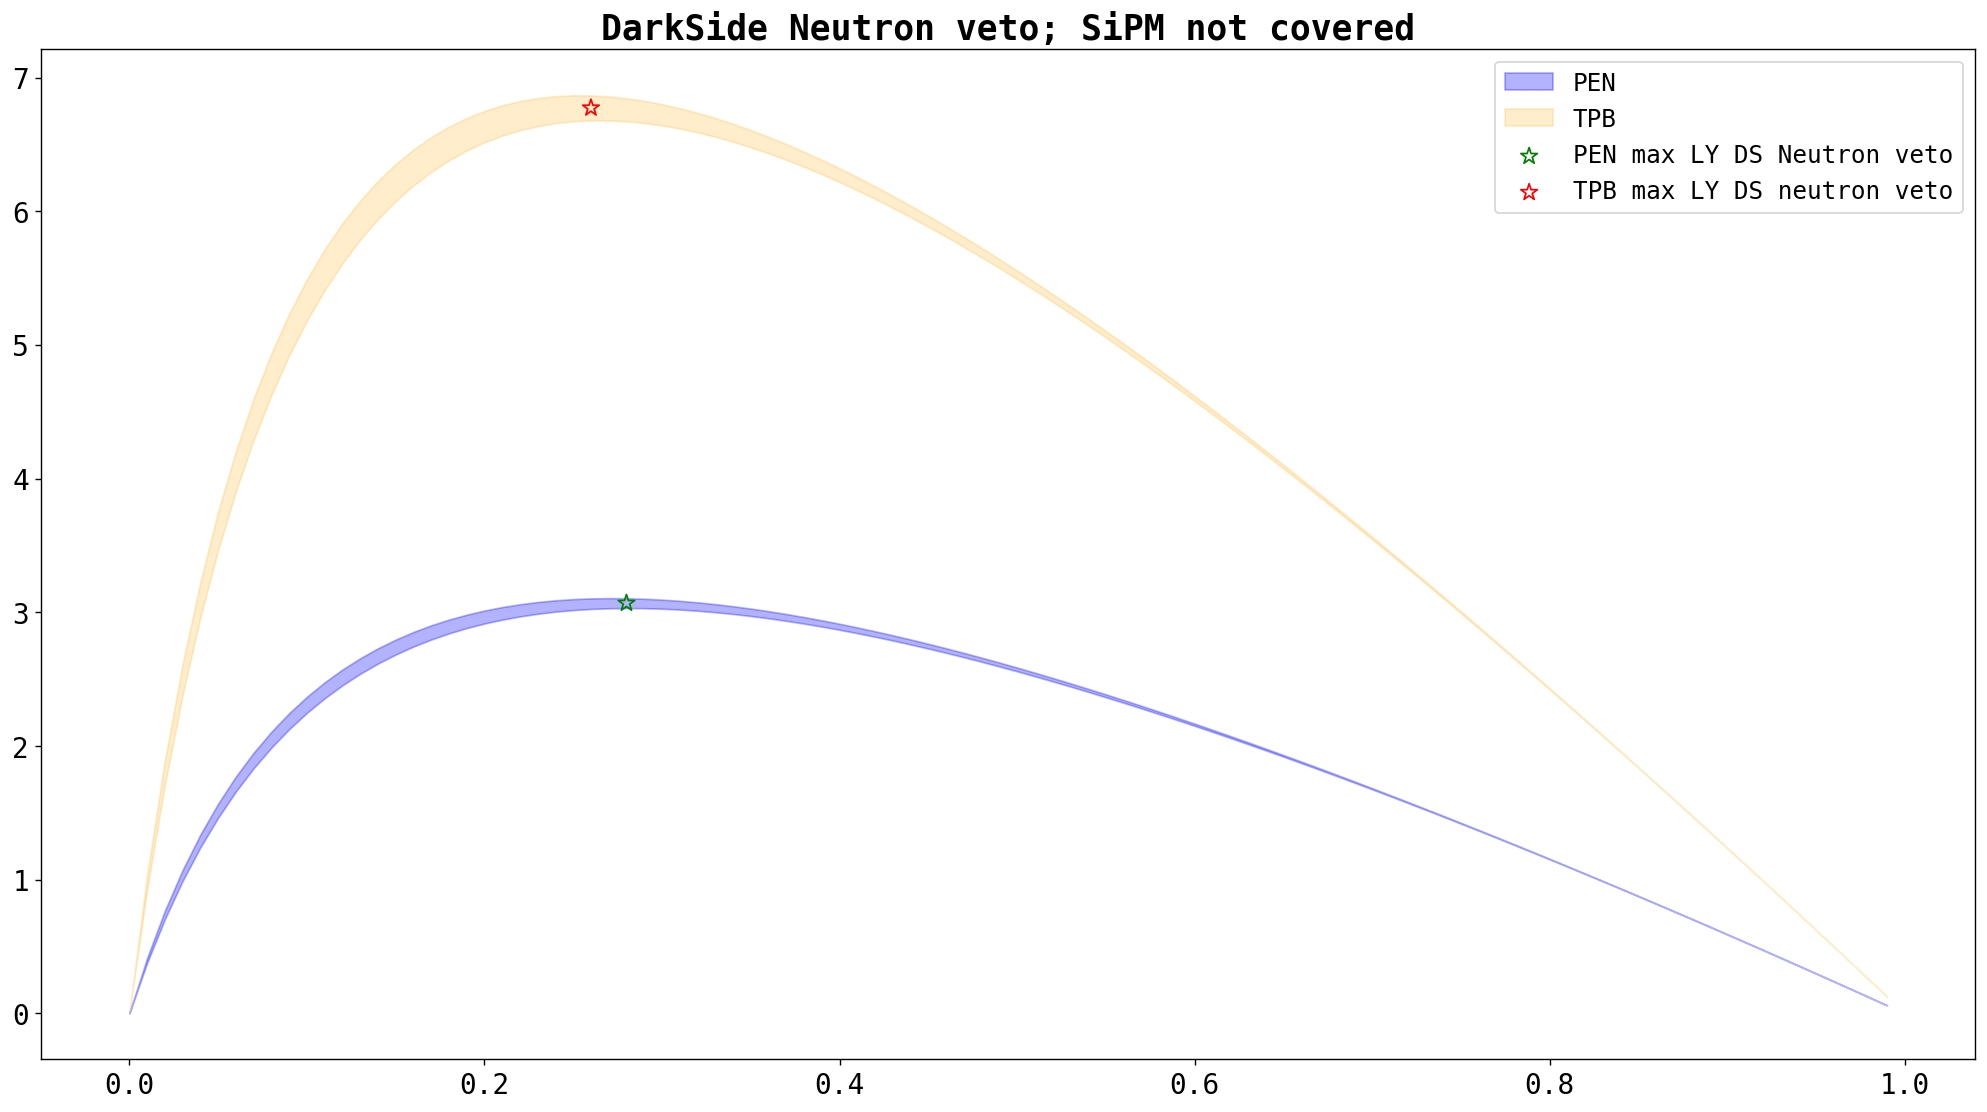

In [36]:
### DarkSide Neutron veto SiPM not covered
plt.close('DarkSide Neutron f_sen vs LY; SiPM not covered')
plt.figure('DarkSide Neutron f_sen vs LY; SiPM not covered')

LY_PEN_upper_DS_neutron_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth,
                                            f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_DS_neutron_veto, Q_vuv= Q_vuv_DS_neutron_veto)
LY_PEN_lower_DS_neutron_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988,
                                            f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_DS_neutron_veto, Q_vuv= Q_vuv_DS_neutron_veto)
plt.fill_between( f_sen_vector, LY_PEN_lower_DS_neutron_veto,  LY_PEN_upper_DS_neutron_veto, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper_DS_neutron_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                            f_sen_vector, wls_eff=1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto)
LY_TPB_lower_DS_neutron_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988,
                                            f_sen_vector, wls_eff=1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto)
plt.fill_between( f_sen_vector, LY_TPB_lower_DS_neutron_veto,  LY_TPB_upper_DS_neutron_veto, color='orange', alpha=0.2, label='TPB' )

### Maximum LY points
LY_PEN_average_DS_neutron_veto = (LY_PEN_upper_DS_neutron_veto + LY_PEN_lower_DS_neutron_veto)/2;
LY_TPB_average_DS_neutron_veto = (LY_TPB_upper_DS_neutron_veto + LY_TPB_lower_DS_neutron_veto)/2;

plt.scatter( f_sen_vector[np.argmax(LY_PEN_average_DS_neutron_veto)], LY_PEN_average_DS_neutron_veto[np.argmax(LY_PEN_average_DS_neutron_veto)],
            marker = '*', s =100, facecolors = 'none', edgecolors = 'g', label = 'PEN max LY DS Neutron veto')
plt.scatter( f_sen_vector[np.argmax(LY_TPB_average_DS_neutron_veto)], LY_TPB_average_DS_neutron_veto[np.argmax(LY_TPB_average_DS_neutron_veto)],
            marker = '*', s =100, facecolors = 'none', edgecolors ='r', label = 'TPB max LY DS neutron veto')
plt.legend()
plt.title('DarkSide Neutron veto; SiPM not covered')

<h3 style = 'color: yellow'> DarkSide Neutron veto SiPM covered with WLS </h3>

Text(0.5, 1.0, 'DarkSide Neutron veto; SiPM covered')

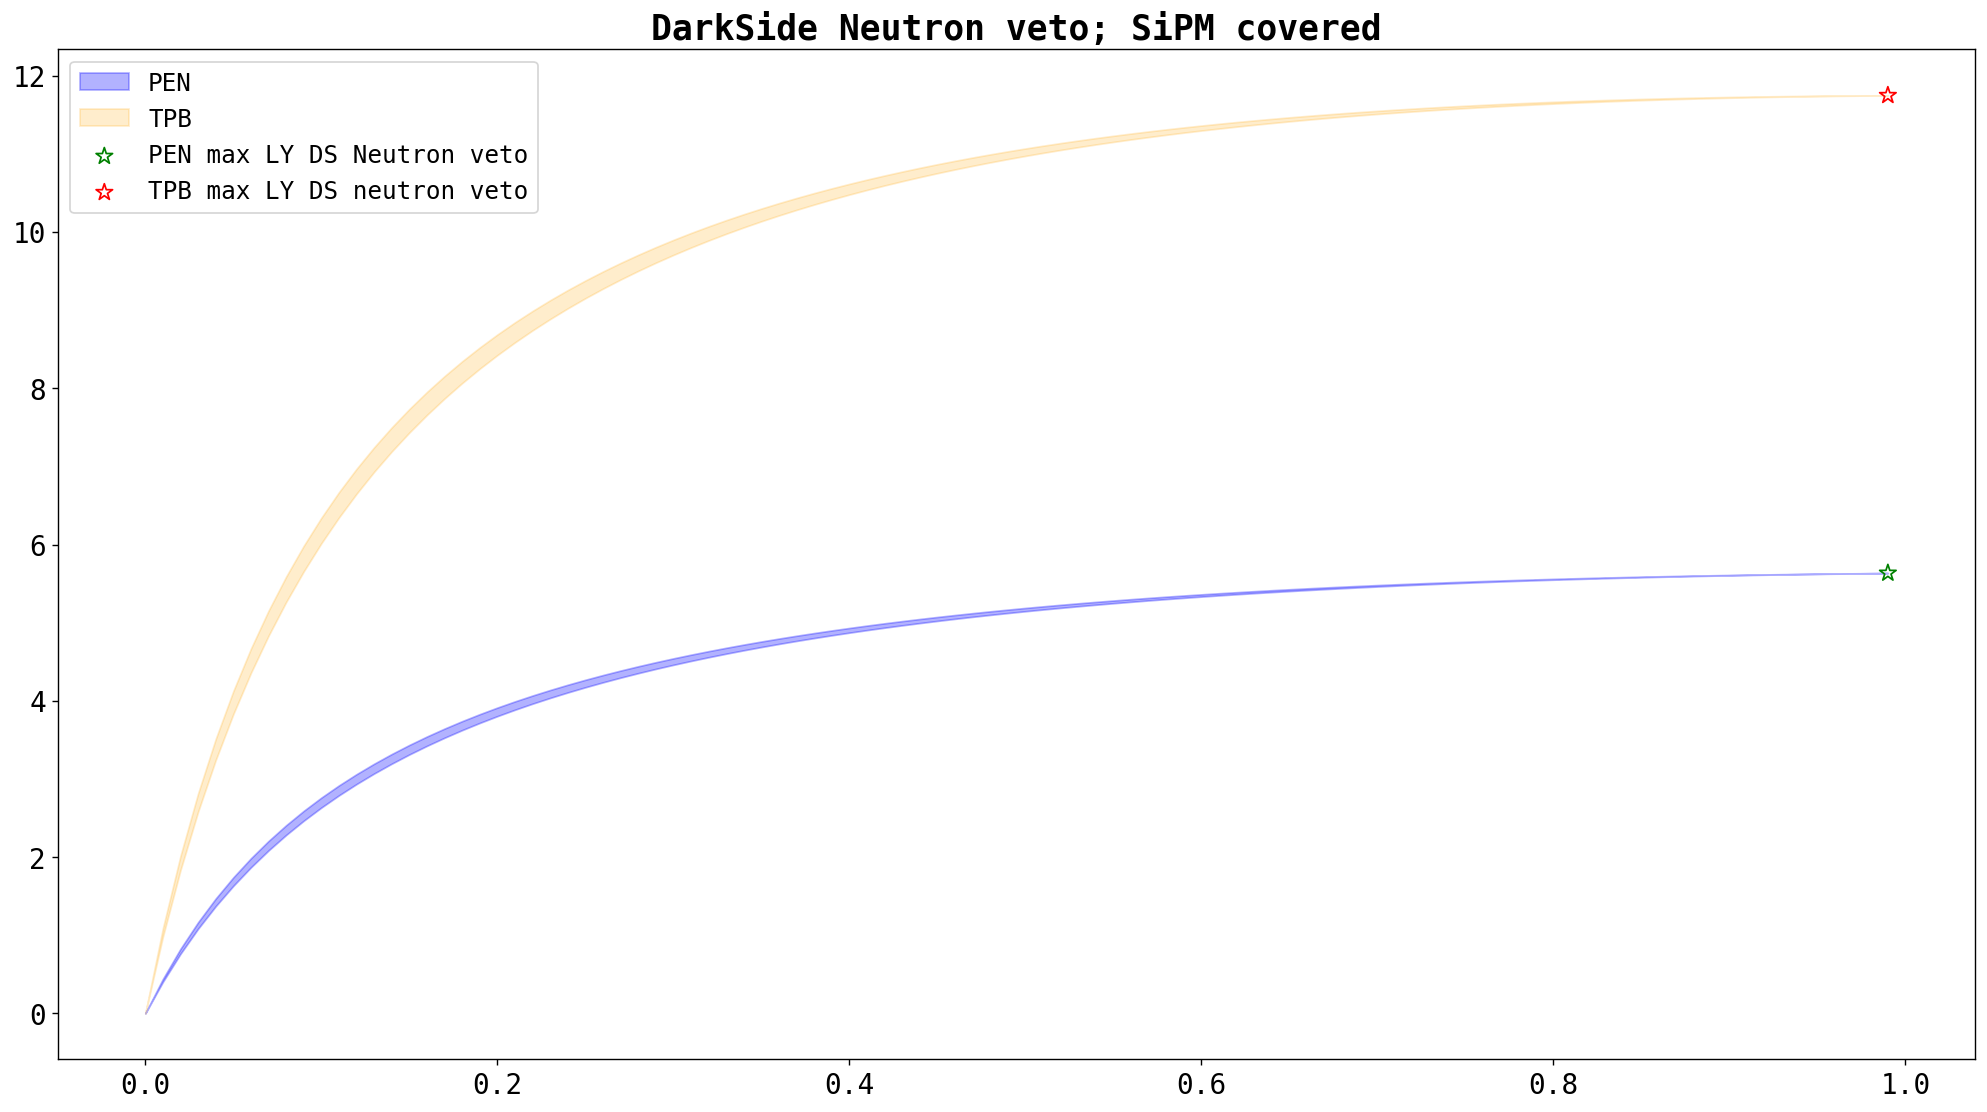

In [37]:
### DarkSide neutron veto SiPM covered with WLS
# %matplotlib qt
plt.close('DarkSide Neutron f_sen vs LY; SiPM not covered')
plt.figure('DarkSide Neutron f_sen vs LY; SiPM not covered')

LY_PEN_upper_DS_neutron_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth,
                                            f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_DS_neutron_veto, Q_vuv= Q_vuv_DS_neutron_veto, SiPM_covered=True)
LY_PEN_lower_DS_neutron_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988,
                                            f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_DS_neutron_veto, Q_vuv= Q_vuv_DS_neutron_veto, SiPM_covered=True)
plt.fill_between( f_sen_vector, LY_PEN_lower_DS_neutron_veto,  LY_PEN_upper_DS_neutron_veto, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper_DS_neutron_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                            f_sen_vector, wls_eff=1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto, SiPM_covered=True)
LY_TPB_lower_DS_neutron_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988,
                                            f_sen_vector, wls_eff=1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto, SiPM_covered=True)
plt.fill_between( f_sen_vector, LY_TPB_lower_DS_neutron_veto,  LY_TPB_upper_DS_neutron_veto, color='orange', alpha=0.2, label='TPB' )

### Maximum LY points
LY_PEN_average_DS_neutron_veto = (LY_PEN_upper_DS_neutron_veto + LY_PEN_lower_DS_neutron_veto)/2;
LY_TPB_average_DS_neutron_veto = (LY_TPB_upper_DS_neutron_veto + LY_TPB_lower_DS_neutron_veto)/2;

plt.scatter( f_sen_vector[np.argmax(LY_PEN_average_DS_neutron_veto)], LY_PEN_average_DS_neutron_veto[np.argmax(LY_PEN_average_DS_neutron_veto)],
            marker = '*', s =100, facecolors = 'none', edgecolors = 'g', label = 'PEN max LY DS Neutron veto')
plt.scatter( f_sen_vector[np.argmax(LY_TPB_average_DS_neutron_veto)], LY_TPB_average_DS_neutron_veto[np.argmax(LY_TPB_average_DS_neutron_veto)],
            marker = '*', s =100, facecolors = 'none', edgecolors ='r', label = 'TPB max LY DS neutron veto')
plt.legend()
plt.title('DarkSide Neutron veto; SiPM covered')

<p> 
    <span style = 'color: red; font-size:14pt'> Warning!! </span>
    <span style = 'color: skyblue; font-size: 14pt;'> The Analytic Model can not be directly used for either Darkside muon or neutron veto as the model has inherent assumptions. These plots are only indicative and should be interpreted carefully.
        Few things to keep in mind while interpreting these plots: </span>
        <ol>
            <li> Currently Analytic Model, i.e, AMLY_V2 is not capable of handling Geometries with 'cavaties' such as Muon veto and Neutron veto. </li>
            <li> Analytic Model assumes SiPM's and WLS cover entire surface area. Whatever small patches can not be covered with WLS are included in effective reflectance of WLS. The point if if large portion of area are kept uncovered and we continue to use measured reflectance we may no longer be able to factor in the unovered area.</li>
        </ol> 
</p>

<h2 style = 'color:orange;'> DarkSide-20k Muon veto </h2>

In [38]:
cryostat_volume = 7.9*8.548*8.548
cryostat_surface_area = 2*(7.9*8.548 + 8.548*8.548 + 8.548*7.9)

effective_DS_muon_veto_volume = cryostat_volume - vessel_volume
effective_DS_muon_veto_surface_area = cryostat_surface_area + vessel_surface_area

In [39]:
L_char_DS_muon_veto = calc_char_length(effective_DS_muon_veto_surface_area, effective_DS_muon_veto_volume)

In [40]:
Q_vis_DS_muon_veto = calc_Q(L_char_DS_muon_veto, lambda_abs= 100, lambda_R= 300)
Q_vuv_DS_muon_veto = calc_Q(L_char_DS_muon_veto, lambda_abs= 17, lambda_R= 0.97)

<h3 style = 'color: yellow;'> DarkSide Muon veto; SiPM not covered </h3>

Text(0.5, 1.0, 'DarkSide-20k neutron veto; SiPM not covered')

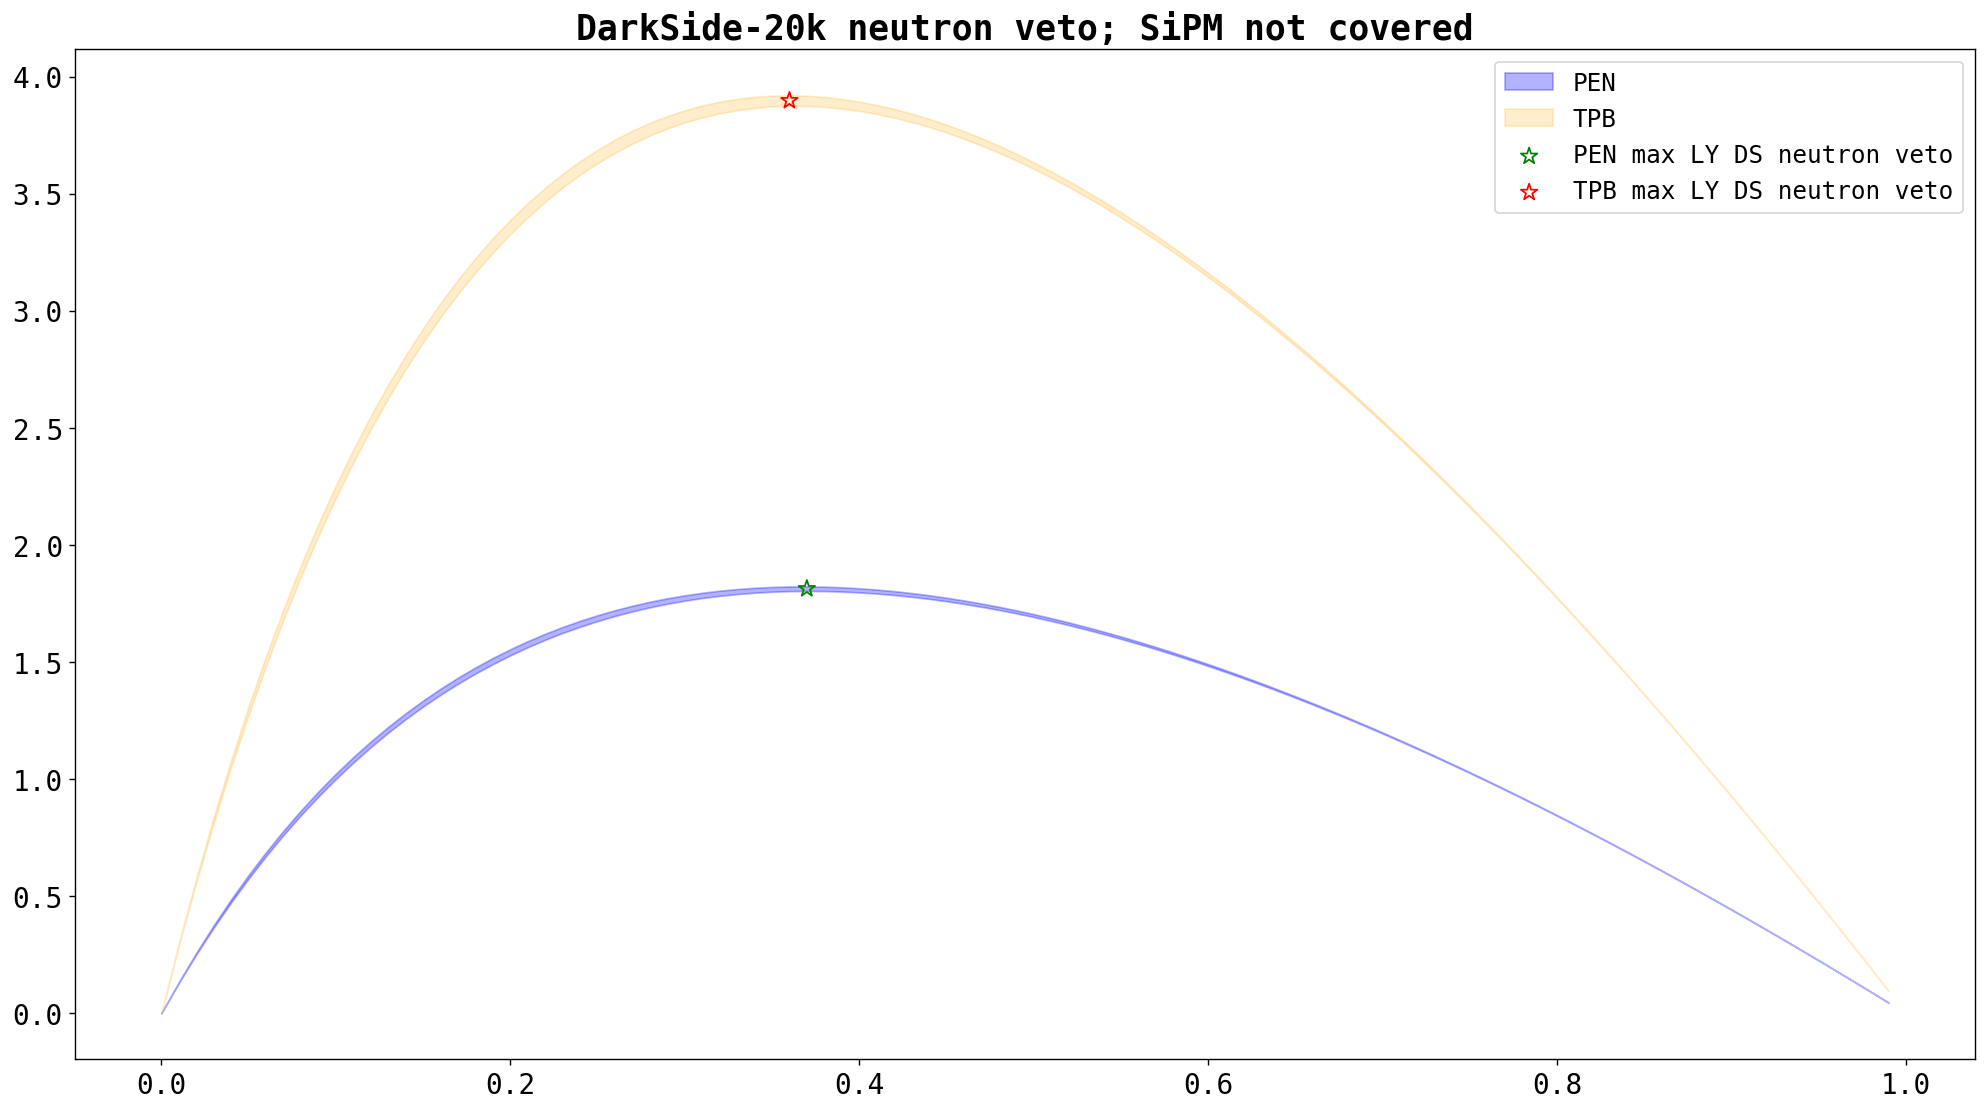

In [41]:
### DarkSide muon veto SiPM not covered
plt.close('DarkSide muon Veto f_sen vs LY SiPM not covered')
plt.figure('DarkSide muon Veto f_sen vs LY SiPM not covered')

LY_PEN_upper_DS_muon_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47,
                                            Q_vis=Q_vis_DS_muon_veto, Q_vuv= Q_vuv_DS_muon_veto)
LY_PEN_lower_DS_muon_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47,
                                            Q_vis=Q_vis_DS_muon_veto, Q_vuv= Q_vuv_DS_muon_veto)
plt.fill_between(f_sen_vector, LY_PEN_lower_DS_muon_veto,  LY_PEN_upper_DS_muon_veto, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper_DS_muon_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, wls_eff=1,
                                            Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto)
LY_TPB_lower_DS_muon_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, wls_eff=1,
                                            Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto)
plt.fill_between(f_sen_vector, LY_TPB_lower_DS_muon_veto,  LY_TPB_upper_DS_muon_veto, color='orange', alpha=0.2, label='TPB' )

### Maximum LY points
LY_PEN_average_DS_muon_veto = (LY_PEN_upper_DS_muon_veto + LY_PEN_lower_DS_muon_veto)/2;
LY_TPB_average_DS_muon_veto = (LY_TPB_upper_DS_muon_veto + LY_TPB_lower_DS_muon_veto)/2;

plt.scatter(f_sen_vector[np.argmax(LY_PEN_average_DS_muon_veto)], LY_PEN_average_DS_muon_veto[np.argmax(LY_PEN_average_DS_muon_veto)],
            marker = '*', s =100, facecolors = 'none', edgecolors = 'g', label = 'PEN max LY DS neutron veto')
plt.scatter(f_sen_vector[np.argmax(LY_TPB_average_DS_muon_veto)], LY_TPB_average_DS_muon_veto[np.argmax(LY_TPB_average_DS_muon_veto)],
            marker = '*', s =100, facecolors = 'none', edgecolors ='r', label = 'TPB max LY DS neutron veto')
plt.legend()
plt.title('DarkSide-20k neutron veto; SiPM not covered')

<h3 style = 'color: yellow'> DarkSide Muon veto; SiPM covered with WLS </h3>

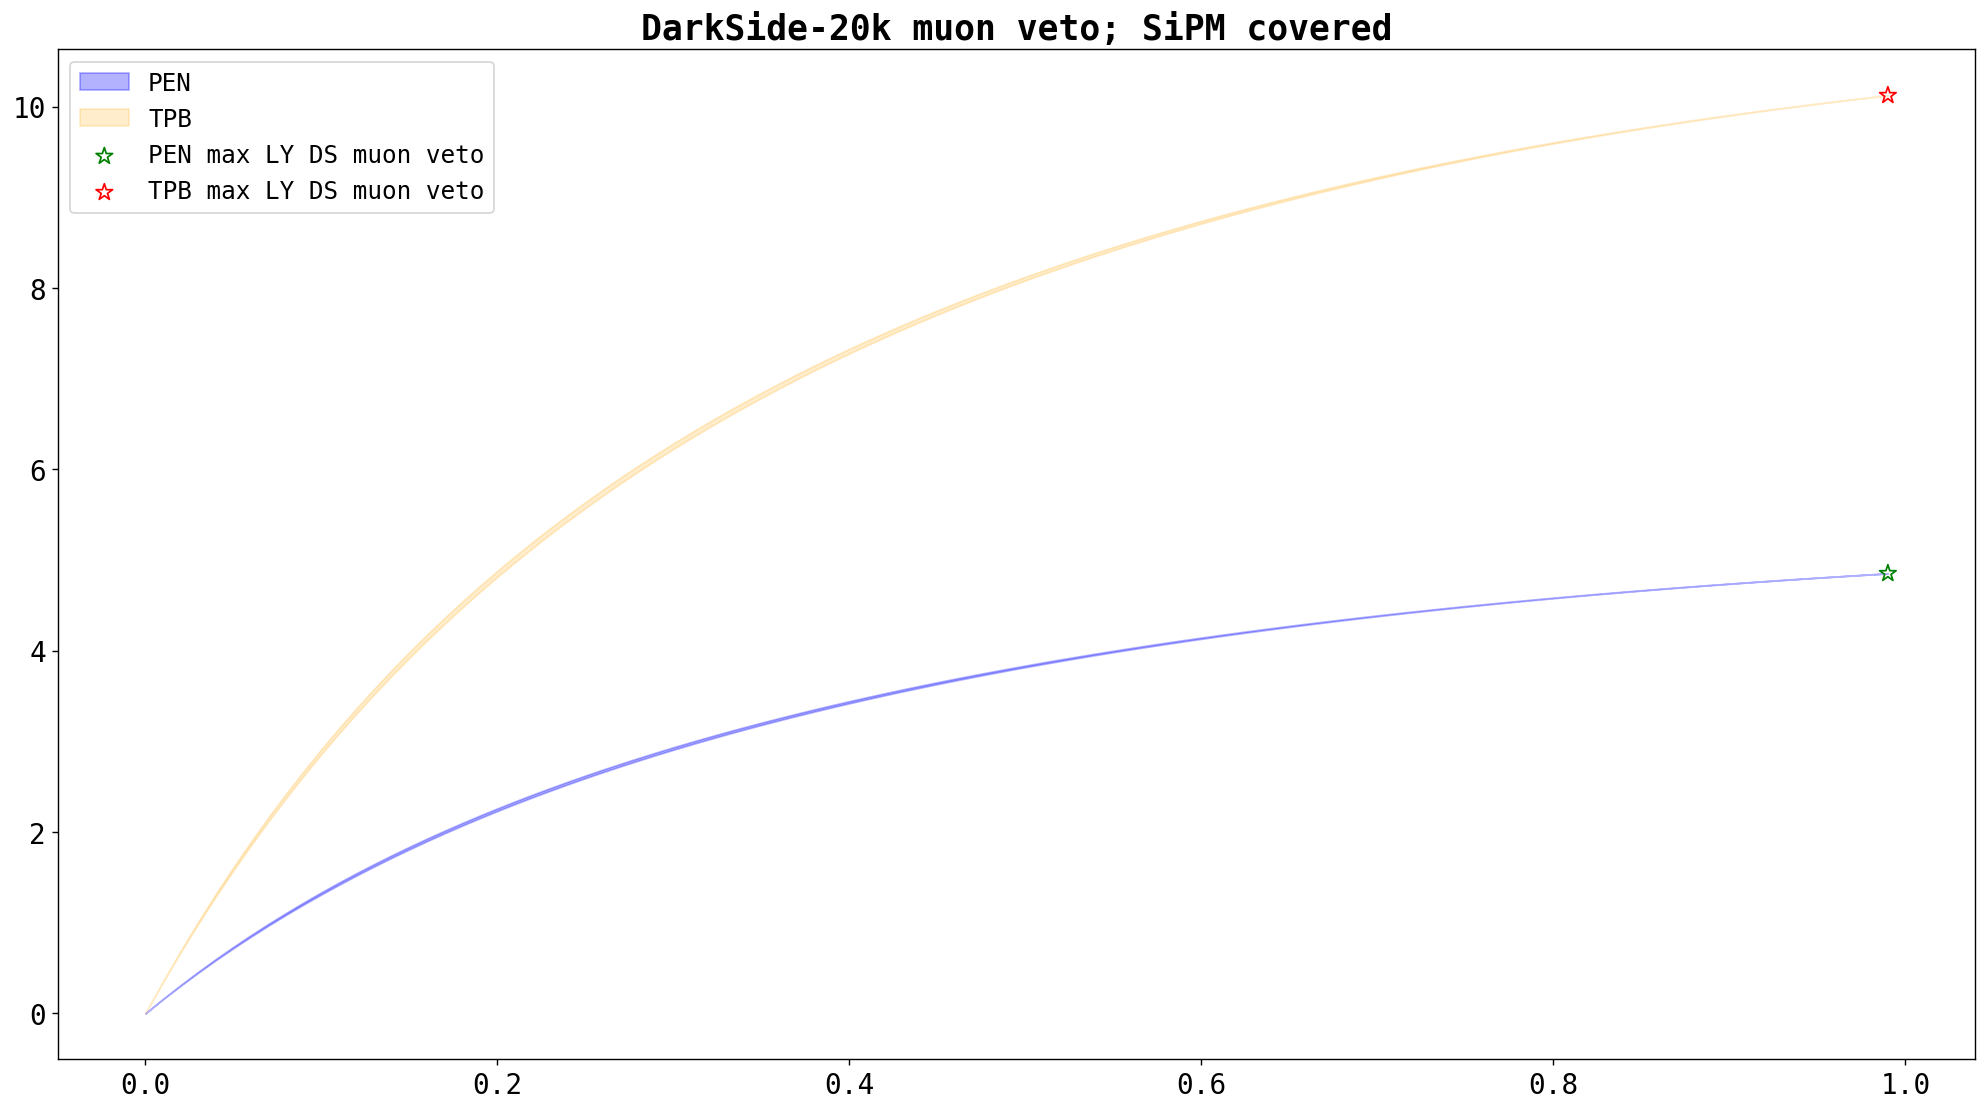

In [42]:
### DarkSide muon veto SiPM not covered
plt.close('DarkSide Muon Veto f_sen vs LY SiPM not covered')
plt.figure('DarkSide Muon Veto f_sen vs LY SiPM not covered')

LY_PEN_upper_DS_muon_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47,
                                            Q_vis=Q_vis_DS_muon_veto, Q_vuv= Q_vuv_DS_muon_veto, SiPM_covered=True)
LY_PEN_lower_DS_muon_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47,
                                            Q_vis=Q_vis_DS_muon_veto, Q_vuv= Q_vuv_DS_muon_veto, SiPM_covered=True)
plt.fill_between(f_sen_vector, LY_PEN_lower_DS_muon_veto,  LY_PEN_upper_DS_muon_veto, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper_DS_muon_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, wls_eff=1,
                                            Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto, SiPM_covered=True)
LY_TPB_lower_DS_muon_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, wls_eff=1,
                                            Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto, SiPM_covered=True)
plt.fill_between(f_sen_vector, LY_TPB_lower_DS_muon_veto,  LY_TPB_upper_DS_muon_veto, color='orange', alpha=0.2, label='TPB' )

### Maximum LY points
LY_PEN_average_DS_muon_veto = (LY_PEN_upper_DS_muon_veto + LY_PEN_lower_DS_muon_veto)/2;
LY_TPB_average_DS_muon_veto = (LY_TPB_upper_DS_muon_veto + LY_TPB_lower_DS_muon_veto)/2;

plt.scatter(f_sen_vector[np.argmax(LY_PEN_average_DS_muon_veto)], LY_PEN_average_DS_muon_veto[np.argmax(LY_PEN_average_DS_muon_veto)],
            marker = '*', s =100, facecolors = 'none', edgecolors = 'g', label = 'PEN max LY DS muon veto')
plt.scatter(f_sen_vector[np.argmax(LY_TPB_average_DS_muon_veto)], LY_TPB_average_DS_muon_veto[np.argmax(LY_TPB_average_DS_muon_veto)],
            marker = '*', s =100, facecolors = 'none', edgecolors ='r', label = 'TPB max LY DS muon veto')
plt.legend()
plt.title('DarkSide-20k muon veto; SiPM covered')
plt.legend(loc = 'upper left')

<p> 
    <span style = 'color: red; font-size:14pt'> Warning!! </span>
    <span style = 'color: skyblue; font-size: 14pt;'> The two points of warning from Neutron veto apply here as well.</span>
</p>

<span style = 'color: lightgreen; font-size: 14pt;'> As per discussion with Shawn, if WLS can only be applied on the interior surface of cryostat, the maximum value of fraction of surface area available for WLS can be found in this manner: </span>
    <br>
    <span style = 'font-size: 12pt; text-align: center;'> cryostat_surface_area/effective_muon_veto_surface_area 
</span>
<br>
<span style = 'color: tomato'> verify this </span>

<h2 style= 'color: orange'> ARGO </h2>

In [43]:
### First we will calculate the characteristic length for ARGO, Characteristic length as defined in Segreto paper
area_ARGO = 2*np.pi*(7.05/2)*( 7.05/2 + 7.05)
volume_ARGO = np.pi*(7.05)*(7.05/2)**2

L_char_ARGO = calc_char_length(area_ARGO, volume_ARGO) ### unit: m

In [44]:
### calculating Q for Argon filled ARGO
Q_vis_ARGO = calc_Q(L_char_ARGO, lambda_abs= 100, lambda_R= 300)
Q_vuv_ARGO = calc_Q(L_char_ARGO, lambda_abs= 17, lambda_R= 0.97)

In [45]:
# area_ARGO,
# volume_ARGO,
# L_char_ARGO
# L_char_ARGO

In [46]:
f_sen_min = (np.pi*(7.05/2)**2)/area_ARGO
f_sen_vector = np.arange(f_sen_min,1, 0.001)
# f_sen_vector = np.arange(0,1, 0.001)
# f_sen_vector

<h3 style = 'color: yellow;'> Plots for different wall reflectances. </h3>

<p style = 'color: red'> Note : </p>
<p style = 'color: yellow;'> SiPM covered with WLS. 
    TPB wavelength shifter 
</p>

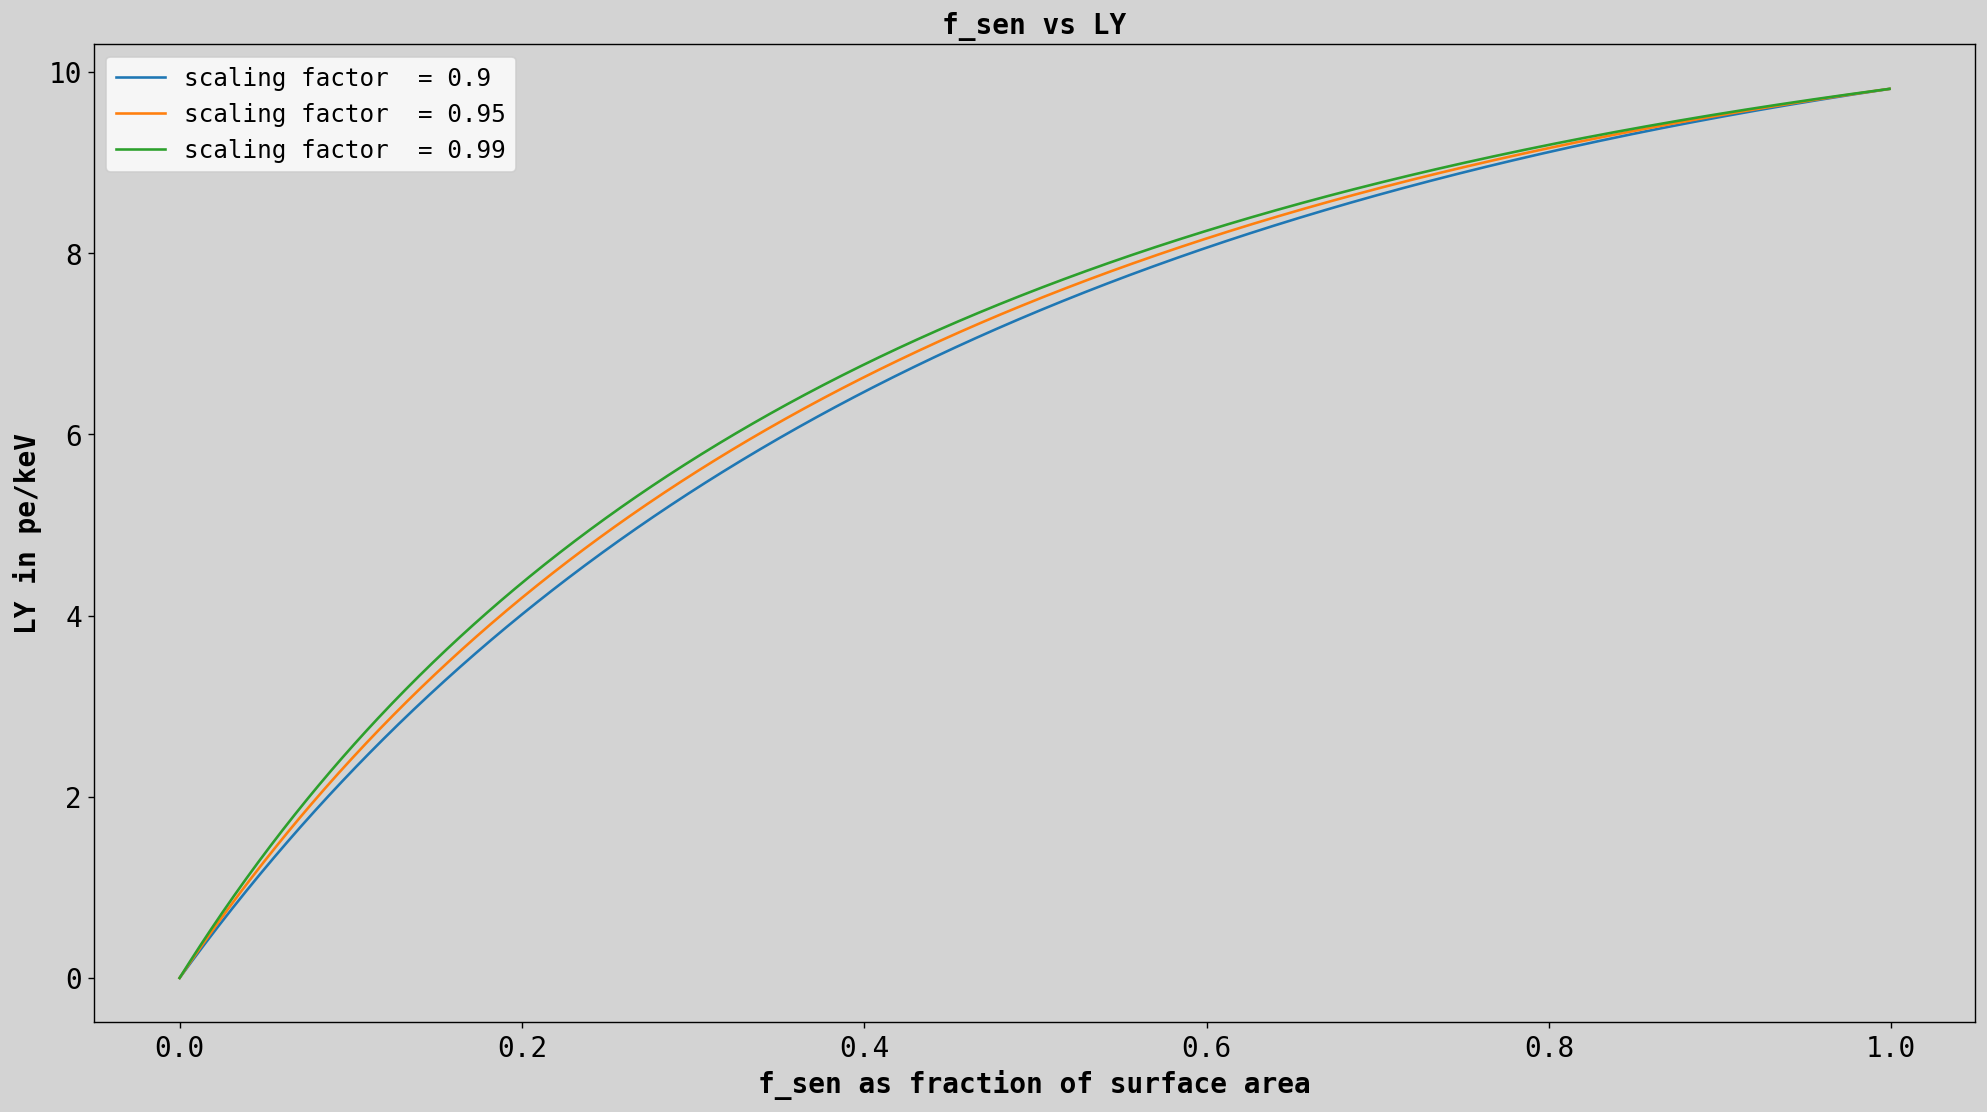

In [47]:
# %matplotlib qt
# %matplotlib inline

fig1 = plt.figure('1')
ax1 = plt.axes()
f_sen_vector = np.arange(0,1, 0.001)
for scale_factor in [0.90, 0.95, 0.99]:
    LY_TPB_upper_ARGO_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth,
                                       scale_factor*R_Wall_TPB_smooth, f_sen_vector, wls_eff= 1, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)
    ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_1, label = 'scaling factor  = ' + str(scale_factor))
    ### maximum locator
    # ax1.scatter( f_sen_vector[np.argmax(LY_TPB_upper_ARGO_1)], LY_TPB_upper_ARGO_1[np.argmax(LY_TPB_upper_ARGO_1)], marker = '*', s =100)

ax1.set_title('f_sen vs LY', size =16, weight = 'bold')
ax1.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
ax1.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# txtstr = '* represents max LY'
# ax1.text(0.15, 0.95, txtstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax1.set_yscale('linear')
ax1.legend(loc='best')
fig1.set_facecolor('lightgrey')
ax1.set_facecolor('lightgrey')
fig1.savefig(r'C:\Users\sarth\projects\LY_Analytic_Model\all_plots\fig1.png')

<h3 style = 'color: yellow;'> Plots for VUV absorption lengths 5, 10, 20, 100. </h3>

<p style = 'color: red'> Note : </p>
<p style = 'color: yellow;'> SiPM covered with WLS. 
    TPB wavelength shifter.
    TPB reflectance scaled by 0.95
</p>

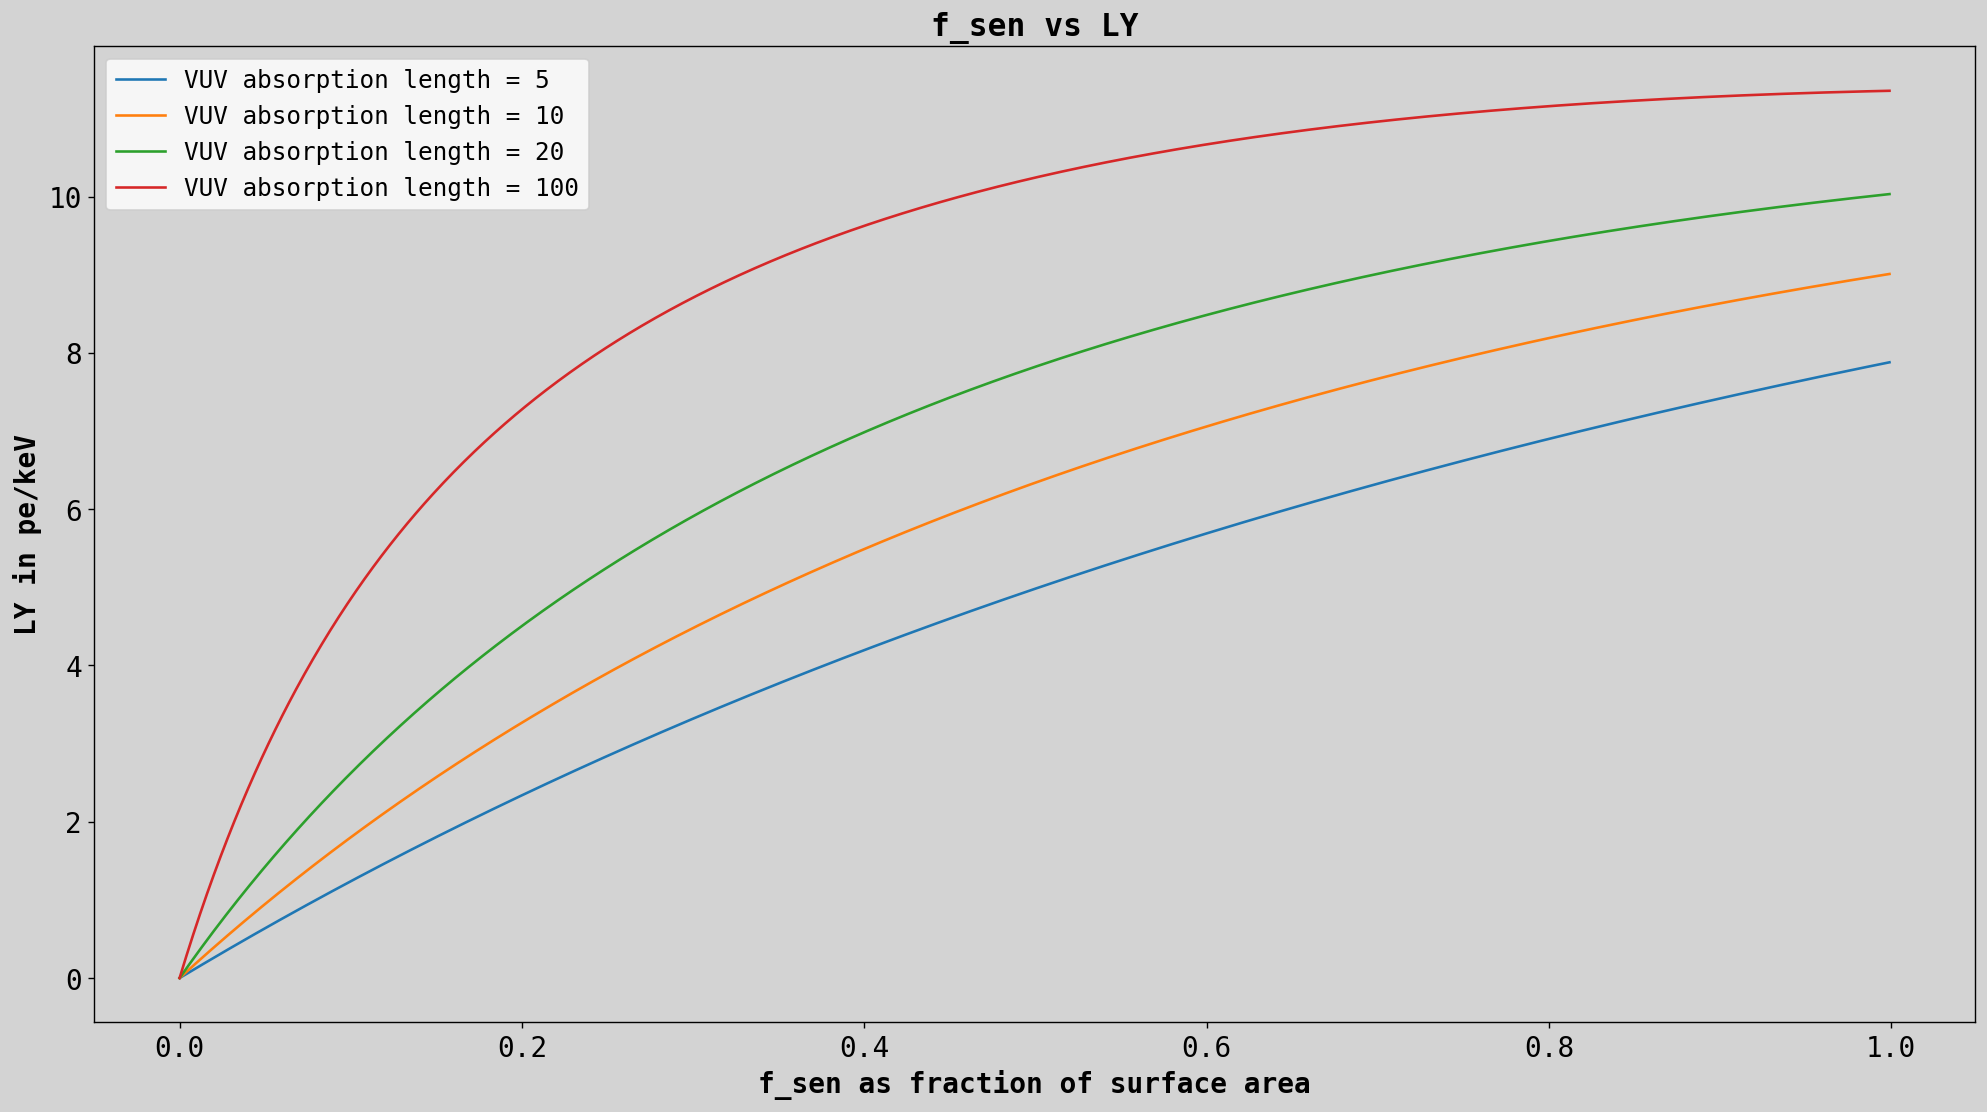

In [48]:
# %matplotlib qt
# %matplotlib inline
fig2 = plt.figure('2')
ax2 = plt.axes()
for lambda_variable in [5, 10, 20, 100]:
    Q_vuv_ARGO_variable = calc_Q(L_char_ARGO, lambda_abs=lambda_variable, lambda_R=0.97)
    LY_TPB_upper_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth,
                                       0.95*R_Wall_TPB_smooth, f_sen_vector, wls_eff= 1, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO_variable, SiPM_covered =True)
    ax2.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'VUV absorption length = ' + str(lambda_variable))

ax2.set_title('f_sen vs LY', size =18, weight = 'bold')
ax2.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
ax2.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
ax2.legend(loc ='best')
fig2.set_facecolor('lightgrey')
ax2.set_facecolor('lightgrey')
fig2.savefig(r'C:\Users\sarth\projects\LY_Analytic_Model\all_plots\fig2.png')

In [49]:
# fig1.show()

In [50]:
# fig2.show()

In [51]:
# %matplotlib inline
# ### testing for veto like configuration
# fig1 = plt.figure('3')
# ax1 = plt.axes()
# LY_TPB_upper_ARGO_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =False)

# LY_PEN_upper_ARGO_1 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =False)

# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_1, label = 'TPB')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_1, label = 'PEN')
# ### ON
# LY_TPB_upper_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# LY_PEN_upper_ARGO_2 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'TPB SiPM covered',color = 'red') #,  marker = '*')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_2, label = 'PEN SiPM covered', color = 'purple') # ,  marker = 'v')

# # ax1.set_xticks()
# ### ON

# ax1.set_title('SiPM not covered', size =16, weight = 'bold')
# ax1.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
# ax1.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
# # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# # txtstr = '* represents max LY'
# # ax1.text(0.15, 0.95, txtstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
# ax1.set_yscale('linear')
# ax1.legend(loc ='best',  prop={'size': 13})

In [52]:
# ### SiPM covered = True
# LY_TPB_upper_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# LY_PEN_upper_ARGO_2 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)
# fig6 = plt.figure()
# ax6 = plt.axes()

# ax6.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'TPB', color = 'red')
# ax6.plot(f_sen_vector, LY_PEN_upper_ARGO_2, label = 'PEN', color = 'purple')

# ### maximum locator
# # ax1.scatter( f_sen_vector[np.argmax(LY_TPB_upper_ARGO_1)], LY_TPB_upper_ARGO_1[np.argmax(LY_TPB_upper_ARGO_1)], marker = '*', s =100)

# ax6.set_title('SiPM covered', size =16, weight = 'bold')
# ax6.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
# ax6.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
# # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# # txtstr = '* represents max LY'
# # ax1.text(0.15, 0.95, txtstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
# ax6.set_yscale('linear')
# ax6.legend( loc ='best',  prop={'size': 13} )

In [53]:
# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'TPB', marker = '*')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_2, label = 'PEN', marker = 'v')

In [54]:
# Changing Q values

In [55]:
# # Something is wrong here
# # %matplotlib qt
# %matplotlib inline
# ### testing for veto like configuration
# # Q_vis_ARGO = 2 # these values are what is wrong with this cell
# # Q_vuv_ARGO = 2
# # Q_vis_ARGO = 1.0070039170323342; # values taken from Darkside muon veto
# # Q_vuv_ARGO = 1.0511080712694048
# fig1 = plt.figure('3')
# ax1 = plt.axes()

# LY_TPB_upper_ARGO_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =False)

# LY_PEN_upper_ARGO_1 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =False)

# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_1, label = 'TPB')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_1, label = 'PEN')
# ### ON
# LY_TPB_upper_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# LY_PEN_upper_ARGO_2 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'TPB SiPM covered') #, marker = '*')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_2, label = 'PEN SiPM covered') #, marker = 'v')
# ### ON

# ax1.set_title('SiPM not covered', size =16, weight = 'bold')
# ax1.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
# ax1.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
# # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# # txtstr = '* represents max LY'
# # ax1.text(0.15, 0.95, txtstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
# ax1.set_yscale('linear')
# ax1.legend(loc ='best',  prop={'size': 13})

<h1 style = 'color: #ff0038; text-align: center'> Comparison between Analytic Model Light Yields with and without absorption and Scattering</h1>
<p style='color: deeppink;'> + Comparison with Cenk's MC simulation </p>

<h2 style = 'color: Chartreuse' > comparing LY for 2PAC veto with and withOUT absorption effect. </h2>

In [56]:
from matplotlib.ticker import FormatStrFormatter

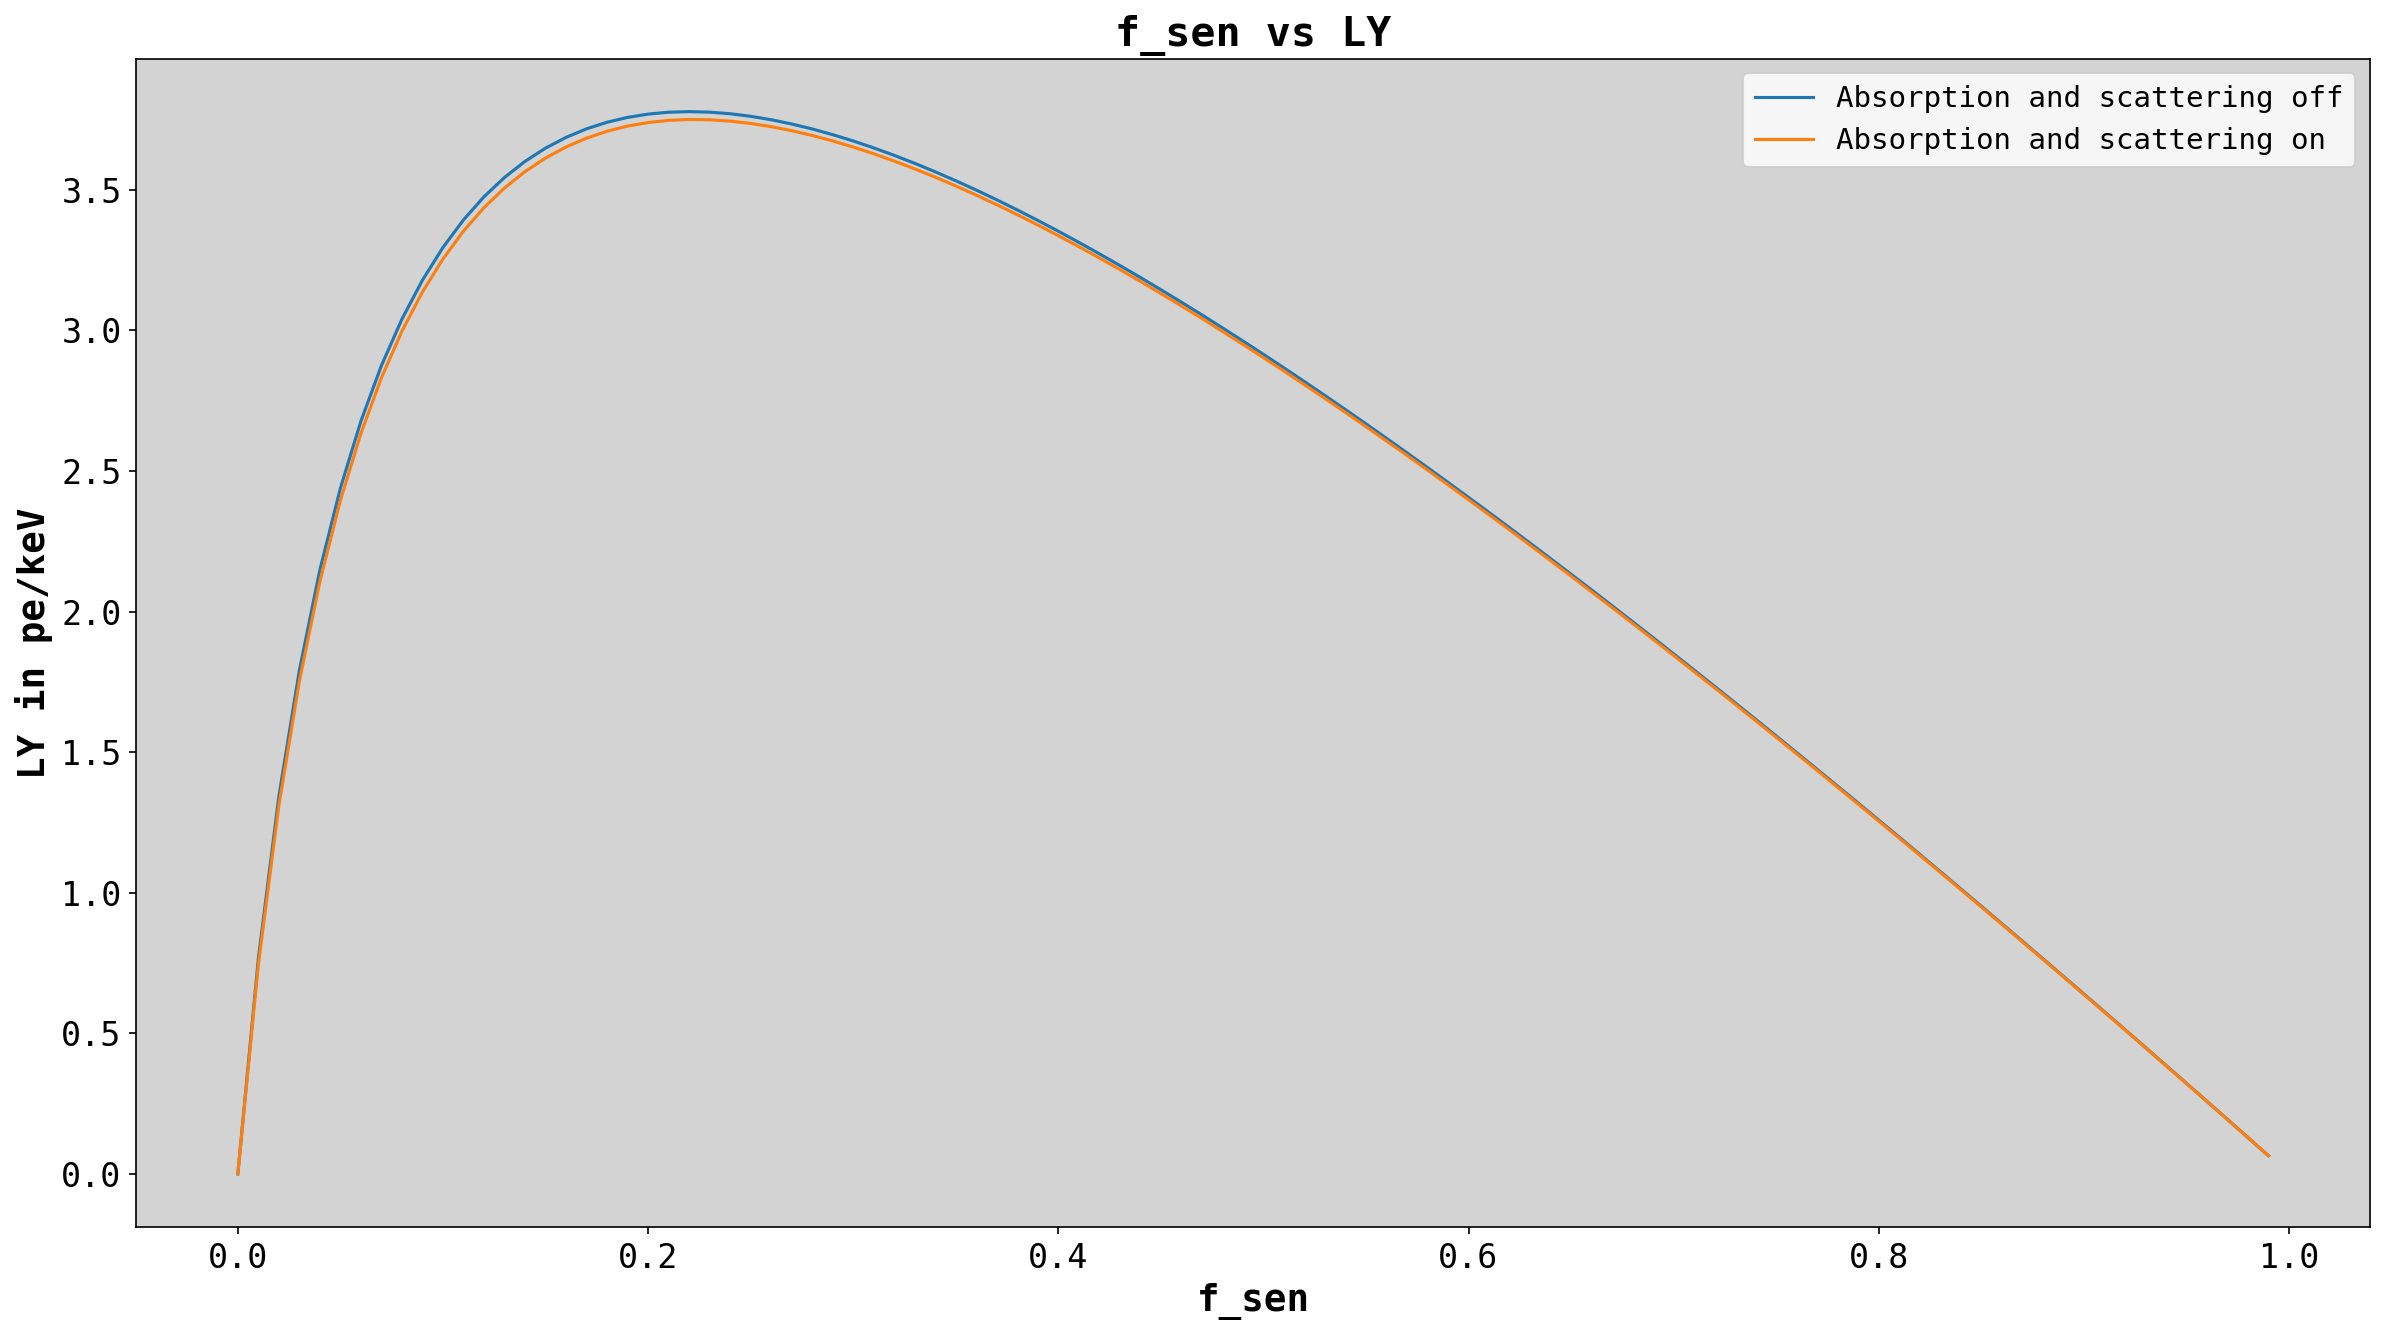

In [57]:
# %matplotlib inline
AMLY_2PAC_Q_off = []
AMLY_2PAC_Q_on = []
f_sen_2PAC_vector = np.arange(0, 1, 0.01)
for f_sen_2PAC in f_sen_2PAC_vector:
    AMLY_2PAC_Q_on.append(integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, wls_eff=0.472,
                                  f_sen=f_sen_2PAC, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=False))
    AMLY_2PAC_Q_off.append(integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, wls_eff=0.472,
                                  f_sen=f_sen_2PAC, Q_vis=1, Q_vuv=1,
                                  SiPM_covered=False))
fig98 = plt.figure(figsize=[16,9], dpi=150)
ax98 = plt.axes()
ax98.plot(f_sen_2PAC_vector, AMLY_2PAC_Q_off, label='Absorption and scattering off')
ax98.plot(f_sen_2PAC_vector, AMLY_2PAC_Q_on, label='Absorption and scattering on')
ax98.set_facecolor('lightgrey')
ax98.set_title('f_sen vs LY')
ax98.set_xlabel('f_sen')
ax98.set_ylabel('LY in pe/keV')
ax98.legend(fontsize=14)
## Not much difference in case of 2PAC.

<h2 style='color:Chartreuse;'> comparison for DarkSide Neutron veto </h2>

<h3 style = 'color: Chartreuse;'> Data</h3>

#### cenk's MC simulation results

In [58]:
mc_data_cenk = pd.DataFrame(list(zip([0.0132957, 0.0244807, 0.0317737, 0.0384706],
                                     [1.01835, 1.66342, 2.01606, 2.30419])), columns = ['f_sen', 'LY'] )

# mc_data_cenk

#### loading data exported from verification notebook

In [59]:
exported_data_zoom_loc = path.join(project_dir, 'data', 'all_values_2021-12-11-0-41-12-731240.csv') # f_sen from 0 to 0.5
exported_data_loc = path.join(project_dir, 'data', 'all_values_2021-12-11-5-27-20-976743.csv') # f_sen from 0 to 1
exported_data = pd.read_csv(exported_data_loc)
exported_data_zoom = pd.read_csv(exported_data_zoom_loc)

<br>
<span style = 'color: red'> Note:</span><p style = 'color: turquoise'> we'll use all parameters exactly as we did in verification notebook for direct comparison with Cenk's plot </p>

#### PDE

In [60]:
photon_wavelength_FBK = [285.87, 301.14, 320.99, 340.83, 365.26, 380.53, 391.22, 400.38, 411.06, 420.22, 435.49, 449.23, 464.50, 499.61, 588.16, 698.09]
PDE_vector_FBK = [18.39, 37.24, 41.87, 42.43, 45.03, 48.12, 52.72, 52.75, 52.77, 52.29, 48.77, 46.26, 40.71, 38.76, 28.82, 18.93] # %age values
PDE_normalized_vector_FBK = []
## Normalizing PDE values in FBK data as instructed by Cenk
PDE_normalized_vector_FBK = [value*0.40/max(PDE_vector_FBK) for value in PDE_vector_FBK]
frame = {'photon_wavelegnth':photon_wavelength_FBK, 'PDE_norm': PDE_normalized_vector_FBK}

PDE_FBK = pd.DataFrame(frame)

#### SiPM Reflectances

In [61]:
SiPM_R_cenk = pd.read_csv(path.join(project_dir, 'Data','SiPM_ref.csv'), sep = ',')
# cenk_SiPM_R_values = cenk_SiPM_R_vector.copy()
# cenk_R_SiPM_values['R'] = [int(value)/100 for value in cenk_R_SiPM_vector['R']]
SiPM_R_cenk2 = SiPM_R_cenk.copy()
SiPM_R_cenk2['LAr_equivalent_Reflectance'] = SiPM_R_cenk2['R']*0.91 

SiPM_R_cenk2['wavelength'] = 1239.847/SiPM_R_cenk2['E'] # Energy unit eV wavlength Unit: nm
# SiPM_ref.dat
SiPM_R_cenk3 = SiPM_R_cenk2.drop(columns = ['E', 'R'])
# SiPM_R_cenk3.head()

#### PEN reflectance

In [62]:
R_Wall_PEN_cenk = R_Wall_PEN.copy()
R_Wall_PEN_cenk['PEN_reflectance'] = R_Wall_PEN_cenk['PEN_reflectance']/0.994
# R_Wall_PEN_cenk.head()

<h3 style = 'color: Chartreuse;'> smoothing function </h3>

In [63]:
R_Wall_PEN_cenk_smooth = make_smooth(R_Wall_PEN_cenk)

PDE_FBK_smooth = make_smooth(PDE_FBK)

f_SiPM_R_cenk = interp1d(SiPM_R_cenk3['wavelength'], SiPM_R_cenk3['LAr_equivalent_Reflectance'])
SiPM_R_cenk_smooth = f_SiPM_R_cenk(wavelength_vector)

<h3 style = 'color: Chartreuse;'> Plots </h3>

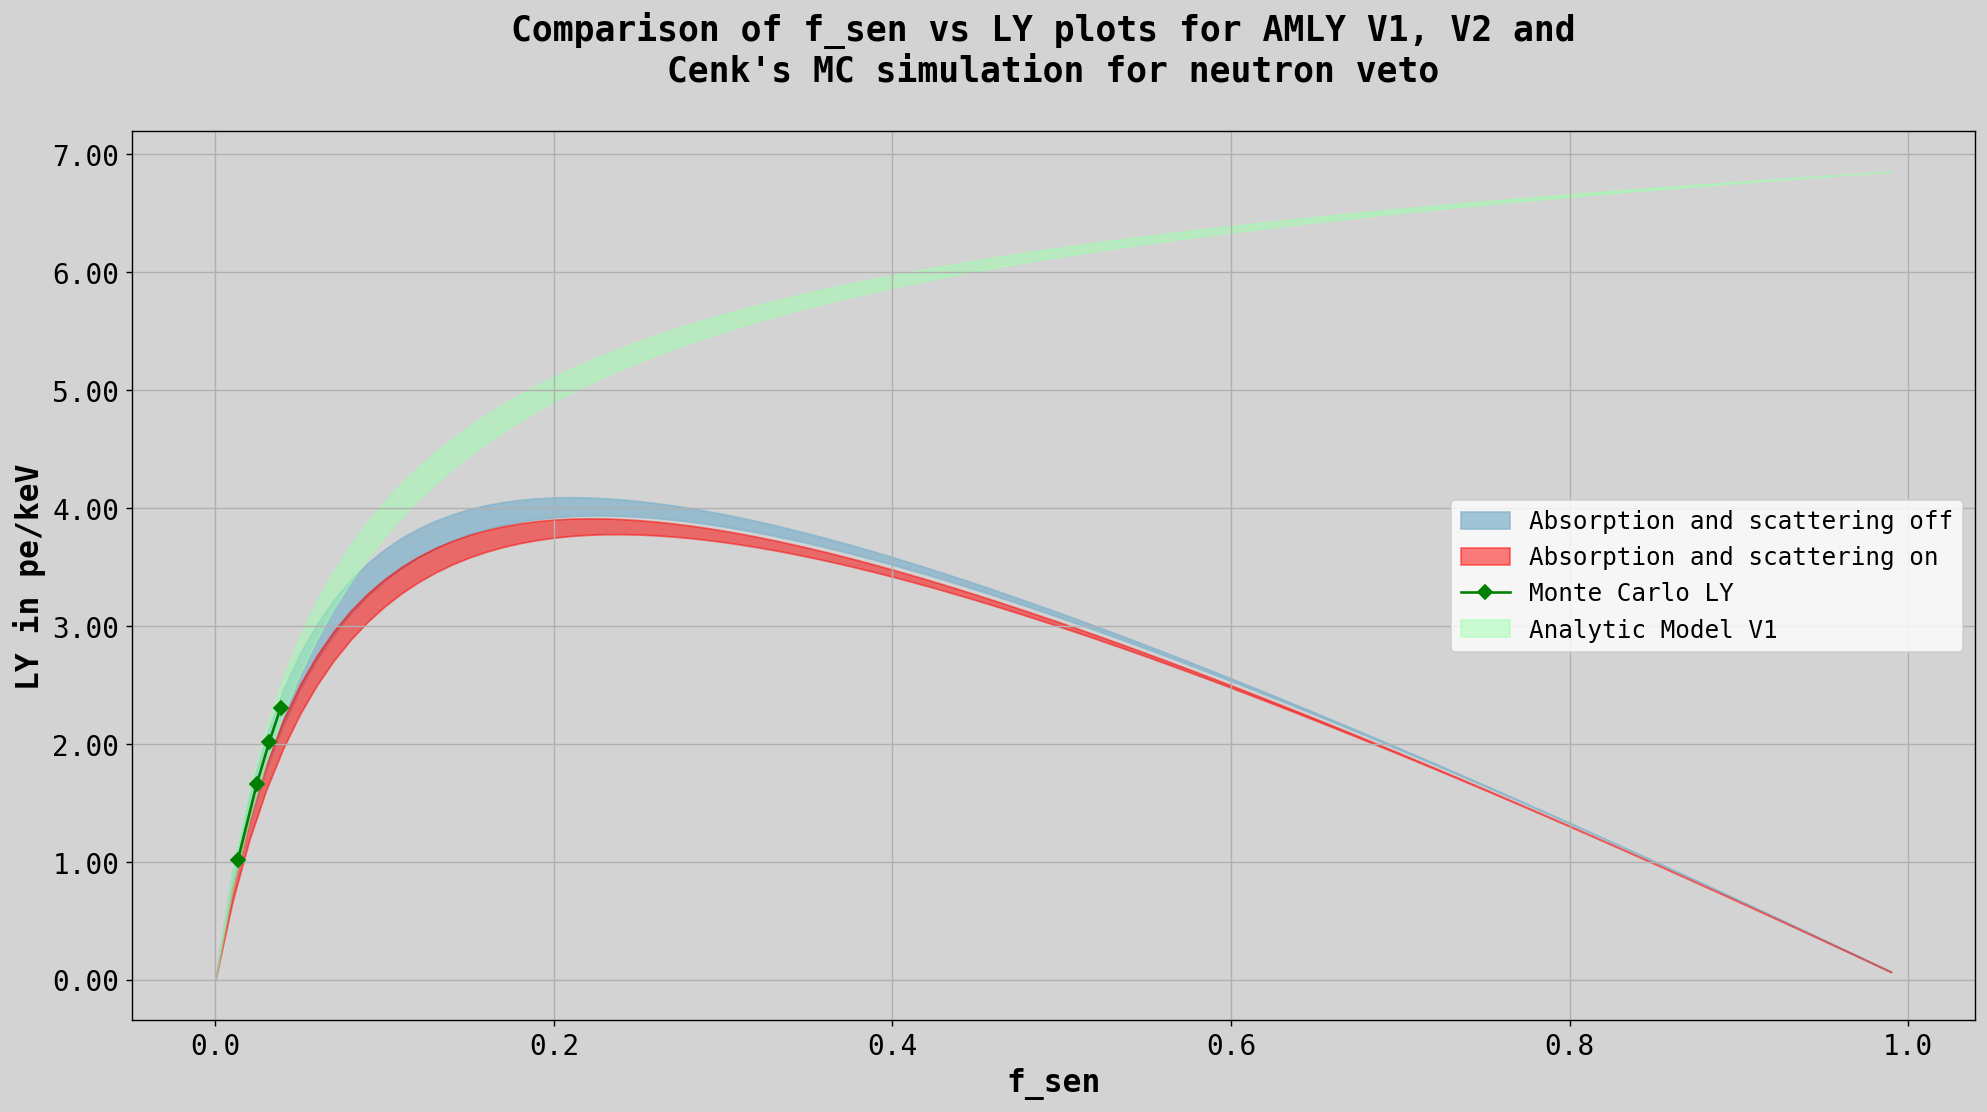

In [64]:
# %matplotlib qt
# comparing LY for Neutron veto with and withOUT absorption effect. Also with cenk's MC simulation.
Q_vis_DS_neutron_veto_test_value = calc_Q(L_char_DS_Neutron_veto, lambda_abs= 100, lambda_R= 300)
Q_vuv_DS_neutron_veto_test_value = calc_Q(L_char_DS_Neutron_veto, lambda_abs= 100, lambda_R= 0.97) # value from Dune paper: lambda_abs =17 
# cenk used lambda_abs = 100 for both visible and VUV (for Argon) 
AMLY_neutron_Q_off_lower = []
AMLY_neutron_Q_off_upper = []
AMLY_neutron_Q_on_lower = []
AMLY_neutron_Q_on_upper = []
# f_sen_DS_neutron_vector = np.arange(0, 0.07, 0.001)
f_sen_DS_neutron_vector = np.arange(0, 1.0, 0.01)
for f_sen_DS_neutron in f_sen_DS_neutron_vector:
    AMLY_neutron_Q_on_upper.append(integrate_LY(wavelength_vector, E_PEN_smooth, PDE_FBK_smooth, SiPM_R_cenk_smooth,
                                                R_Wall_PEN_cenk_smooth, wls_eff=0.472, f_sen=f_sen_DS_neutron,
                                                Q_vis=Q_vis_DS_neutron_veto_test_value, Q_vuv=Q_vuv_DS_neutron_veto_test_value,
                                                SiPM_covered=False))
    AMLY_neutron_Q_on_lower.append(integrate_LY(wavelength_vector, E_PEN_smooth, PDE_FBK_smooth, SiPM_R_cenk_smooth,
                                                R_Wall_PEN_cenk_smooth*0.988, wls_eff=0.472, f_sen=f_sen_DS_neutron,
                                                Q_vis=Q_vis_DS_neutron_veto_test_value, Q_vuv=Q_vuv_DS_neutron_veto_test_value,
                                               SiPM_covered=False))
    
    AMLY_neutron_Q_off_upper.append(integrate_LY(wavelength_vector, E_PEN_smooth, PDE_FBK_smooth, SiPM_R_cenk_smooth,
                                                 R_Wall_PEN_cenk_smooth, wls_eff=0.472, f_sen=f_sen_DS_neutron,
                                                 Q_vis=1, Q_vuv=1, SiPM_covered=False))
    AMLY_neutron_Q_off_lower.append(integrate_LY(wavelength_vector, E_PEN_smooth, PDE_FBK_smooth, SiPM_R_cenk_smooth,
                                                 R_Wall_PEN_cenk_smooth*0.988, wls_eff=0.472, f_sen=f_sen_DS_neutron,
                                                 Q_vis=1, Q_vuv=1, SiPM_covered=False))

fig99 = plt.figure(figsize=[16, 9], dpi=125)
ax99 = plt.axes()
ax99.fill_between(f_sen_DS_neutron_vector, AMLY_neutron_Q_off_lower, AMLY_neutron_Q_off_upper,
                  color='#84B4CB', label='Absorption and scattering off', alpha=0.75)

ax99.fill_between(f_sen_DS_neutron_vector, AMLY_neutron_Q_on_lower, AMLY_neutron_Q_on_upper,
                  color='red', label='Absorption and scattering on', alpha=0.5)

ax99.plot(mc_data_cenk['f_sen'], mc_data_cenk['LY'], marker='D', color='green', label='Monte Carlo LY')

ax99.fill_between(exported_data['f_sen_vector'], exported_data['LY_PEN_lower'], exported_data['LY_PEN_upper'],
                  label="Analytic Model V1", color='#A0FFAF', alpha=0.5)

# ax99.fill_between(exported_data_zoom['f_sen_vector'], exported_data_zoom['LY_PEN_lower'], exported_data_zoom['LY_PEN_upper'],
#                   label="Analytic Model V1", color='#A0FFAF', alpha=0.5)

ax99.set_title(f"Comparison of f_sen vs LY plots for AMLY V1, V2 and \n Cenk's MC simulation for neutron veto \n", fontsize=20)
ax99.set_xlabel('f_sen', fontsize=18)
# ax99.set_xticks(f_sen_DS_neutron_vector[::10])
# ax99.set_xticklabels(f_sen_DS_neutron_vector[::10], fontsize=16)
ax99.set_ylabel('LY in pe/keV', fontsize=18)
# ax99.set_yticks(AMLY_neutron_Q_off[::10])
# ax99.set_yticklabels(AMLY_neutron_Q_off[::10], fontsize=16)
ax99.set_facecolor('lightgrey')
fig99.set_facecolor('lightgrey')
ax99.grid()
ax99.set_yscale('linear')
ax99.legend(fontsize=14, loc='center right')
ax99.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# fig99.savefig(r'all_plots/AMLY_MC.png')

<br>
<span style = 'color: red; font-size:14pt'> Note:</span><p style = 'color: turquoise'> In AMLY V1 LY keeps on increases whereas in V2 it starts declining after a certain f_sen (when SiPM's are not covered with WLS). </p>

![zooming in on the plot](all_plots\AM_V1_V2_MC_zoomed.png "AMLY V1 and MC data somewhat overlap")
<span style='color:turquoise'> Cenk's MC results somewhat overlap with AMLY estimates.</span>

<h1 style = 'color: #ff0038; text-align: center'>Q value and LY 🌟</h1>
<p>
    This raises serious concerns about size of detector.
</p>

<h2 style = 'color : magenta'> Absorption length vs Q </h2>

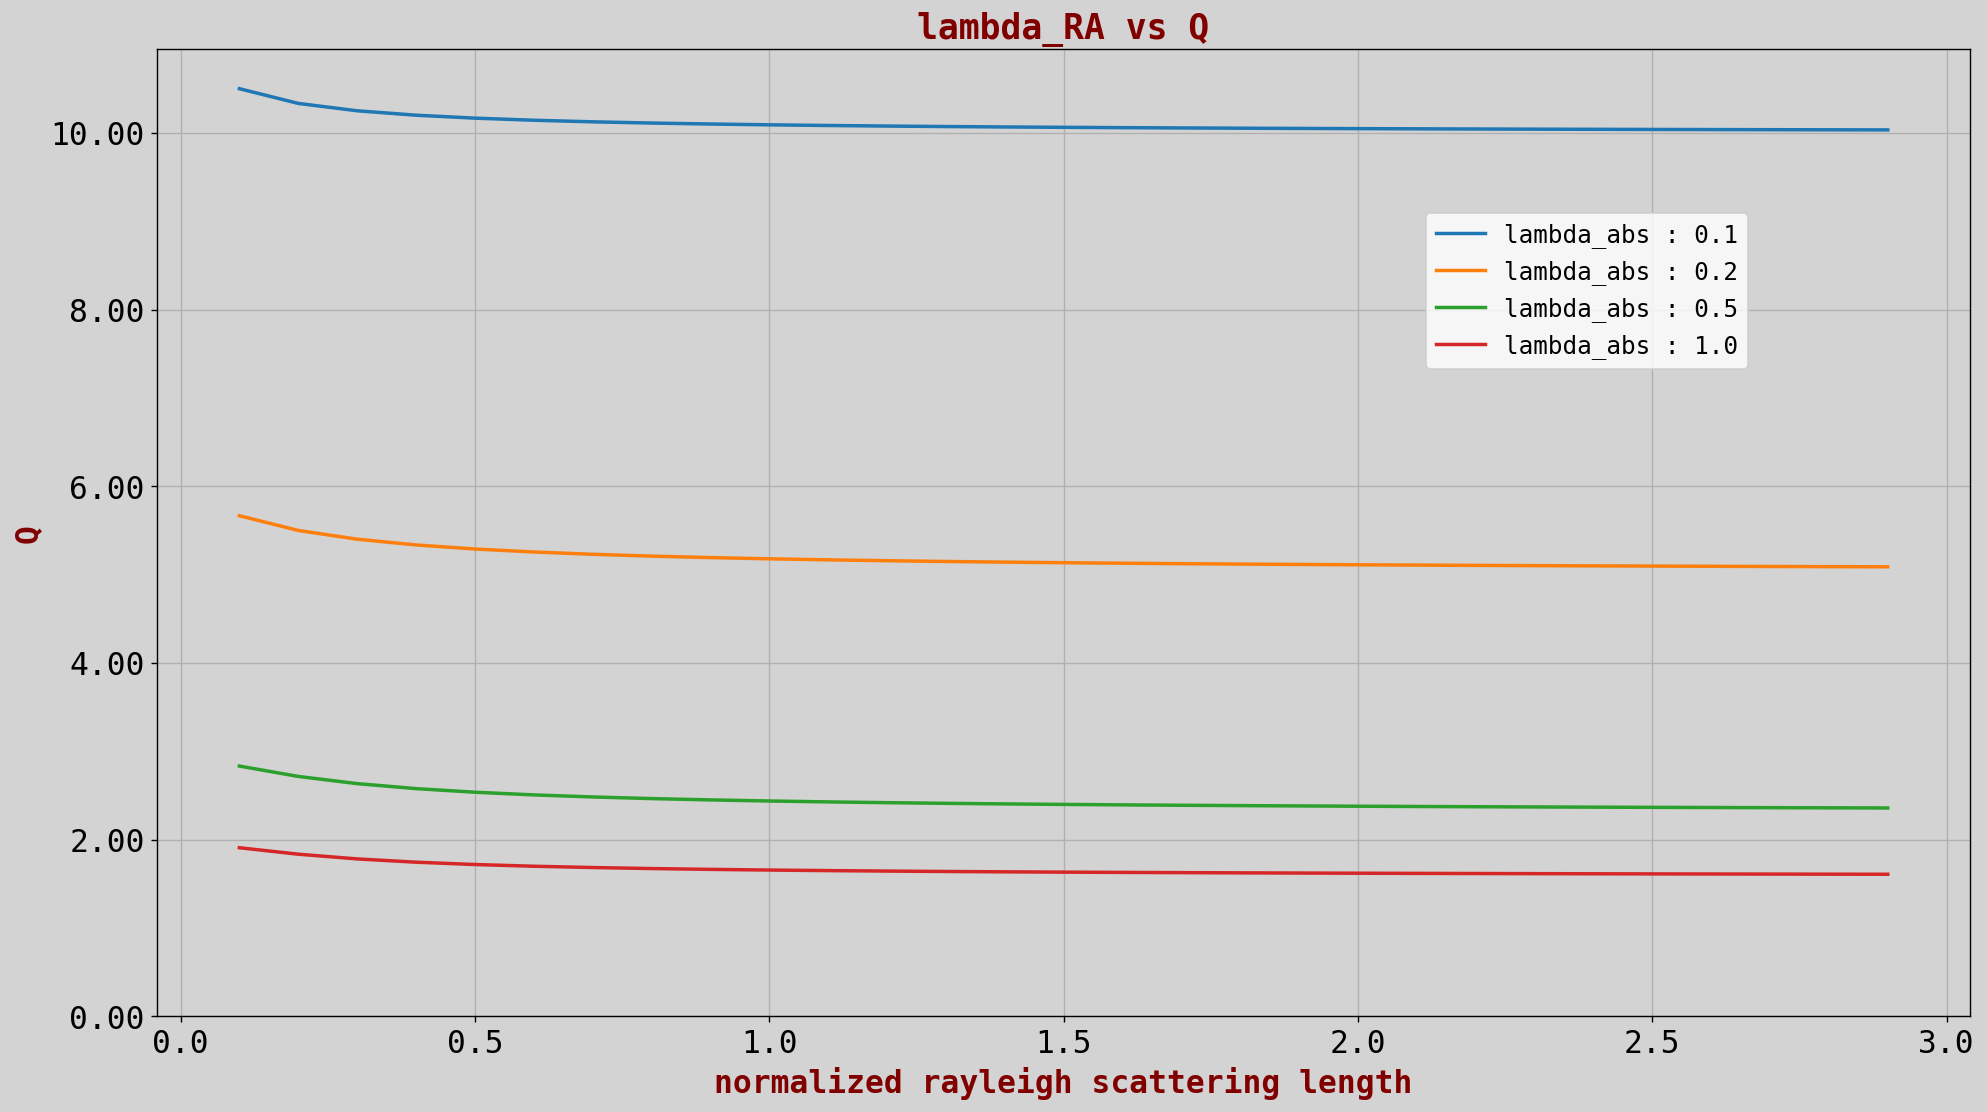

In [65]:
# %matplotlib inline
# %matplotlib qt
fig100 = plt.figure('100', figsize=[16, 9], dpi=125 )
ax100 = plt.axes()
lambda_R_test_vector = np.arange(0, 3, 0.1)
lambda_abs_vector = np.array([0.1, 0.2, 0.5, 1.0])
for lambda_abs_test_value in lambda_abs_vector:
    Q_vector_fixed_lambda_abs = []
    for lambda_R_test_value in lambda_R_test_vector:
        Q_vector_fixed_lambda_abs.append(calc_Q(L_char=1, lambda_abs=lambda_abs_test_value, lambda_R=lambda_R_test_value))
    ax100.plot(lambda_R_test_vector, Q_vector_fixed_lambda_abs, label=f'lambda_abs : {lambda_abs_test_value}', linewidth=2)

ax100.set_facecolor('lightgrey')
fig100.set_facecolor('lightgrey')
ax100.grid('on')
ax100.set_xlabel('normalized rayleigh scattering length', fontsize=18, weight='bold', color='maroon')
ax100.set_ylabel('Q', fontsize=18, weight='bold', color='maroon')
ax100.set_title('lambda_RA vs Q', fontsize=20, weight='bold', color='maroon')
ax100.legend(loc=[0.70, 0.67], fontsize=14)
ax100.set_xticks(np.arange(0, 3.5, 0.5))
ax100.set_xticklabels(np.arange(0, 3.5, 0.5), fontsize=18)
ax100.set_yticks(np.arange(0,12,2))
ax100.set_yticklabels(np.arange(0,12,2), fontsize=18)
ax100.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# code snippet for saving plot
ax100.get_figure().subplots_adjust(bottom=0.20);
ax100.get_figure().subplots_adjust(left=0.20);

fig100.savefig(r'all_plots\fig100.png');

<h2 style = 'color : magenta'> Characteristic length vs Q </h2>

In [66]:
# Q values seem to have a drastic effect on LY.
# plot showing effect of different parameter on Q
# plot showing effect of Q on Light Yield

In [67]:
print('Characteristic Lengths', '\n', '2PAC: ', L_char_2PAC, '\n', 'DS muon veto: ', L_char_DS_muon_veto, '\n',
      'DS Neutron veto: ', L_char_DS_Neutron_veto, '\n', 'ARGO: ', L_char_ARGO)

Characteristic Lengths 
 2PAC:  0.05584383331023524 
 DS muon veto:  5.897820210548527 
 DS Neutron veto:  1.3964499372228685 
 ARGO:  7.050000000000001


In [68]:
Q_vis_2PAC = calc_Q(L_char_2PAC, lambda_abs= 100, lambda_R= 300)
Q_vuv_ARGO = calc_Q(L_char_2PAC, lambda_abs= 17, lambda_R= 0.97)
# Q_vuv_2PAC = calc_Q(L_char_2PAC, lambda_abs= 100000, lambda_R= 100000) # sanity check value of lambda_abs set at 1000

In [69]:
Q_vis_DS_muon_veto = calc_Q(L_char_DS_muon_veto, lambda_abs= 100, lambda_R= 300)
Q_vuv_DS_muon_veto = calc_Q(L_char_DS_muon_veto, lambda_abs= 17, lambda_R= 0.97)
# Q_vuv_DS_muon_veto = calc_Q(ds_veto_char_length, lambda_abs= 100000, lambda_R= 100000) # sanity check value of lambda_abs set at 1000

In [70]:
Q_vis_ARGO = calc_Q(L_char_ARGO, lambda_abs= 100, lambda_R= 300)
Q_vuv_ARGO = calc_Q(L_char_ARGO, lambda_abs= 17, lambda_R= 0.97)
# Q_vuv_ARGO = calc_Q(L_char_ARGO, lambda_abs= 100000, lambda_R= 100000) # sanity check value of lambda_abs set at 1000

In [71]:
print('Q_VUV: ', '\n', '2PAC: ', Q_vuv_2PAC, '\n', 'DS Muon veto: ',  Q_vuv_DS_muon_veto, '\n',
      'DS Neutron veto: ',  Q_vuv_DS_neutron_veto, '\n', 'ARGO: ', Q_vuv_ARGO)

Q_VUV:  
 2PAC:  1.0016591236102481 
 DS Muon veto:  1.2935136564549623 
 DS Neutron veto:  1.0511080712694048 
 ARGO:  1.3609181748974062


In [72]:
print('Q_vis:', '\n', '2PAC: ', Q_vis_2PAC, '\n', 'DS Muon veto: ',  Q_vis_DS_neutron_veto, '\n',
      'DS Neutron veto: ',  Q_vis_DS_neutron_veto, '\n', 'ARGO: ', Q_vis_ARGO)

Q_vis: 
 2PAC:  1.0002792538169047 
 DS Muon veto:  1.0070039170323342 
 DS Neutron veto:  1.0070039170323342 
 ARGO:  1.0358021686890884


In [73]:
Q_vuv_vector = []
Q_vis_vector = []
for length_variable in np.arange(0.1, 10, 0.1):
    Q_vuv_vector.append(calc_Q(L_char=length_variable, lambda_abs=17, lambda_R=0.97))
    Q_vis_vector.append(calc_Q(L_char=length_variable, lambda_abs= 100, lambda_R= 300))

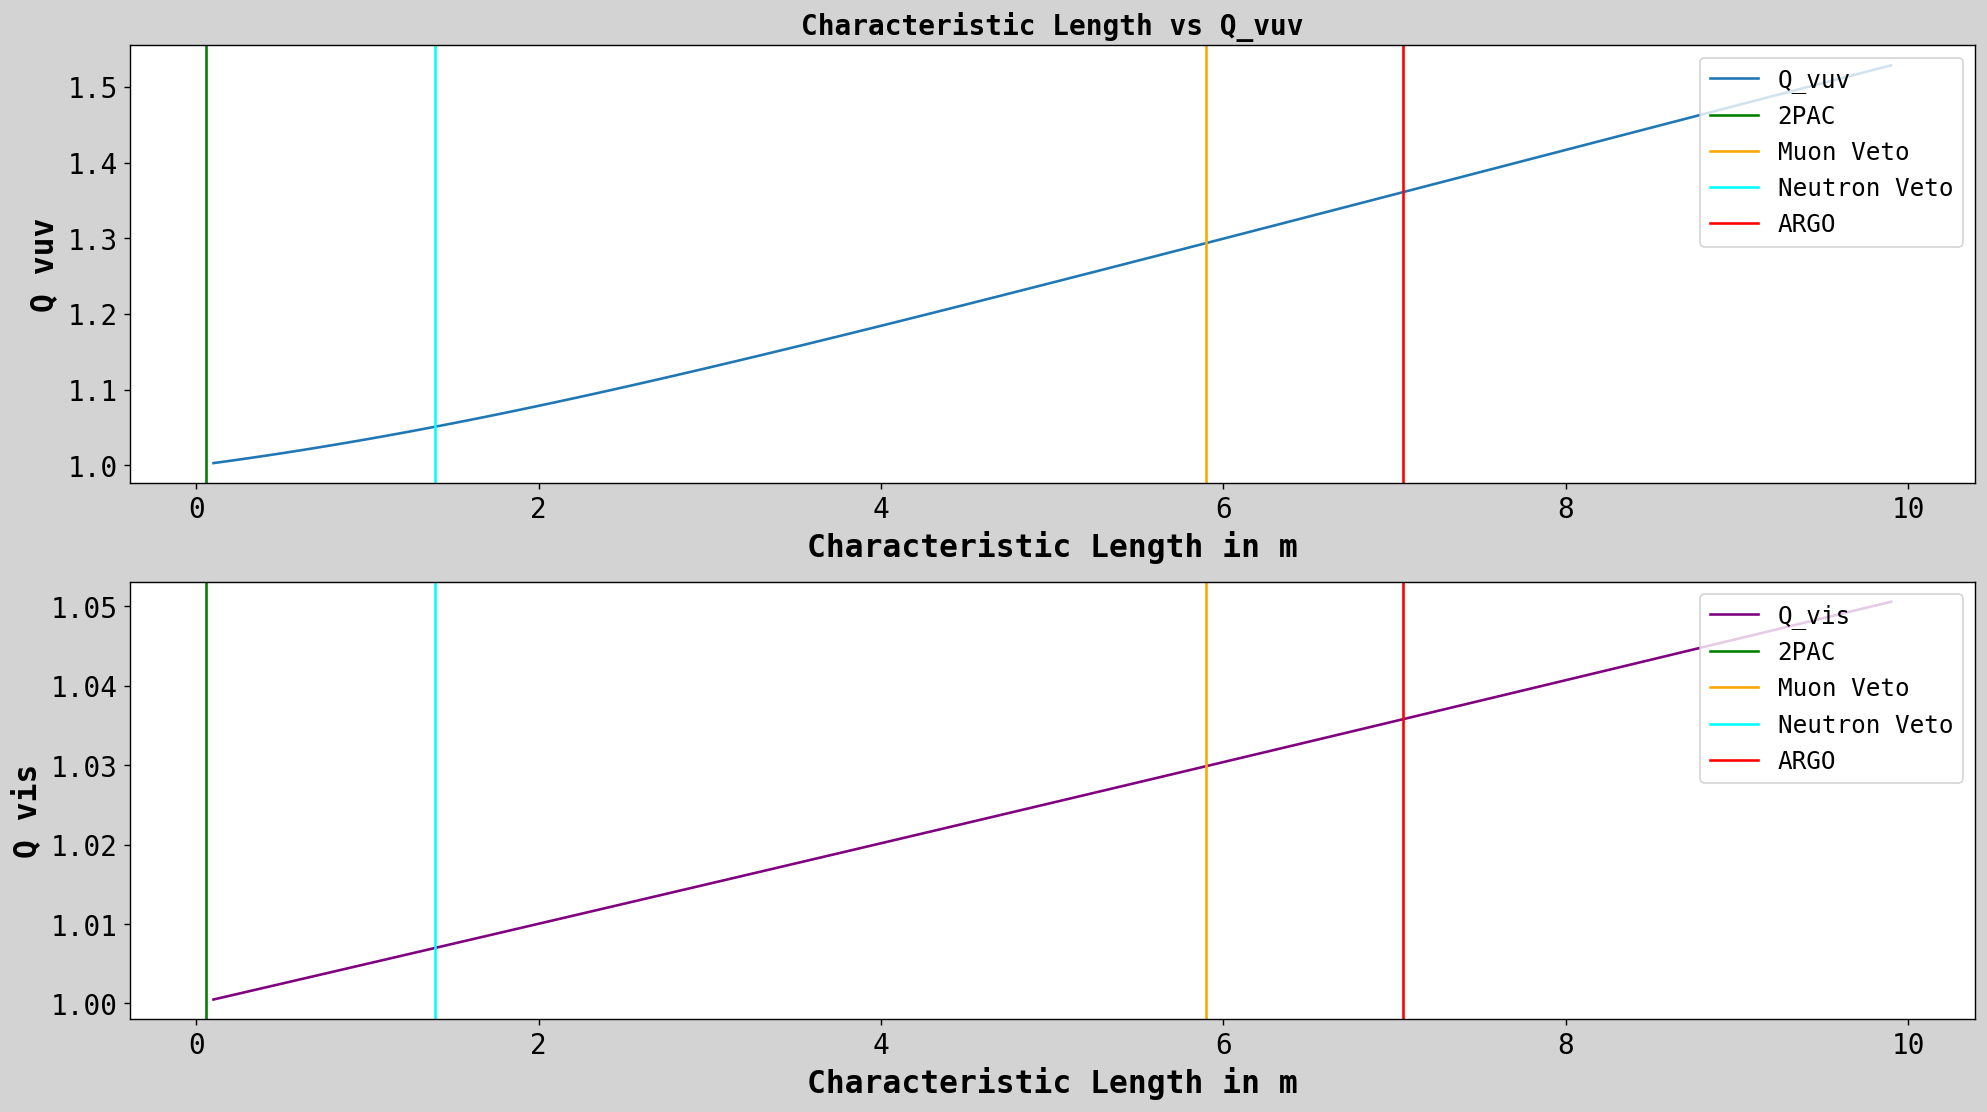

In [74]:
# %matplotlib qt
# %matplotlib inline
fig12=plt.figure('12', figsize=[16, 9], dpi=125 )
fig12.set_facecolor('lightgrey')
ax12 = plt.subplot(2, 1, 1)
ax12.plot(np.arange(0.1, 10, 0.1), Q_vuv_vector, label='Q_vuv')
ax12.set_xlabel('Characteristic Length in m')
ax12.set_ylabel('Q vuv')
ax12.axvline(L_char_2PAC, c='g', label='2PAC')
ax12.axvline(L_char_DS_muon_veto, c='orange', label='Muon Veto')
ax12.axvline(L_char_DS_Neutron_veto, c='cyan', label='Neutron Veto')
ax12.axvline(L_char_ARGO, c='r', label='ARGO')
ax12.legend(loc='upper right')
ax12.set_title('Characteristic Length vs Q_vuv', size=16, weight='bold')

ax12 = plt.subplot(2, 1, 2)
ax12.plot(np.arange(0.1, 10, 0.1), Q_vis_vector, label='Q_vis', c= 'purple')
ax12.set_xlabel('Characteristic Length in m')
ax12.set_ylabel('Q vis ')
ax12.axvline(L_char_2PAC, c='g', label='2PAC')
ax12.axvline(L_char_DS_muon_veto, c='orange', label='Muon Veto')
ax12.axvline(L_char_DS_Neutron_veto, c='cyan', label='Neutron Veto')
ax12.axvline(L_char_ARGO, c='r', label='ARGO')
ax12.legend(loc='upper right')
fig12.savefig(r'all_plots/L_char_vs_Q')

<h2 style = 'color : magenta'> SiPM's not coverd with WLS </h2>

In [75]:
LY_vector_1 = []
Q_feasible_values = np.arange(1, 1.5, 0.01)

for Q_variable in Q_feasible_values:
    LY_vector_1.append(integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_variable,
                                  SiPM_covered=False))

LY_ARGO_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                       f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO, SiPM_covered=False)
LY_2PAC_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=False)
LY_DS_muon_veto_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto,
                                  SiPM_covered=False)
LY_DS_neutron_veto_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto,
                                  SiPM_covered=False)

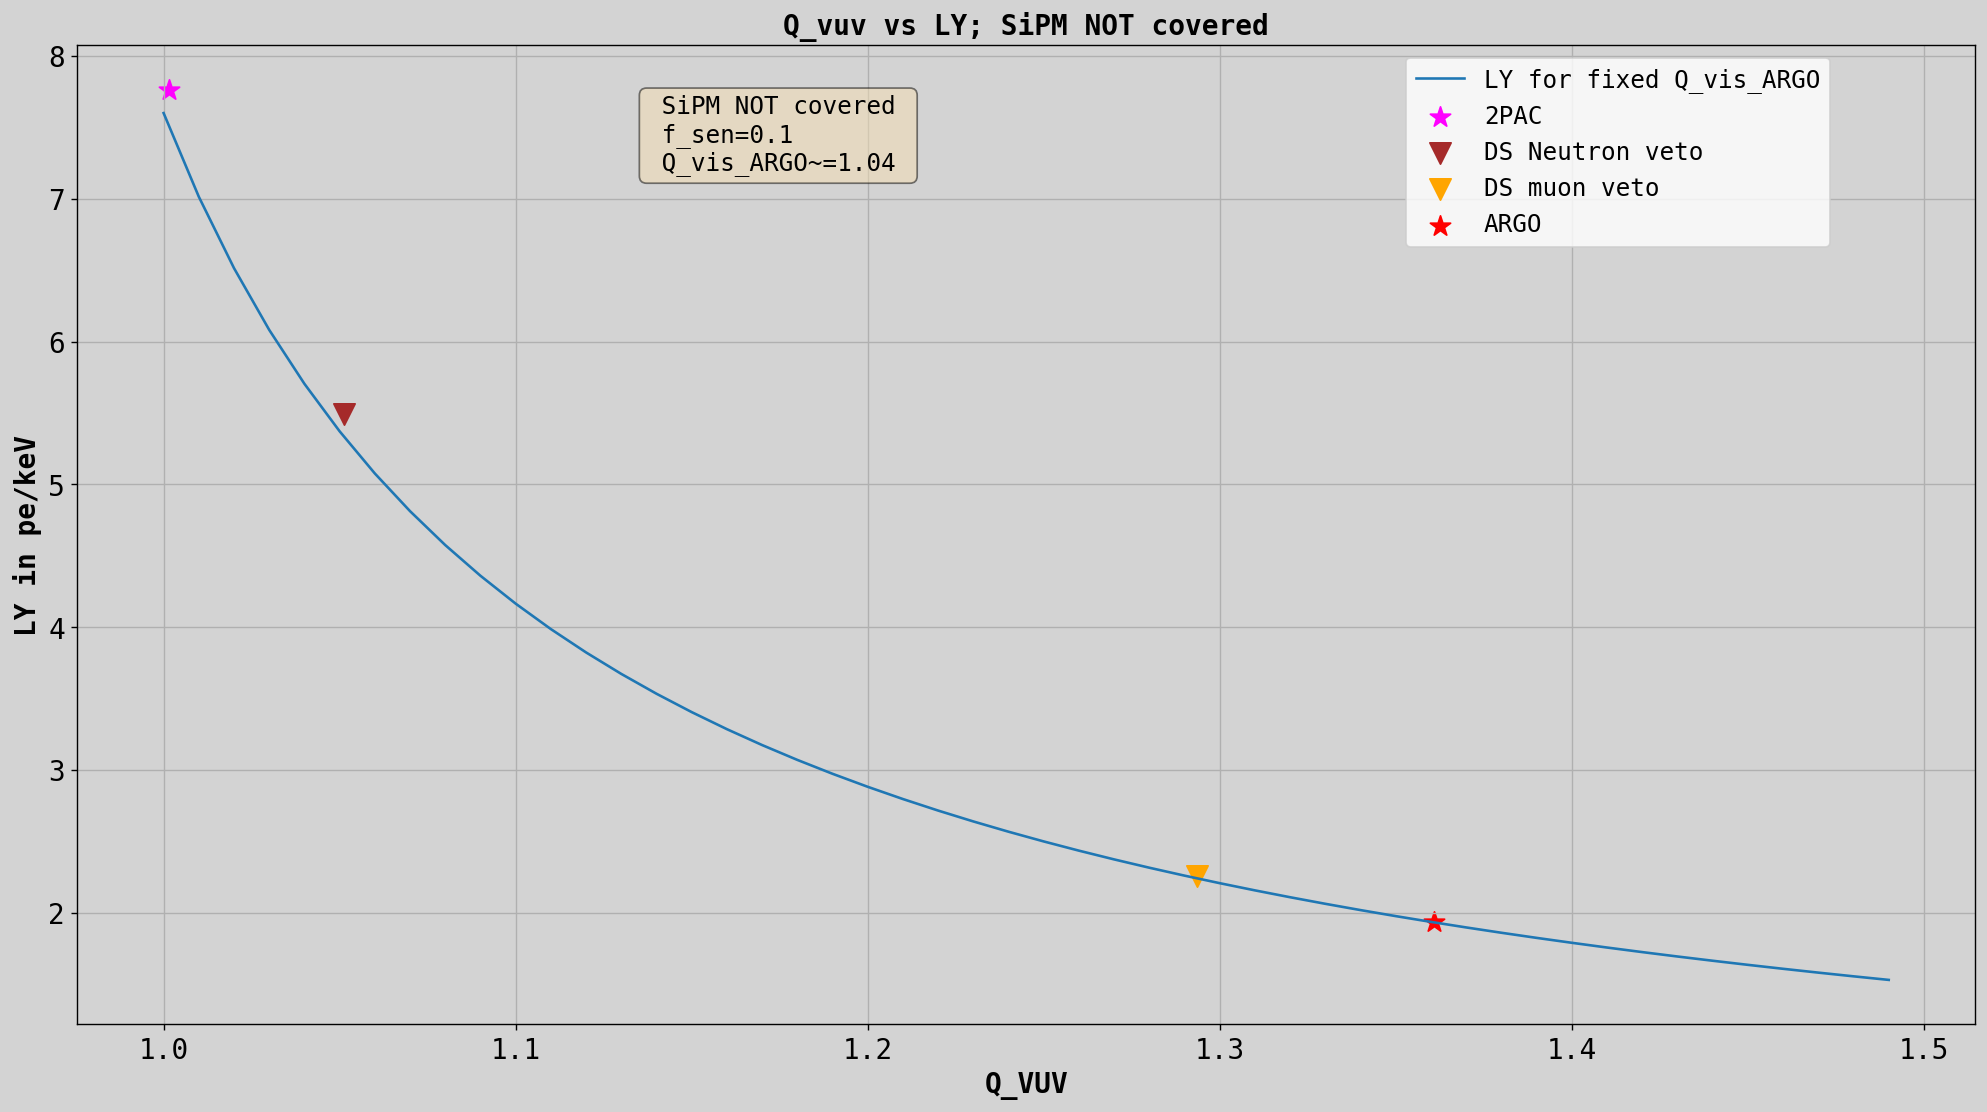

In [76]:
# %matplotlib inline
# %matplotlib qt
fig14 = plt.figure('14', figsize=[16,9], dpi=125)
ax14 = plt.axes()
ax14.plot(Q_feasible_values, LY_vector_1, label='LY for fixed Q_vis_ARGO')
ax14.set_yscale('linear')
ax14.legend(loc='best')
ax14.set_xlabel('Q_VUV', size=16, weight='bold')
ax14.set_ylabel('LY in pe/keV', size=16, weight='bold')
ax14.scatter(Q_vuv_2PAC, LY_2PAC_1, marker = '*', s=150, label='2PAC', color='magenta')
ax14.scatter(Q_vuv_DS_neutron_veto, LY_DS_neutron_veto_1, marker = 'v', s=150, label='DS Neutron veto', color='brown')
ax14.scatter(Q_vuv_DS_muon_veto, LY_DS_muon_veto_1, marker = 'v', s=150, label='DS muon veto', color='orange')
ax14.scatter(Q_vuv_ARGO, LY_ARGO_1, marker = '*', s=150, label='ARGO', color='red')
ax14.set_title('Q_vuv vs LY; SiPM NOT covered', size=16, weight='bold')
# ax14.legend(loc='best')
ax14.legend(loc='upper right', bbox_to_anchor=(0.93, 1.0))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
txtstr = f' SiPM NOT covered \n f_sen=0.1 \n Q_vis_ARGO~={Q_vis_ARGO:.2f}'
ax14.text(0.30, 0.95, txtstr, transform=ax14.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax14.grid()

ax14.set_facecolor('lightgrey')
fig14.set_facecolor('lightgrey')
## the Q_vis for the cases considered does not differ much. All cases lie on the LY curve proving the effect of Q_vis in this range is not very significant.

fig14.savefig(r'C:\Users\sarth\projects\LY_Analytic_Model\all_plots\fig14.png')

In [77]:
'ARGO LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO,
                                  SiPM_covered=False)

('ARGO LY:', 1.9326369620988664)

In [78]:
'DS Neutron veto LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto,
                                  SiPM_covered=False)

('DS Neutron veto LY:', 5.489852508988709)

In [79]:
'DS Muon Veto LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto,
                                  SiPM_covered=False)

('DS Muon Veto LY:', 2.2542314854024412)

In [80]:
'2PAC LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=False)

('2PAC LY:', 7.762256542634427)

<h2 style = 'color : magenta'> SiPM's coverd with WLS </h2>

In [81]:
LY_vector_2 = []
Q_feasible_values = np.arange(1, 1.5, 0.01)

for Q_variable in Q_feasible_values:
    LY_vector_2.append(integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_variable,
                                  SiPM_covered=True))
LY_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                       f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO, SiPM_covered=True)
LY_2PAC_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=True)
LY_DS_muon_veto_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto,
                                  SiPM_covered=True)
LY_DS_neutron_veto_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto,
                                  SiPM_covered=True)

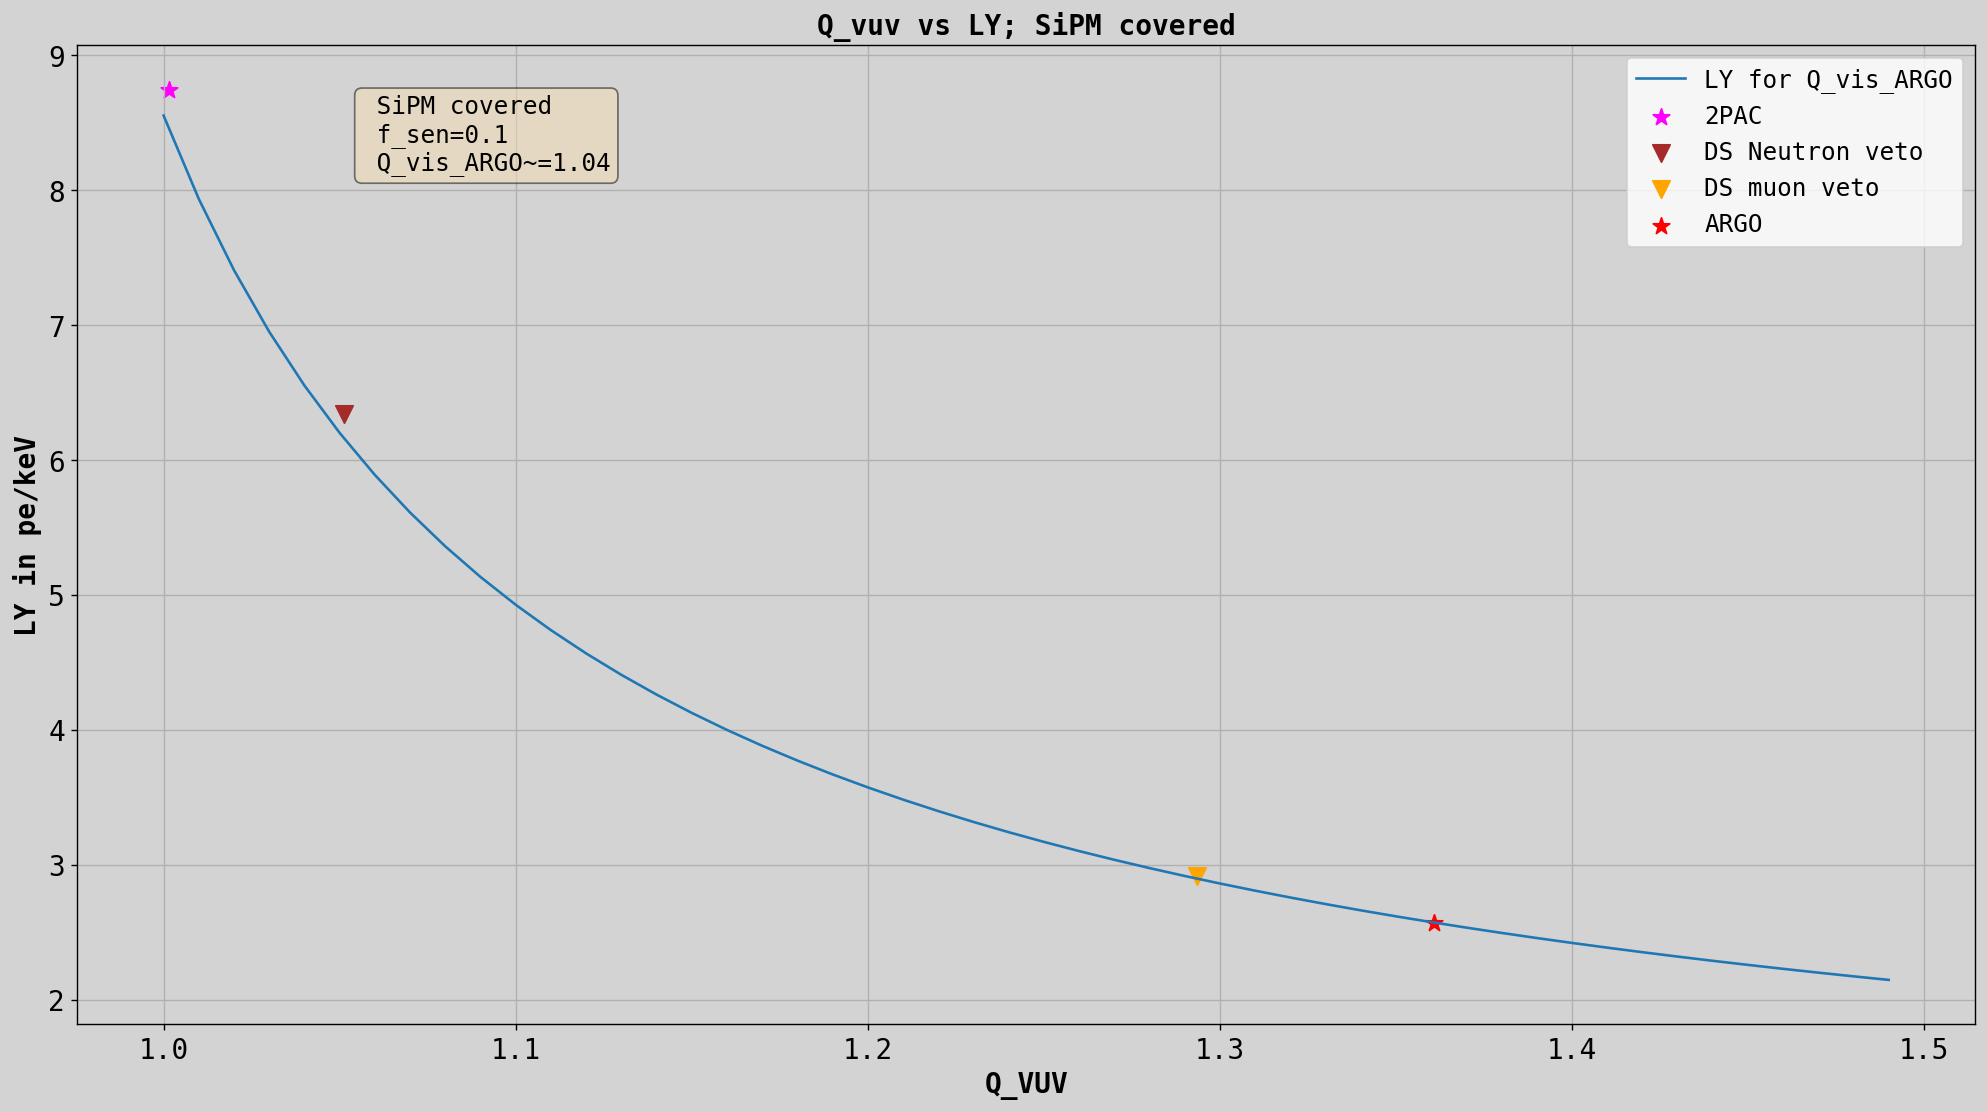

In [82]:
# %matplotlib inline
# %matplotlib qt
fig15 = plt.figure('15')
ax15 = plt.axes()
ax15.plot(Q_feasible_values, LY_vector_2, label='LY for Q_vis_ARGO')
ax15.set_yscale('linear')
ax15.legend(loc='best')
ax15.set_xlabel('Q_VUV', size=16, weight='bold')
ax15.set_ylabel('LY in pe/keV', size=16, weight='bold')
ax15.scatter(Q_vuv_2PAC, LY_2PAC_2, label='2PAC', marker='*', s=100, color='magenta')
ax15.scatter(Q_vuv_DS_neutron_veto, LY_DS_neutron_veto_2, marker='v', s=100, label='DS Neutron veto', color='brown')
ax15.scatter(Q_vuv_DS_muon_veto, LY_DS_muon_veto_2, marker='v', s=100, label='DS muon veto', color='orange')
ax15.scatter(Q_vuv_ARGO, LY_ARGO_2, label='ARGO', marker='*', s=100, color='red')
ax15.set_title('Q_vuv vs LY; SiPM covered', size=16, weight='bold')
txtstr = f' SiPM covered \n f_sen=0.1 \n Q_vis_ARGO~={Q_vis_ARGO:.2f}'
ax15.text(0.15, 0.95, txtstr, transform=ax15.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax15.grid()
ax15.set_facecolor('lightgrey')
fig15.set_facecolor('lightgrey')
# ax152 = ax15.twiny()
# ax152.set_xlim(0, 10)
# ax152.set_xlabel('L_Char', size=16, weight='bold')
ax15.legend()
# fig15.savefig(r'C:\Users\sarth\projects\LY_Analytic_Model\all_plots\fig15.png')

In [83]:
'ARGO LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO,
                                  SiPM_covered=True)

('ARGO LY:', 2.5714188842725414)

In [84]:
'DS Neutron veto LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto,
                                  SiPM_covered=True)

('DS Neutron veto LY:', 6.341454847386831)

In [85]:
'DS Muon Veto LY: ', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto,
                                  SiPM_covered=True)

('DS Muon Veto LY: ', 2.91393788867598)

In [86]:
'2PAC LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=True)

('2PAC LY:', 8.743778295121725)

<h2 style = 'color : Magenta'> Q_vis vs LY when SiPM's coverd with WLS </h2>

In [87]:
LY_vector_3 = []
Q_feasible_values = np.arange(1.0, 1.1, 0.0001)

for Q_variable in Q_feasible_values:
    LY_vector_3.append(integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_variable, Q_vuv=Q_vuv_ARGO,
                                  SiPM_covered=True))
LY_ARGO_3 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                       f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO, SiPM_covered=True)
LY_2PAC_3 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=True)
LY_DS_muon_veto_3 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_muon_veto, Q_vuv=Q_vuv_DS_muon_veto,
                                  SiPM_covered=True)
LY_DS_neutron_veto_3 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_DS_neutron_veto, Q_vuv=Q_vuv_DS_neutron_veto,
                                  SiPM_covered=True)

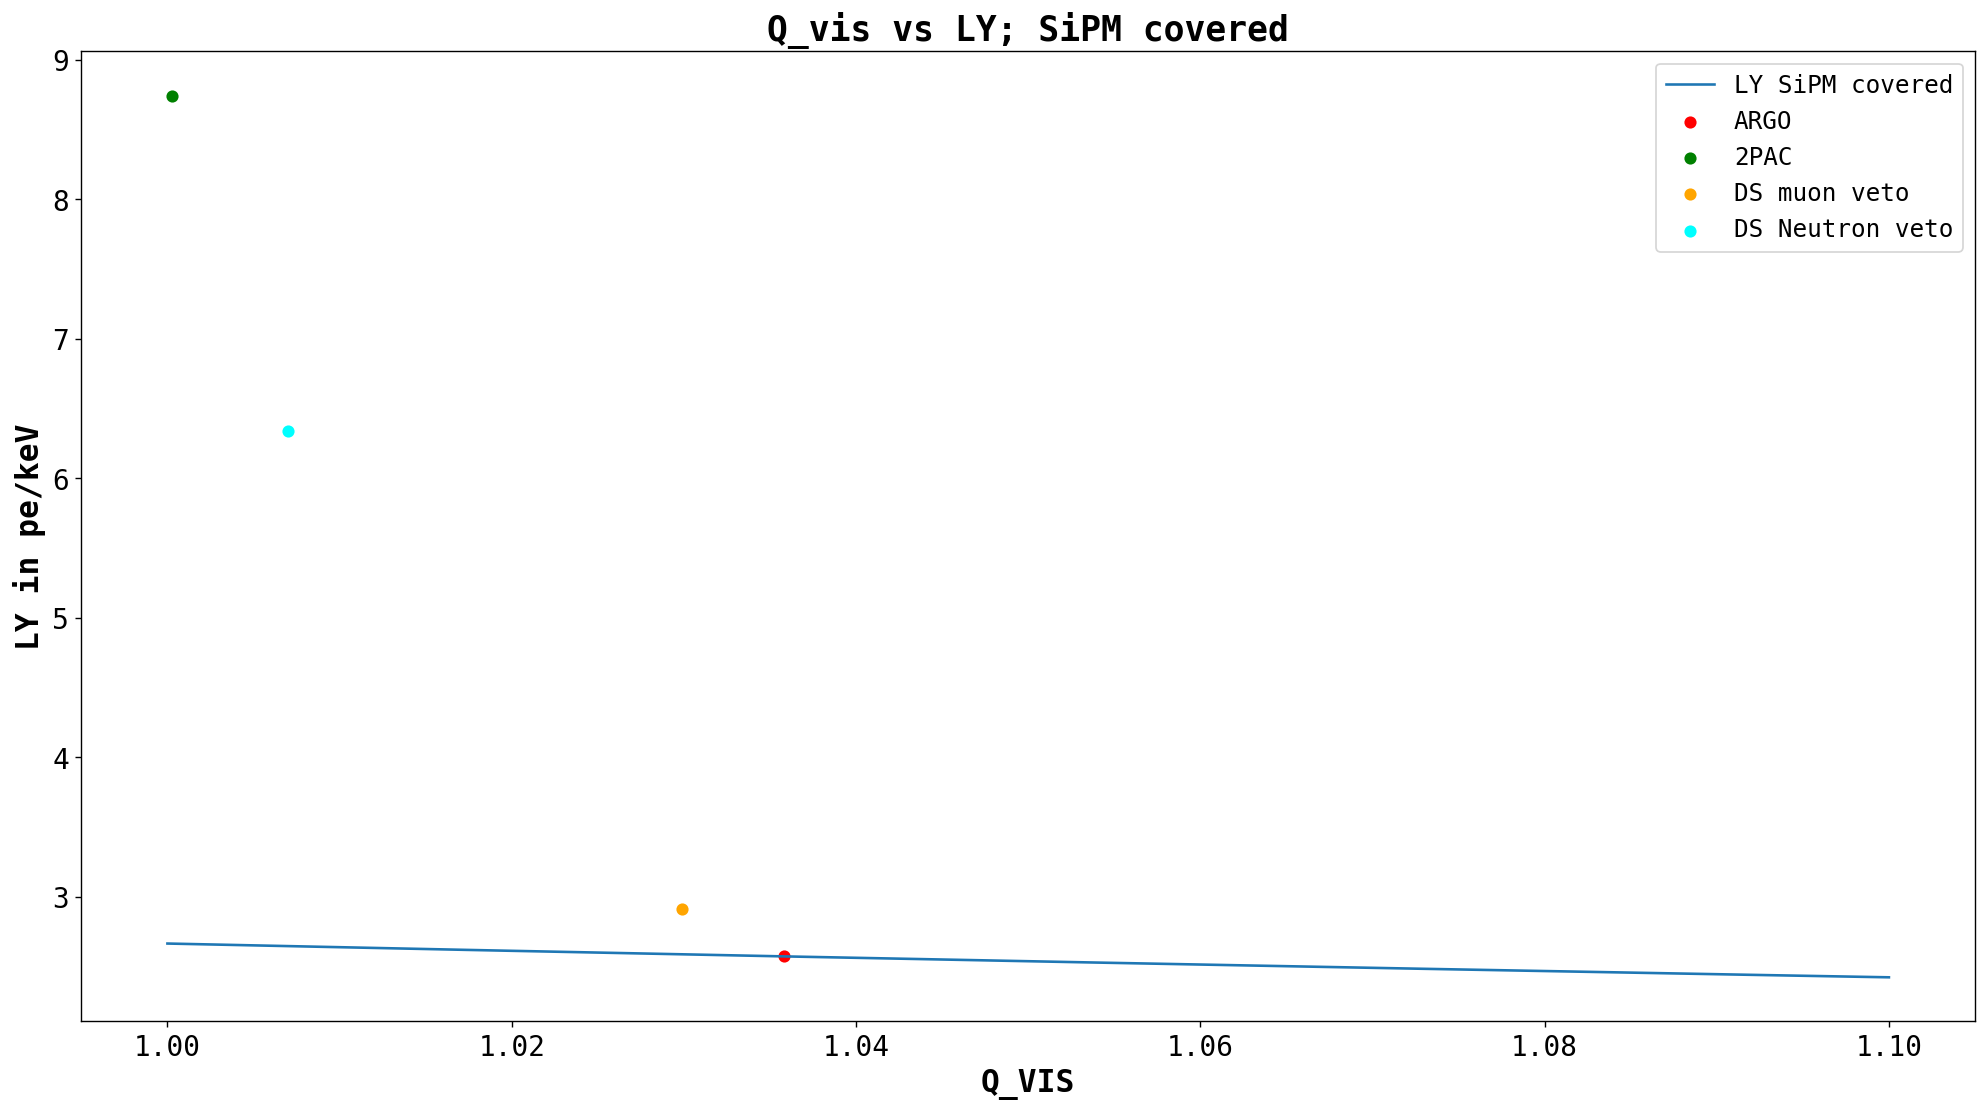

In [88]:
# shows Q_vis vs LY
# Not important as Q_vis changes very slowly with characteristic length
# Still I wouldn't want to delete this cell

# %matplotlib inline
fig16 = plt.figure('16')
ax16 = plt.axes()
ax16.plot(Q_feasible_values, LY_vector_3, label='LY SiPM covered')
ax16.set_yscale('linear')
ax16.legend(loc='best')
ax16.set_xlabel('Q_VIS')
ax16.set_ylabel('LY in pe/keV')
ax16.scatter(Q_vis_ARGO, LY_ARGO_3, label='ARGO', color='red')
ax16.scatter(Q_vis_2PAC, LY_2PAC_3, label='2PAC', color='green')
ax16.scatter(Q_vis_DS_muon_veto, LY_DS_muon_veto_3, label='DS muon veto', color='orange')
ax16.scatter(Q_vis_DS_neutron_veto, LY_DS_neutron_veto_3, label='DS Neutron veto', color='cyan')
ax16.set_title('Q_vis vs LY; SiPM covered')
ax16.legend()

# the blue curve is only for ARGO and red marker falls on it which is for ARGO as well.

<h1 style = 'color: #ff0038; text-align: center'> LY for VUV sensitive SiPM's WITHOUT wavelength shifter </h1>

<h2 style = 'color: deeppink'> Formulation for LY for VUV sensitive SiPM </h2>

<span style = 'color : lime;  font-size:14pt;'>

$$ F_{VUV} = \frac{f_{sen}FF_{sys}T}{Q-( f_{sen}R + (1-f_{sen}){R_{wall}} )} $$

</span>
<br>
<span style = 'color : lime;  font-size:14pt;'>
    
$$X_{T} = FF_{sys}f_{sen}T$$

$$ F(Q, X_T, s + w) = \frac{X_T}{Q-(s+w)} $$

</span>
<br>

In [89]:
def calc_F_vuv(Q, R, A, R_wall, f_sen, FF_sys):
    '''
    R + A + T= 1
    T = 1 - (R + A)
    '''
    return f_sen*FF_sys*(1-(R+A))/(Q - (f_sen*R + (1-f_sen)*R_wall) )

In [90]:
# calc_F(R, R_Wall, f_sen, 1, 1)
# need R_wall for 128nm 
# Also create loop for R 
# separate plots for f_sen?
# calc_LCE_vuv(0.5, )

In [91]:
# Copying and modifying some functions since F definition has changed for VUV sensitive SiPM's.

<p> <span style = 'color:red;'>Note: </span> Change wall reflectance </p>

<h2 style = 'color: DeepPink; text-align:center; font-size:24pt;'> Light Yield 🎂</h2>
<br>
<span style = 'color:lightgreen; font-size: 14pt'> Remember there is no WLS anywhere in this configuration. Thus, 
<br>
</span>
<br>
<span style = 'color:lime;  font-size:14pt;'>
    $$
    LCE_{VUV} = F_{VUV}(Q_{VUV}, X_{T}, s+w)
    $$
</span>
<br>
<span style = 'color: lightgreen; font-size:14pt'>
    No need for integration as we only have one wavelength. Thus, 
<br>
<br>
</span>
<span style = 'color : lime; font-size:14pt;'> 
$$
LY_{VUV} = SY*PDE*F_{VUV}
$$
</span>
<br>

In [92]:
def calc_LY_vuv( R, A, R_wall, f_sen, FF_sys = 1, Q_vuv = 1, PDE=0.15, SY = 40):

    return SY*PDE*calc_F_vuv(Q_vuv, R, A, R_wall, f_sen, FF_sys)

<h2 style = 'color: deeppink'> LY estimation for different values of A and R </h2>

In [93]:
R = np.arange(0.2, 0.6, 0.01) # reflectance of antireflection coating on SiPM
A = np.arange(0, 0.3, 0.01) # absorption inantireflection coating on SiPMabsorp
R, A = np.meshgrid(R, A)

R_wall_fixed = 0.80 # Ask Marcin

f_sen_min = (np.pi*(7.05/2)**2)/(2*np.pi*(7.05/2)*( 7.05/2 + 7.05))
f_sen_max = 1.0
lambda_abs_min = 20
lambda_abs_max = 100
Q_vuv_ARGO_max = calc_Q(L_char=L_char_ARGO, lambda_abs=lambda_abs_min, lambda_R=0.97)
Q_vuv_ARGO_min = calc_Q(L_char=L_char_ARGO, lambda_abs=lambda_abs_max, lambda_R=0.97)

In [94]:
f_sen_min

0.16666666666666666

In [95]:
from matplotlib import lines
from matplotlib import cm
from matplotlib import ticker

In [96]:
# fen_sen min Q_vuv min

LY_11 = calc_LY_vuv(R, A, R_wall_fixed, f_sen_min, Q_vuv=Q_vuv_ARGO_min)
LY_12 = calc_LY_vuv(R, A, R_wall_fixed, f_sen_min, Q_vuv=Q_vuv_ARGO_max)
LY_21 = calc_LY_vuv(R, A, R_wall_fixed, f_sen_max, Q_vuv=Q_vuv_ARGO_min)
LY_22 = calc_LY_vuv(R, A, R_wall_fixed, f_sen_max, Q_vuv=Q_vuv_ARGO_max)

<h2 style = 'color: deeppink'> plots for different sets of $f_{sen}$ and $ \lambda_{abs}$ </h2>

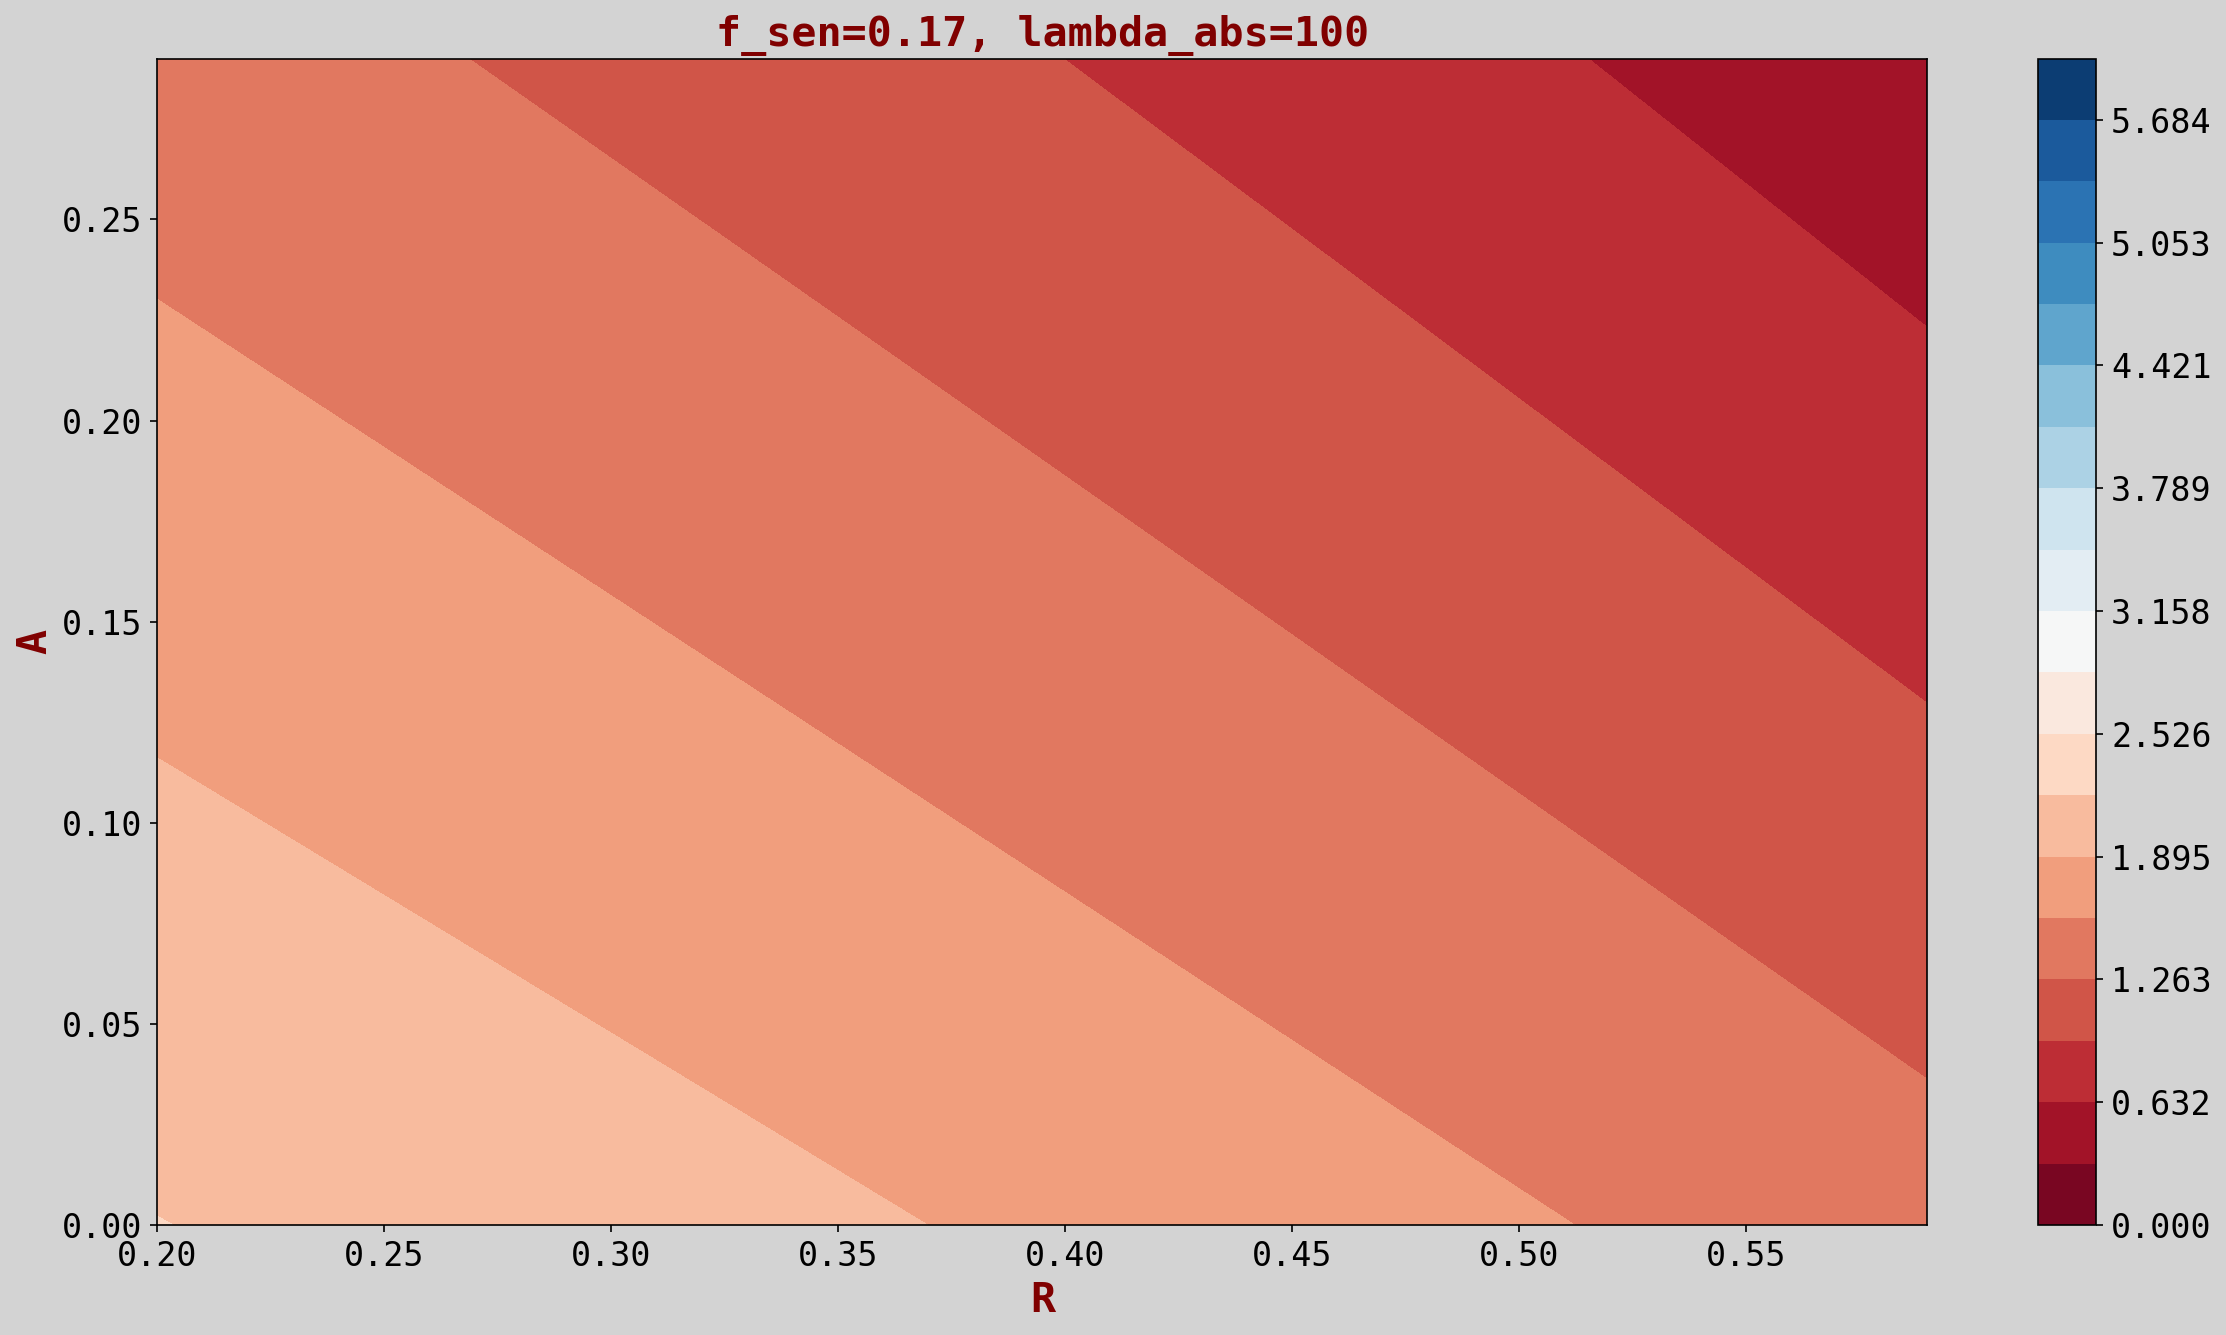

In [97]:
# %matplotlib qt
# %matplotlib inline
# contour plots

fig21 = plt.figure('21', figsize=[16,9], dpi=150)
ax21 = plt.axes()

# cs = ax21.contourf(R, A, LY_11, levels = np.linspace(LY_11.min(), LY_11.max(), 20),
#              locator=ticker.LinearLocator(), cmap=cm.RdBu)
cs = ax21.contourf(R, A, LY_11, levels = np.linspace(0, 6, 20),
             locator=ticker.LinearLocator(), cmap=cm.RdBu)

ax21.set_xlabel('R', color='maroon', weight='bold', fontsize='20')
ax21.set_ylabel('A', color='maroon', weight='bold', fontsize='20')
cbar = fig21.colorbar(cs)
ax21.set_title(f"f_sen={f_sen_min:.2f}, lambda_abs={lambda_abs_max}", color='maroon', weight='bold', fontsize='20') 
ax21.set_facecolor('lightgrey')
fig21.set_facecolor('lightgrey')
# min in Q_vuv corresponds to max lambda_abs
fig21.savefig(r'C:\Users\sarth\projects\LY_Analytic_Model\all_plots\fig21.png')

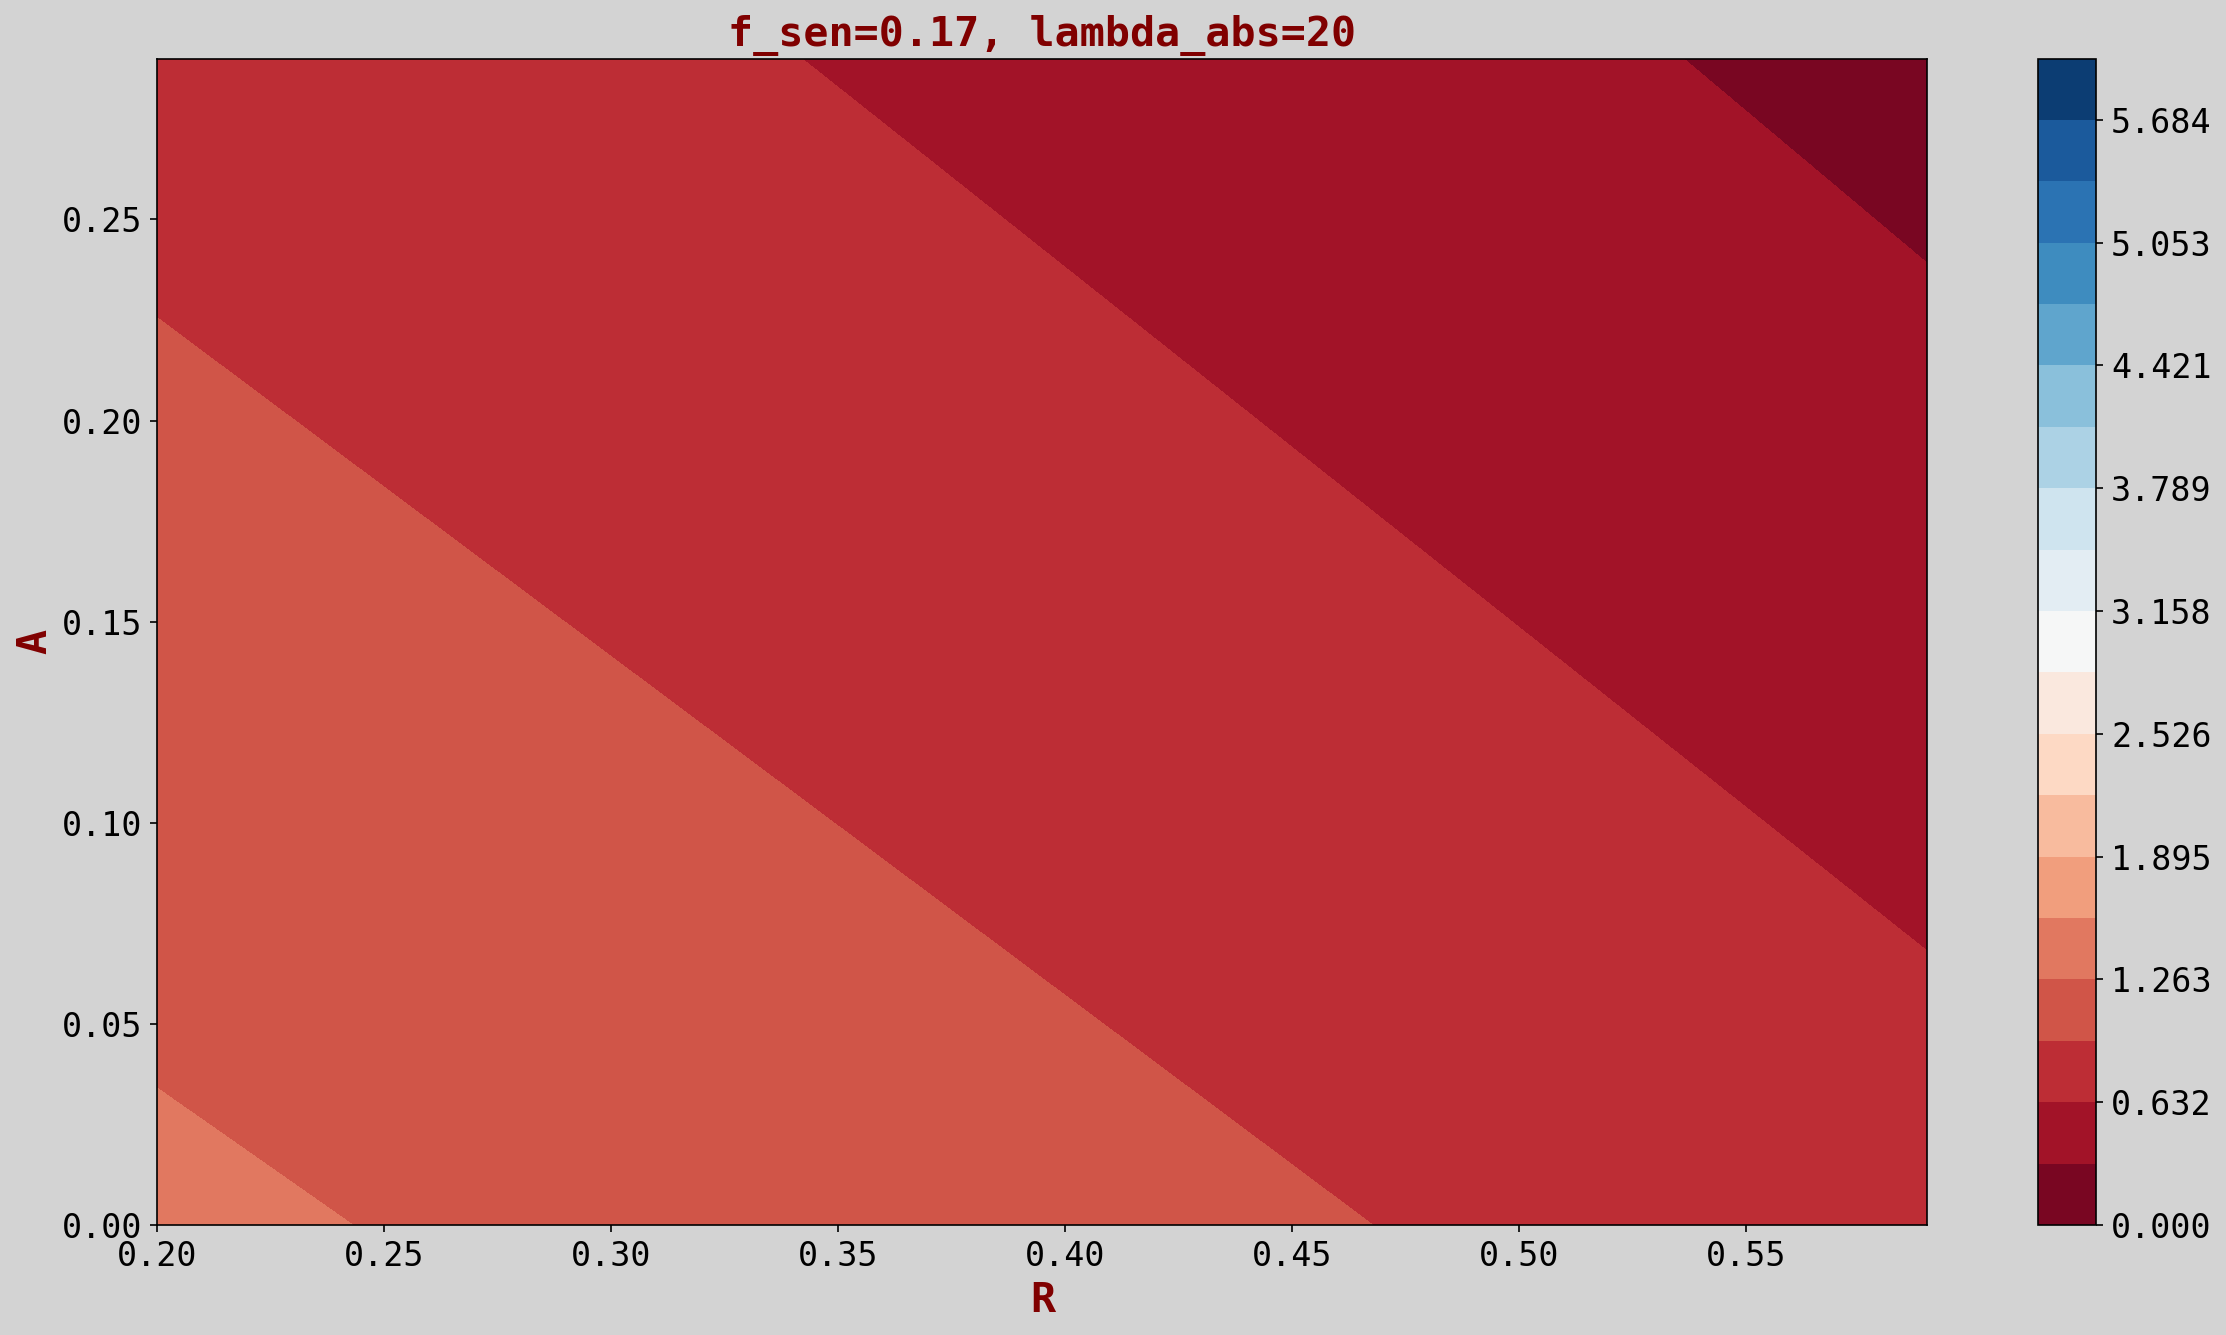

In [98]:
# %matplotlib qt

fig22 = plt.figure('22', figsize=[16,9], dpi=150)
ax22 = plt.axes()

# cs = ax22.contourf(R, A, LY_12, levels = np.linspace(LY_12.min(), LY_12.max(), 20),
#              locator=ticker.LinearLocator(), cmap=cm.RdBu)

cs = ax22.contourf(R, A, LY_12, levels = np.linspace(0, 6, 20),
             locator=ticker.LinearLocator(), cmap=cm.RdBu)

ax22.set_xlabel('R', color='maroon', weight='bold', fontsize='20')
ax22.set_ylabel('A', color='maroon', weight='bold', fontsize='20')
fig22.colorbar(cs)
ax22.set_title(f"f_sen={f_sen_min:.2f}, lambda_abs={lambda_abs_min}", color='maroon', weight='bold', fontsize='20')
fig22.set_facecolor('lightgrey')
fig22.savefig(r'C:\Users\sarth\projects\LY_Analytic_Model\all_plots\fig22.png')

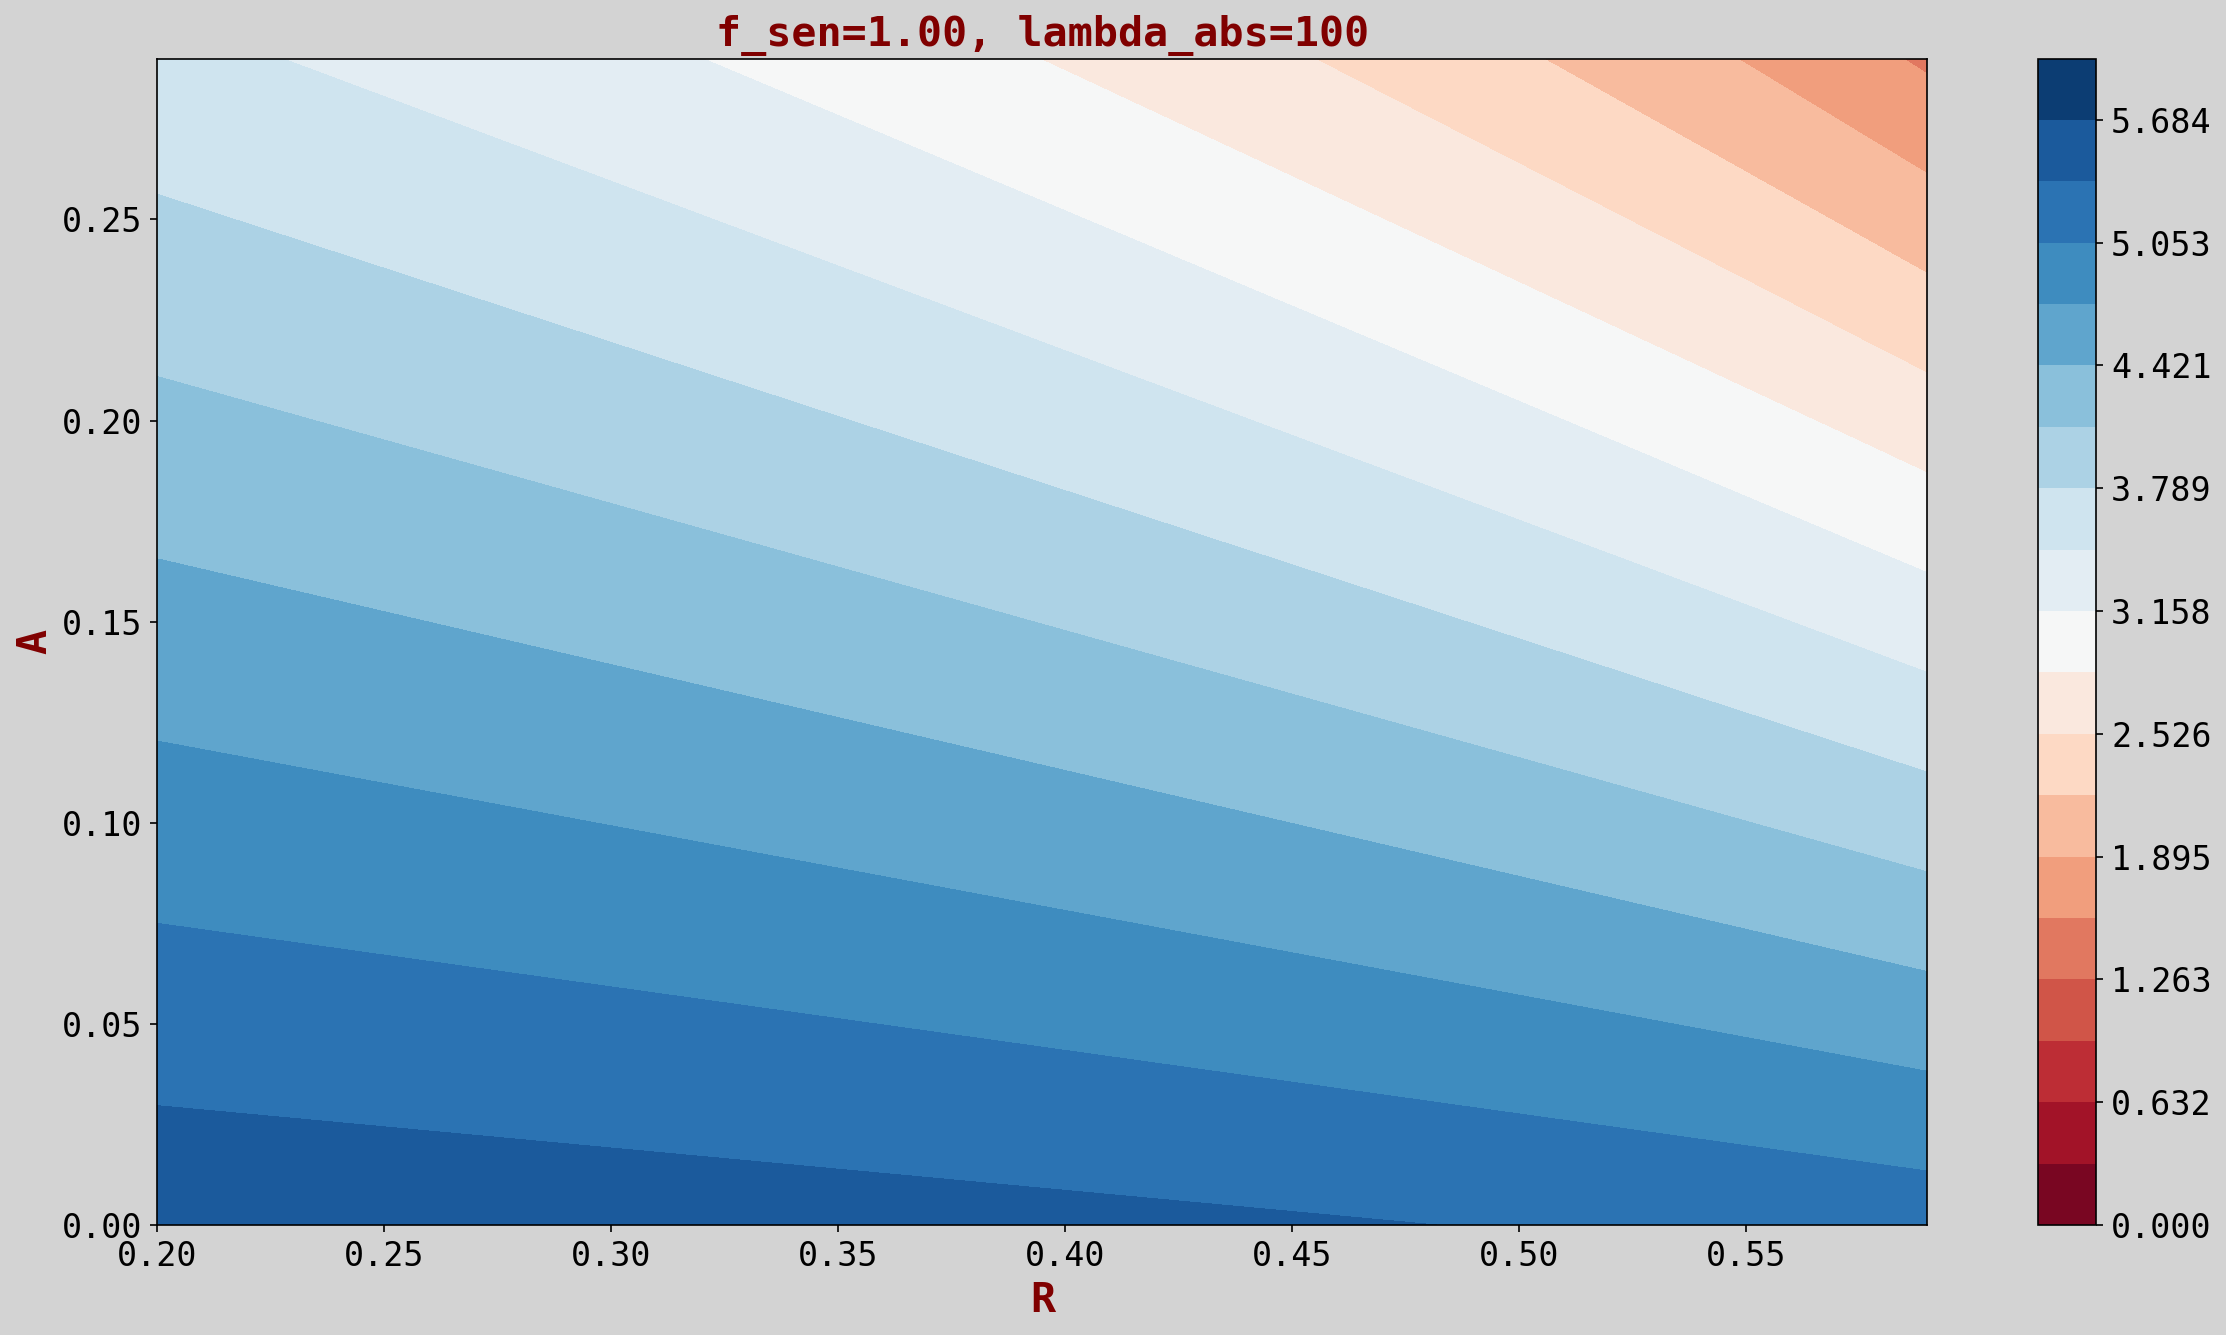

In [99]:
# %matplotlib qt

fig23 = plt.figure('23', figsize=[16,9], dpi=150)
ax23 = plt.axes()

# cs = ax23.contourf(R, A, LY_21, levels = np.linspace(LY_21.min(), LY_21.max(), 20),
#              locator=ticker.LinearLocator(), cmap=cm.RdBu)

cs = ax23.contourf(R, A, LY_21, levels = np.linspace(0, 6, 20),
             locator=ticker.LinearLocator(), cmap=cm.RdBu)

ax23.set_xlabel('R', color='maroon', weight='bold', fontsize='20')
ax23.set_ylabel('A', color='maroon', weight='bold', fontsize='20')
fig23.colorbar(cs)
ax23.set_title(f"f_sen={f_sen_max:.2f}, lambda_abs={lambda_abs_max}", color='maroon', weight='bold', fontsize='20')
fig23.set_facecolor('lightgrey')
fig23.savefig(r'C:\Users\sarth\projects\LY_Analytic_Model\all_plots\fig23.png')

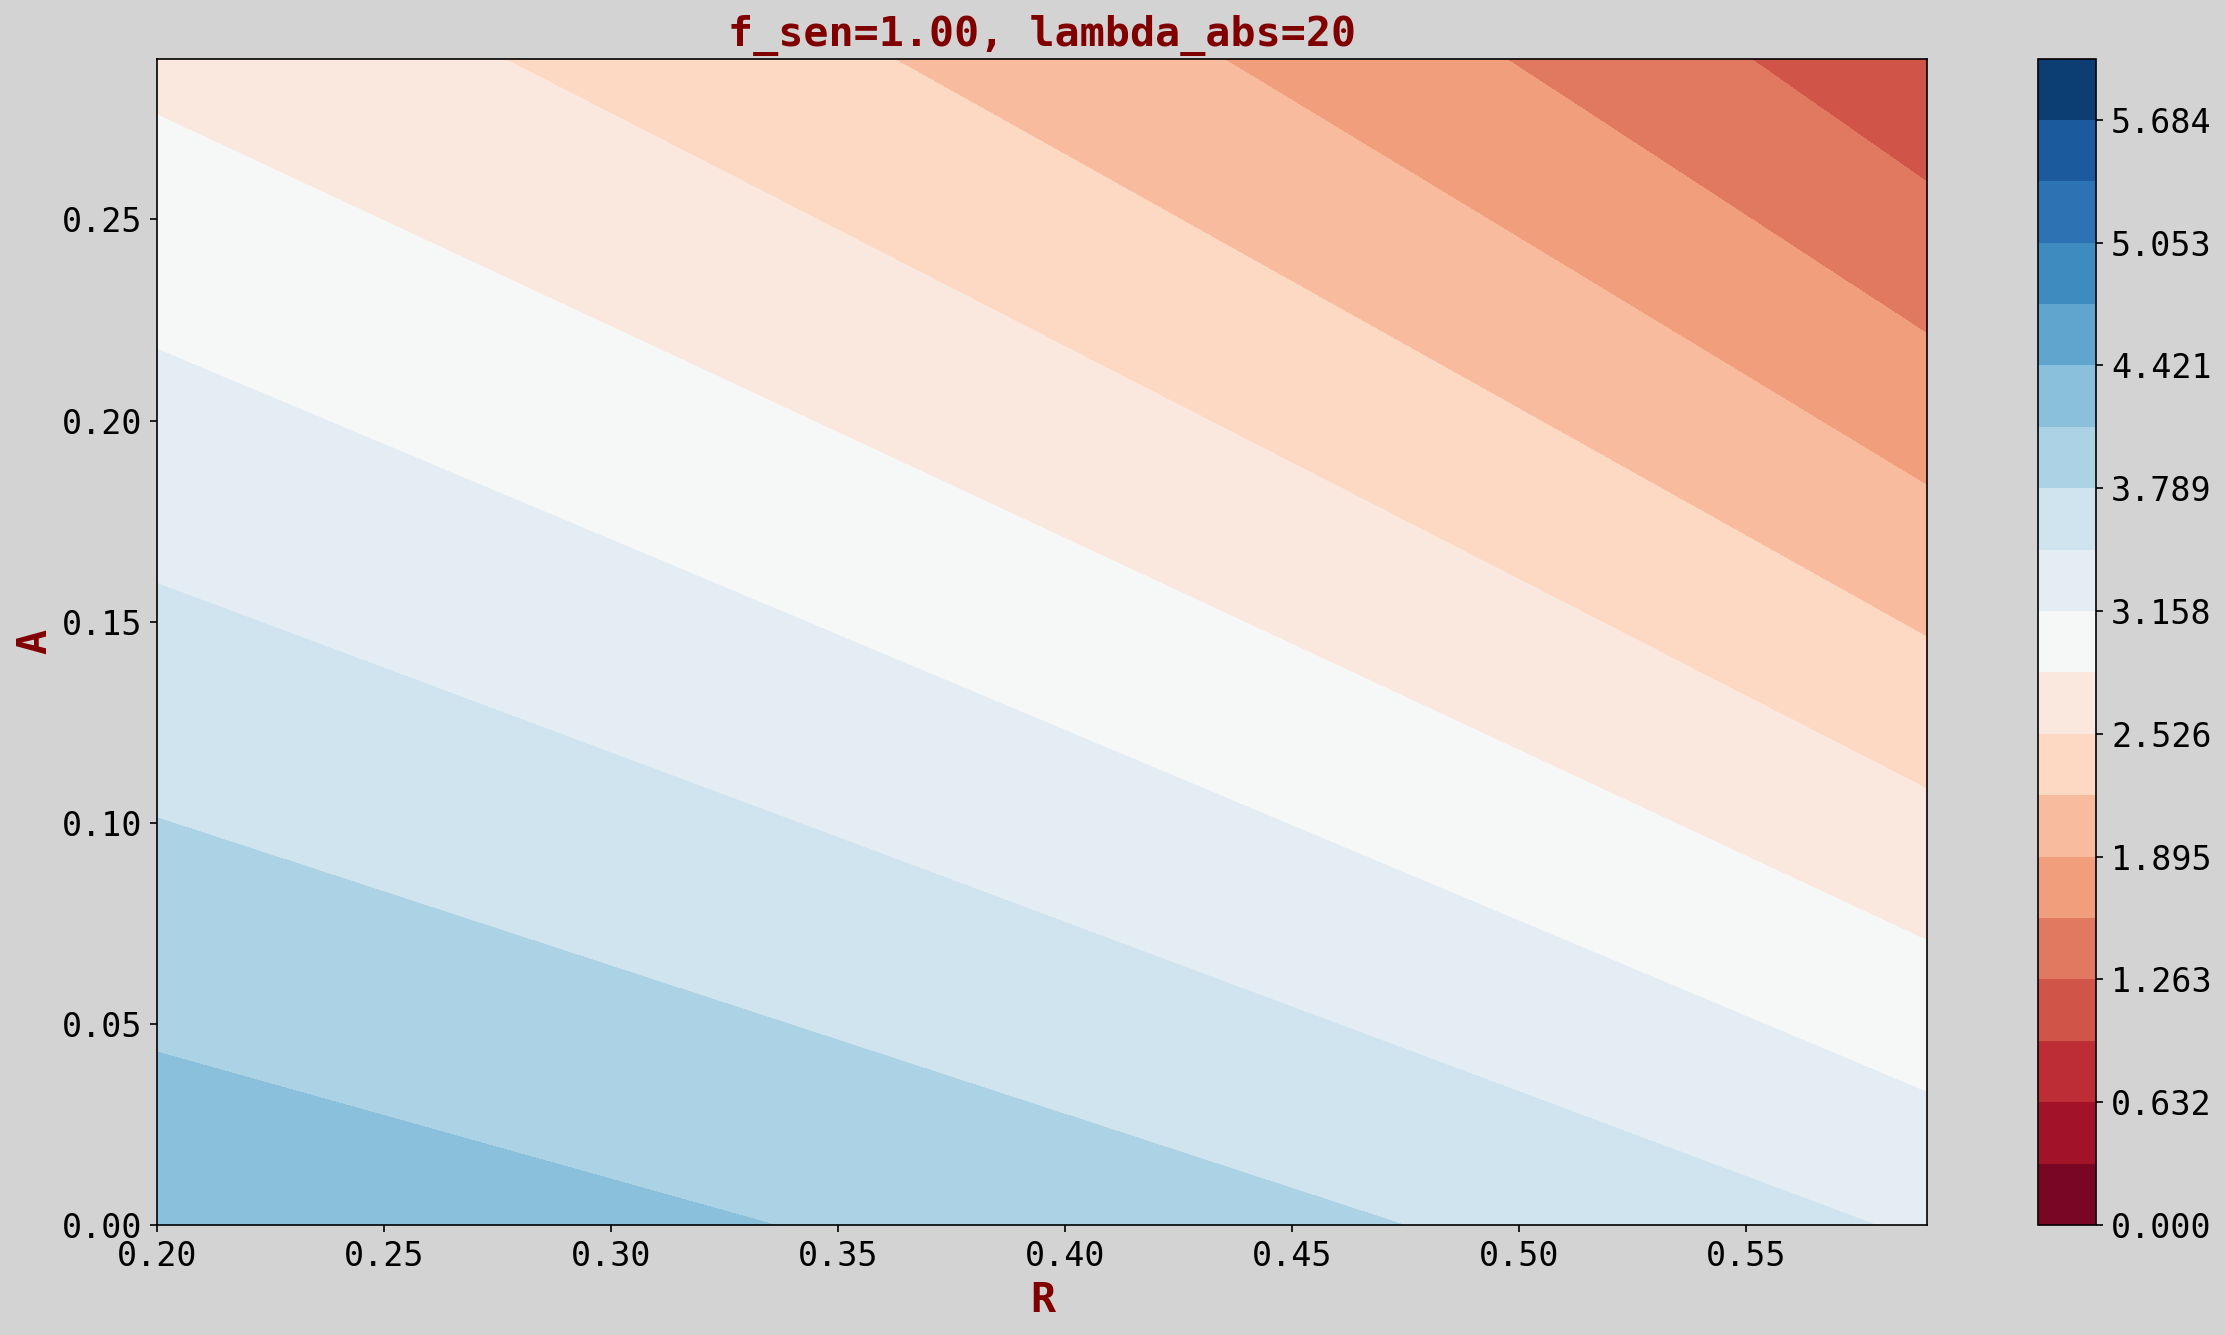

In [100]:
# %matplotlib qt

fig24 = plt.figure('24', figsize=[16,9], dpi=150)
ax24 = plt.axes()

# cs = ax24.contourf(R, A, LY_22, levels = np.linspace(LY_22.min(), LY_22.max(), 20),
#              locator=ticker.LinearLocator(), cmap=cm.RdBu)

cs = ax24.contourf(R, A, LY_22, levels = np.linspace(0, 6, 20),
             locator=ticker.LinearLocator(), cmap=cm.RdBu)

ax24.set_xlabel('R', color='maroon', weight='bold', fontsize='20')
ax24.set_ylabel('A', color='maroon', weight='bold', fontsize='20')
fig24.colorbar(cs)
ax24.set_title(f"f_sen={f_sen_max:.2f}, lambda_abs={lambda_abs_min}", color='maroon', weight='bold', fontsize='20')
fig24.set_facecolor('lightgrey')
fig24.savefig(r'C:\Users\sarth\projects\LY_Analytic_Model\all_plots\fig24.png')

In [101]:
# # surface plots
# # %matplotlib qt

# fig17 = plt.figure('17')
# ax17 = plt.axes(projection='3d')

# ax17.plot_surface(R, A, LY_11, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True, label='f_sen=min, Q_vuv=min')
# ax17.set_xlabel('R', color='red', weight='bold', fontsize='14')
# ax17.set_ylabel('A', color='red', weight='bold', fontsize='14')
# ax17.set_zlabel('LY', color='red', weight='bold', fontsize='14')

# # fake2Dline=lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o') # just for adding legend
# # ax17.legend([fake2Dline], ['surface plot for f_sen=min, Q_vuv=min'], numpoints = 1)
# ax17.set_title('f_sen=min, Q_vuv=min')

In [102]:
# fig18 = plt.figure('18')
# ax18 = plt.axes(projection='3d')

# ax18.plot_surface(R, A, LY_12, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True, label='f_sen=min, Q_vuv=max')
# ax18.set_xlabel('R', color='red', weight='bold', fontsize='14')
# ax18.set_ylabel('A', color='red', weight='bold', fontsize='14')
# ax18.set_zlabel('LY', color='red', weight='bold', fontsize='14')

# ax18.set_title('f_sen=min, Q_vuv=max')

In [103]:
# fig19 = plt.figure('19')
# ax19 = plt.axes(projection='3d')

# ax19.plot_surface(R, A, LY_21, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True, label='f_sen=max, Q_vuv=min')
# ax19.set_xlabel('R', color='red', weight='bold', fontsize='14')
# ax19.set_ylabel('A', color='red', weight='bold', fontsize='14')
# ax19.set_zlabel('LY', color='red', weight='bold', fontsize='14')

# ax19.set_title('f_sen=max, Q_vuv=min')

In [104]:
# fig20 = plt.figure('20')
# ax20 = plt.axes(projection='3d')

# ax20.plot_surface(R, A, LY_22, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True, label='f_sen=max, Q_vuv=max')
# ax20.set_xlabel('R', color='red', weight='bold', fontsize='14')
# ax20.set_ylabel('A', color='red', weight='bold', fontsize='14')
# ax20.set_zlabel('LY', color='red', weight='bold', fontsize='14')

# ax20.set_title('f_sen=max, Q_vuv=max')

In [105]:
# %matplotlib inline